In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 828)
(4629816, 8)
validation
(621056, 828)
(621056, 8)
test
(624904, 828)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 13:05 - loss: 2.3160 - STD: 0.1045 - MAE: 0.2143

  4/463 [..............................] - ETA: 10s - loss: 2.1439 - STD: 0.0561 - MAE: 0.2163  

  7/463 [..............................] - ETA: 10s - loss: 2.1261 - STD: 0.0479 - MAE: 0.2170

 10/463 [..............................] - ETA: 10s - loss: 2.1084 - STD: 0.0447 - MAE: 0.2169

 13/463 [..............................] - ETA: 10s - loss: 2.0965 - STD: 0.0440 - MAE: 0.2168

 16/463 [>.............................] - ETA: 10s - loss: 2.0889 - STD: 0.0437 - MAE: 0.2166

 19/463 [>.............................] - ETA: 10s - loss: 2.0833 - STD: 0.0429 - MAE: 0.2166

 22/463 [>.............................] - ETA: 9s - loss: 2.0779 - STD: 0.0415 - MAE: 0.2165 

 25/463 [>.............................] - ETA: 9s - loss: 2.0727 - STD: 0.0399 - MAE: 0.2165

 28/463 [>.............................] - ETA: 9s - loss: 2.0676 - STD: 0.0391 - MAE: 0.2165

 31/463 [=>............................] - ETA: 9s - loss: 2.0616 - STD: 0.0388 - MAE: 0.2163

 34/463 [=>............................] - ETA: 9s - loss: 2.0537 - STD: 0.0389 - MAE: 0.2161

 37/463 [=>............................] - ETA: 9s - loss: 2.0439 - STD: 0.0398 - MAE: 0.2157

 40/463 [=>............................] - ETA: 9s - loss: 2.0333 - STD: 0.0413 - MAE: 0.2152

 43/463 [=>............................] - ETA: 9s - loss: 2.0219 - STD: 0.0430 - MAE: 0.2147

 46/463 [=>............................] - ETA: 9s - loss: 2.0105 - STD: 0.0450 - MAE: 0.2142

 49/463 [==>...........................] - ETA: 9s - loss: 2.0000 - STD: 0.0470 - MAE: 0.2137

 52/463 [==>...........................] - ETA: 9s - loss: 1.9892 - STD: 0.0489 - MAE: 0.2132

 55/463 [==>...........................] - ETA: 9s - loss: 1.9790 - STD: 0.0507 - MAE: 0.2127

 58/463 [==>...........................] - ETA: 9s - loss: 1.9688 - STD: 0.0525 - MAE: 0.2122

 61/463 [==>...........................] - ETA: 9s - loss: 1.9585 - STD: 0.0540 - MAE: 0.2117

 64/463 [===>..........................] - ETA: 9s - loss: 1.9479 - STD: 0.0555 - MAE: 0.2112

 67/463 [===>..........................] - ETA: 8s - loss: 1.9369 - STD: 0.0569 - MAE: 0.2107

 70/463 [===>..........................] - ETA: 8s - loss: 1.9255 - STD: 0.0584 - MAE: 0.2101

 73/463 [===>..........................] - ETA: 8s - loss: 1.9136 - STD: 0.0600 - MAE: 0.2096

 76/463 [===>..........................] - ETA: 8s - loss: 1.9018 - STD: 0.0616 - MAE: 0.2090

 79/463 [====>.........................] - ETA: 8s - loss: 1.8897 - STD: 0.0632 - MAE: 0.2083

 82/463 [====>.........................] - ETA: 8s - loss: 1.8776 - STD: 0.0650 - MAE: 0.2077

 84/463 [====>.........................] - ETA: 13s - loss: 1.8698 - STD: 0.0661 - MAE: 0.2072

 87/463 [====>.........................] - ETA: 13s - loss: 1.8584 - STD: 0.0679 - MAE: 0.2065

 90/463 [====>.........................] - ETA: 12s - loss: 1.8469 - STD: 0.0696 - MAE: 0.2059

 93/463 [=====>........................] - ETA: 12s - loss: 1.8356 - STD: 0.0713 - MAE: 0.2052

 96/463 [=====>........................] - ETA: 12s - loss: 1.8247 - STD: 0.0729 - MAE: 0.2045

 99/463 [=====>........................] - ETA: 12s - loss: 1.8136 - STD: 0.0746 - MAE: 0.2038

102/463 [=====>........................] - ETA: 11s - loss: 1.8029 - STD: 0.0763 - MAE: 0.2031

105/463 [=====>........................] - ETA: 11s - loss: 1.7924 - STD: 0.0779 - MAE: 0.2024

108/463 [=====>........................] - ETA: 11s - loss: 1.7819 - STD: 0.0795 - MAE: 0.2017

110/463 [======>.......................] - ETA: 11s - loss: 1.7751 - STD: 0.0806 - MAE: 0.2013

113/463 [======>.......................] - ETA: 11s - loss: 1.7651 - STD: 0.0822 - MAE: 0.2006

116/463 [======>.......................] - ETA: 11s - loss: 1.7555 - STD: 0.0838 - MAE: 0.1999

119/463 [======>.......................] - ETA: 10s - loss: 1.7460 - STD: 0.0853 - MAE: 0.1992

122/463 [======>.......................] - ETA: 10s - loss: 1.7365 - STD: 0.0869 - MAE: 0.1986

125/463 [=======>......................] - ETA: 10s - loss: 1.7273 - STD: 0.0883 - MAE: 0.1979

128/463 [=======>......................] - ETA: 10s - loss: 1.7184 - STD: 0.0898 - MAE: 0.1972

131/463 [=======>......................] - ETA: 10s - loss: 1.7096 - STD: 0.0912 - MAE: 0.1966

134/463 [=======>......................] - ETA: 10s - loss: 1.7009 - STD: 0.0926 - MAE: 0.1960

137/463 [=======>......................] - ETA: 9s - loss: 1.6928 - STD: 0.0940 - MAE: 0.1953 

140/463 [========>.....................] - ETA: 9s - loss: 1.6848 - STD: 0.0953 - MAE: 0.1947

143/463 [========>.....................] - ETA: 9s - loss: 1.6773 - STD: 0.0967 - MAE: 0.1941

146/463 [========>.....................] - ETA: 9s - loss: 1.6697 - STD: 0.0979 - MAE: 0.1936

149/463 [========>.....................] - ETA: 9s - loss: 1.6625 - STD: 0.0992 - MAE: 0.1930

152/463 [========>.....................] - ETA: 9s - loss: 1.6555 - STD: 0.1004 - MAE: 0.1925

155/463 [=========>....................] - ETA: 9s - loss: 1.6484 - STD: 0.1015 - MAE: 0.1919

158/463 [=========>....................] - ETA: 8s - loss: 1.6416 - STD: 0.1027 - MAE: 0.1914

161/463 [=========>....................] - ETA: 8s - loss: 1.6351 - STD: 0.1038 - MAE: 0.1909

164/463 [=========>....................] - ETA: 8s - loss: 1.6285 - STD: 0.1048 - MAE: 0.1904

167/463 [=========>....................] - ETA: 8s - loss: 1.6223 - STD: 0.1059 - MAE: 0.1899

170/463 [==========>...................] - ETA: 8s - loss: 1.6162 - STD: 0.1069 - MAE: 0.1894

173/463 [==========>...................] - ETA: 8s - loss: 1.6103 - STD: 0.1079 - MAE: 0.1889

176/463 [==========>...................] - ETA: 8s - loss: 1.6047 - STD: 0.1089 - MAE: 0.1885

179/463 [==========>...................] - ETA: 8s - loss: 1.5990 - STD: 0.1098 - MAE: 0.1880

182/463 [==========>...................] - ETA: 8s - loss: 1.5934 - STD: 0.1107 - MAE: 0.1876

185/463 [==========>...................] - ETA: 7s - loss: 1.5879 - STD: 0.1116 - MAE: 0.1871

188/463 [===========>..................] - ETA: 7s - loss: 1.5825 - STD: 0.1125 - MAE: 0.1867

191/463 [===========>..................] - ETA: 7s - loss: 1.5773 - STD: 0.1134 - MAE: 0.1863

194/463 [===========>..................] - ETA: 7s - loss: 1.5722 - STD: 0.1142 - MAE: 0.1859

197/463 [===========>..................] - ETA: 7s - loss: 1.5673 - STD: 0.1151 - MAE: 0.1855

200/463 [===========>..................] - ETA: 7s - loss: 1.5624 - STD: 0.1159 - MAE: 0.1851

203/463 [============>.................] - ETA: 7s - loss: 1.5576 - STD: 0.1166 - MAE: 0.1847

206/463 [============>.................] - ETA: 7s - loss: 1.5529 - STD: 0.1174 - MAE: 0.1843

209/463 [============>.................] - ETA: 7s - loss: 1.5482 - STD: 0.1182 - MAE: 0.1839

212/463 [============>.................] - ETA: 6s - loss: 1.5436 - STD: 0.1189 - MAE: 0.1835

215/463 [============>.................] - ETA: 6s - loss: 1.5392 - STD: 0.1197 - MAE: 0.1832

218/463 [=============>................] - ETA: 6s - loss: 1.5349 - STD: 0.1204 - MAE: 0.1828

221/463 [=============>................] - ETA: 6s - loss: 1.5306 - STD: 0.1211 - MAE: 0.1825

224/463 [=============>................] - ETA: 6s - loss: 1.5266 - STD: 0.1218 - MAE: 0.1821

227/463 [=============>................] - ETA: 6s - loss: 1.5225 - STD: 0.1225 - MAE: 0.1818

230/463 [=============>................] - ETA: 6s - loss: 1.5184 - STD: 0.1232 - MAE: 0.1814

233/463 [==============>...............] - ETA: 6s - loss: 1.5145 - STD: 0.1238 - MAE: 0.1811

236/463 [==============>...............] - ETA: 6s - loss: 1.5105 - STD: 0.1245 - MAE: 0.1808

239/463 [==============>...............] - ETA: 6s - loss: 1.5068 - STD: 0.1251 - MAE: 0.1805

242/463 [==============>...............] - ETA: 5s - loss: 1.5030 - STD: 0.1257 - MAE: 0.1801

245/463 [==============>...............] - ETA: 5s - loss: 1.4993 - STD: 0.1264 - MAE: 0.1798

248/463 [===============>..............] - ETA: 5s - loss: 1.4957 - STD: 0.1269 - MAE: 0.1795

251/463 [===============>..............] - ETA: 5s - loss: 1.4921 - STD: 0.1275 - MAE: 0.1792

254/463 [===============>..............] - ETA: 5s - loss: 1.4886 - STD: 0.1281 - MAE: 0.1789

257/463 [===============>..............] - ETA: 5s - loss: 1.4852 - STD: 0.1287 - MAE: 0.1786

260/463 [===============>..............] - ETA: 5s - loss: 1.4819 - STD: 0.1293 - MAE: 0.1783

263/463 [================>.............] - ETA: 5s - loss: 1.4785 - STD: 0.1298 - MAE: 0.1780

266/463 [================>.............] - ETA: 5s - loss: 1.4753 - STD: 0.1304 - MAE: 0.1778

269/463 [================>.............] - ETA: 5s - loss: 1.4720 - STD: 0.1309 - MAE: 0.1775

272/463 [================>.............] - ETA: 5s - loss: 1.4688 - STD: 0.1314 - MAE: 0.1772

275/463 [================>.............] - ETA: 4s - loss: 1.4657 - STD: 0.1320 - MAE: 0.1769

278/463 [=================>............] - ETA: 4s - loss: 1.4626 - STD: 0.1325 - MAE: 0.1767

281/463 [=================>............] - ETA: 4s - loss: 1.4596 - STD: 0.1330 - MAE: 0.1764

284/463 [=================>............] - ETA: 4s - loss: 1.4566 - STD: 0.1335 - MAE: 0.1761

287/463 [=================>............] - ETA: 4s - loss: 1.4536 - STD: 0.1340 - MAE: 0.1759

290/463 [=================>............] - ETA: 4s - loss: 1.4507 - STD: 0.1345 - MAE: 0.1756

293/463 [=================>............] - ETA: 4s - loss: 1.4479 - STD: 0.1350 - MAE: 0.1753

296/463 [==================>...........] - ETA: 4s - loss: 1.4450 - STD: 0.1354 - MAE: 0.1751

299/463 [==================>...........] - ETA: 4s - loss: 1.4422 - STD: 0.1359 - MAE: 0.1748

302/463 [==================>...........] - ETA: 4s - loss: 1.4396 - STD: 0.1364 - MAE: 0.1746

305/463 [==================>...........] - ETA: 4s - loss: 1.4369 - STD: 0.1368 - MAE: 0.1744

308/463 [==================>...........] - ETA: 4s - loss: 1.4343 - STD: 0.1373 - MAE: 0.1741

311/463 [===================>..........] - ETA: 3s - loss: 1.4317 - STD: 0.1377 - MAE: 0.1739

314/463 [===================>..........] - ETA: 3s - loss: 1.4291 - STD: 0.1382 - MAE: 0.1737

317/463 [===================>..........] - ETA: 3s - loss: 1.4266 - STD: 0.1386 - MAE: 0.1734

320/463 [===================>..........] - ETA: 3s - loss: 1.4240 - STD: 0.1390 - MAE: 0.1732

323/463 [===================>..........] - ETA: 3s - loss: 1.4215 - STD: 0.1395 - MAE: 0.1730

326/463 [====================>.........] - ETA: 3s - loss: 1.4191 - STD: 0.1399 - MAE: 0.1727

329/463 [====================>.........] - ETA: 3s - loss: 1.4167 - STD: 0.1403 - MAE: 0.1725

332/463 [====================>.........] - ETA: 3s - loss: 1.4144 - STD: 0.1407 - MAE: 0.1723

335/463 [====================>.........] - ETA: 3s - loss: 1.4119 - STD: 0.1411 - MAE: 0.1721

338/463 [====================>.........] - ETA: 3s - loss: 1.4096 - STD: 0.1415 - MAE: 0.1719

341/463 [=====================>........] - ETA: 3s - loss: 1.4072 - STD: 0.1419 - MAE: 0.1717

344/463 [=====================>........] - ETA: 3s - loss: 1.4049 - STD: 0.1423 - MAE: 0.1714

347/463 [=====================>........] - ETA: 2s - loss: 1.4025 - STD: 0.1427 - MAE: 0.1712

350/463 [=====================>........] - ETA: 2s - loss: 1.4001 - STD: 0.1431 - MAE: 0.1710

353/463 [=====================>........] - ETA: 2s - loss: 1.3979 - STD: 0.1434 - MAE: 0.1708

356/463 [======================>.......] - ETA: 2s - loss: 1.3956 - STD: 0.1438 - MAE: 0.1706

359/463 [======================>.......] - ETA: 2s - loss: 1.3934 - STD: 0.1442 - MAE: 0.1704

362/463 [======================>.......] - ETA: 2s - loss: 1.3912 - STD: 0.1446 - MAE: 0.1702

365/463 [======================>.......] - ETA: 2s - loss: 1.3891 - STD: 0.1449 - MAE: 0.1700

368/463 [======================>.......] - ETA: 2s - loss: 1.3870 - STD: 0.1453 - MAE: 0.1698

371/463 [=======================>......] - ETA: 2s - loss: 1.3848 - STD: 0.1456 - MAE: 0.1696

374/463 [=======================>......] - ETA: 2s - loss: 1.3827 - STD: 0.1460 - MAE: 0.1694

377/463 [=======================>......] - ETA: 2s - loss: 1.3806 - STD: 0.1463 - MAE: 0.1692

380/463 [=======================>......] - ETA: 2s - loss: 1.3788 - STD: 0.1467 - MAE: 0.1690

383/463 [=======================>......] - ETA: 2s - loss: 1.3767 - STD: 0.1470 - MAE: 0.1688

386/463 [========================>.....] - ETA: 1s - loss: 1.3746 - STD: 0.1473 - MAE: 0.1686

389/463 [========================>.....] - ETA: 1s - loss: 1.3727 - STD: 0.1477 - MAE: 0.1685

392/463 [========================>.....] - ETA: 1s - loss: 1.3708 - STD: 0.1480 - MAE: 0.1683

395/463 [========================>.....] - ETA: 1s - loss: 1.3688 - STD: 0.1483 - MAE: 0.1681

398/463 [========================>.....] - ETA: 1s - loss: 1.3668 - STD: 0.1486 - MAE: 0.1679

401/463 [========================>.....] - ETA: 1s - loss: 1.3650 - STD: 0.1489 - MAE: 0.1677

404/463 [=========================>....] - ETA: 1s - loss: 1.3632 - STD: 0.1493 - MAE: 0.1676

407/463 [=========================>....] - ETA: 1s - loss: 1.3614 - STD: 0.1496 - MAE: 0.1674

410/463 [=========================>....] - ETA: 1s - loss: 1.3596 - STD: 0.1499 - MAE: 0.1672

413/463 [=========================>....] - ETA: 1s - loss: 1.3578 - STD: 0.1502 - MAE: 0.1671

416/463 [=========================>....] - ETA: 1s - loss: 1.3560 - STD: 0.1505 - MAE: 0.1669

419/463 [==========================>...] - ETA: 1s - loss: 1.3543 - STD: 0.1508 - MAE: 0.1667

422/463 [==========================>...] - ETA: 1s - loss: 1.3526 - STD: 0.1511 - MAE: 0.1666

425/463 [==========================>...] - ETA: 0s - loss: 1.3510 - STD: 0.1513 - MAE: 0.1664

428/463 [==========================>...] - ETA: 0s - loss: 1.3493 - STD: 0.1516 - MAE: 0.1663

430/463 [==========================>...] - ETA: 0s - loss: 1.3481 - STD: 0.1518 - MAE: 0.1661

433/463 [===========================>..] - ETA: 0s - loss: 1.3464 - STD: 0.1521 - MAE: 0.1660

436/463 [===========================>..] - ETA: 0s - loss: 1.3448 - STD: 0.1524 - MAE: 0.1658

439/463 [===========================>..] - ETA: 0s - loss: 1.3431 - STD: 0.1526 - MAE: 0.1657

442/463 [===========================>..] - ETA: 0s - loss: 1.3415 - STD: 0.1529 - MAE: 0.1655

445/463 [===========================>..] - ETA: 0s - loss: 1.3398 - STD: 0.1532 - MAE: 0.1654

448/463 [============================>.] - ETA: 0s - loss: 1.3382 - STD: 0.1535 - MAE: 0.1652

451/463 [============================>.] - ETA: 0s - loss: 1.3365 - STD: 0.1537 - MAE: 0.1651

454/463 [============================>.] - ETA: 0s - loss: 1.3350 - STD: 0.1540 - MAE: 0.1649

457/463 [============================>.] - ETA: 0s - loss: 1.3334 - STD: 0.1543 - MAE: 0.1647

460/463 [============================>.] - ETA: 0s - loss: 1.3318 - STD: 0.1545 - MAE: 0.1646

463/463 [==============================] - ETA: 0s - loss: 1.3302 - STD: 0.1548 - MAE: 0.1645

463/463 [==============================] - 15s 28ms/step - loss: 1.3302 - STD: 0.1548 - MAE: 0.1645 - val_loss: 1.1879 - val_STD: 0.1891 - val_MAE: 0.1482


Epoch 2/10000


  1/463 [..............................] - ETA: 24s - loss: 1.0994 - STD: 0.1927 - MAE: 0.1426

  4/463 [..............................] - ETA: 10s - loss: 1.0863 - STD: 0.1937 - MAE: 0.1416

  7/463 [..............................] - ETA: 10s - loss: 1.0950 - STD: 0.1940 - MAE: 0.1420

 10/463 [..............................] - ETA: 10s - loss: 1.0975 - STD: 0.1943 - MAE: 0.1420

 13/463 [..............................] - ETA: 10s - loss: 1.0979 - STD: 0.1942 - MAE: 0.1420

 16/463 [>.............................] - ETA: 10s - loss: 1.0964 - STD: 0.1943 - MAE: 0.1419

 19/463 [>.............................] - ETA: 10s - loss: 1.0937 - STD: 0.1944 - MAE: 0.1417

 22/463 [>.............................] - ETA: 9s - loss: 1.0935 - STD: 0.1945 - MAE: 0.1417 

 25/463 [>.............................] - ETA: 9s - loss: 1.0926 - STD: 0.1946 - MAE: 0.1416

 28/463 [>.............................] - ETA: 9s - loss: 1.0921 - STD: 0.1948 - MAE: 0.1415

 31/463 [=>............................] - ETA: 9s - loss: 1.0930 - STD: 0.1948 - MAE: 0.1416

 34/463 [=>............................] - ETA: 9s - loss: 1.0923 - STD: 0.1948 - MAE: 0.1415

 37/463 [=>............................] - ETA: 9s - loss: 1.0909 - STD: 0.1949 - MAE: 0.1414

 40/463 [=>............................] - ETA: 9s - loss: 1.0909 - STD: 0.1949 - MAE: 0.1414

 43/463 [=>............................] - ETA: 9s - loss: 1.0916 - STD: 0.1950 - MAE: 0.1414

 46/463 [=>............................] - ETA: 9s - loss: 1.0916 - STD: 0.1951 - MAE: 0.1413

 49/463 [==>...........................] - ETA: 9s - loss: 1.0902 - STD: 0.1950 - MAE: 0.1413

 52/463 [==>...........................] - ETA: 9s - loss: 1.0892 - STD: 0.1952 - MAE: 0.1412

 55/463 [==>...........................] - ETA: 9s - loss: 1.0880 - STD: 0.1953 - MAE: 0.1411

 58/463 [==>...........................] - ETA: 9s - loss: 1.0872 - STD: 0.1953 - MAE: 0.1410

 61/463 [==>...........................] - ETA: 9s - loss: 1.0862 - STD: 0.1954 - MAE: 0.1409

 64/463 [===>..........................] - ETA: 9s - loss: 1.0855 - STD: 0.1955 - MAE: 0.1409

 67/463 [===>..........................] - ETA: 8s - loss: 1.0848 - STD: 0.1955 - MAE: 0.1408

 70/463 [===>..........................] - ETA: 8s - loss: 1.0842 - STD: 0.1956 - MAE: 0.1407

 73/463 [===>..........................] - ETA: 8s - loss: 1.0833 - STD: 0.1957 - MAE: 0.1407

 76/463 [===>..........................] - ETA: 8s - loss: 1.0824 - STD: 0.1957 - MAE: 0.1406

 79/463 [====>.........................] - ETA: 8s - loss: 1.0818 - STD: 0.1958 - MAE: 0.1405

 82/463 [====>.........................] - ETA: 8s - loss: 1.0810 - STD: 0.1959 - MAE: 0.1405

 85/463 [====>.........................] - ETA: 8s - loss: 1.0810 - STD: 0.1959 - MAE: 0.1404

 88/463 [====>.........................] - ETA: 8s - loss: 1.0807 - STD: 0.1960 - MAE: 0.1404

 91/463 [====>.........................] - ETA: 8s - loss: 1.0809 - STD: 0.1961 - MAE: 0.1404

 94/463 [=====>........................] - ETA: 8s - loss: 1.0806 - STD: 0.1961 - MAE: 0.1403

 97/463 [=====>........................] - ETA: 8s - loss: 1.0805 - STD: 0.1962 - MAE: 0.1403

100/463 [=====>........................] - ETA: 8s - loss: 1.0799 - STD: 0.1962 - MAE: 0.1403

103/463 [=====>........................] - ETA: 8s - loss: 1.0794 - STD: 0.1963 - MAE: 0.1402

106/463 [=====>........................] - ETA: 8s - loss: 1.0789 - STD: 0.1963 - MAE: 0.1402

109/463 [======>.......................] - ETA: 8s - loss: 1.0781 - STD: 0.1964 - MAE: 0.1401

112/463 [======>.......................] - ETA: 7s - loss: 1.0775 - STD: 0.1965 - MAE: 0.1400

115/463 [======>.......................] - ETA: 7s - loss: 1.0774 - STD: 0.1965 - MAE: 0.1400

118/463 [======>.......................] - ETA: 7s - loss: 1.0769 - STD: 0.1966 - MAE: 0.1400

121/463 [======>.......................] - ETA: 7s - loss: 1.0764 - STD: 0.1967 - MAE: 0.1399

124/463 [=======>......................] - ETA: 7s - loss: 1.0760 - STD: 0.1967 - MAE: 0.1399

127/463 [=======>......................] - ETA: 7s - loss: 1.0759 - STD: 0.1968 - MAE: 0.1398

130/463 [=======>......................] - ETA: 7s - loss: 1.0761 - STD: 0.1968 - MAE: 0.1398

133/463 [=======>......................] - ETA: 7s - loss: 1.0763 - STD: 0.1969 - MAE: 0.1398

136/463 [=======>......................] - ETA: 7s - loss: 1.0764 - STD: 0.1969 - MAE: 0.1398

139/463 [========>.....................] - ETA: 7s - loss: 1.0763 - STD: 0.1970 - MAE: 0.1398

142/463 [========>.....................] - ETA: 7s - loss: 1.0762 - STD: 0.1970 - MAE: 0.1398

145/463 [========>.....................] - ETA: 7s - loss: 1.0760 - STD: 0.1970 - MAE: 0.1398

148/463 [========>.....................] - ETA: 7s - loss: 1.0757 - STD: 0.1971 - MAE: 0.1397

151/463 [========>.....................] - ETA: 7s - loss: 1.0757 - STD: 0.1971 - MAE: 0.1397

154/463 [========>.....................] - ETA: 6s - loss: 1.0758 - STD: 0.1972 - MAE: 0.1397

157/463 [=========>....................] - ETA: 6s - loss: 1.0755 - STD: 0.1972 - MAE: 0.1397

160/463 [=========>....................] - ETA: 6s - loss: 1.0752 - STD: 0.1972 - MAE: 0.1396

163/463 [=========>....................] - ETA: 6s - loss: 1.0748 - STD: 0.1973 - MAE: 0.1396

166/463 [=========>....................] - ETA: 6s - loss: 1.0744 - STD: 0.1973 - MAE: 0.1396

169/463 [=========>....................] - ETA: 6s - loss: 1.0742 - STD: 0.1973 - MAE: 0.1395

172/463 [==========>...................] - ETA: 6s - loss: 1.0738 - STD: 0.1973 - MAE: 0.1395

175/463 [==========>...................] - ETA: 6s - loss: 1.0734 - STD: 0.1974 - MAE: 0.1395

178/463 [==========>...................] - ETA: 6s - loss: 1.0729 - STD: 0.1974 - MAE: 0.1394

181/463 [==========>...................] - ETA: 6s - loss: 1.0729 - STD: 0.1975 - MAE: 0.1394

184/463 [==========>...................] - ETA: 6s - loss: 1.0725 - STD: 0.1975 - MAE: 0.1394

187/463 [===========>..................] - ETA: 6s - loss: 1.0719 - STD: 0.1976 - MAE: 0.1393

190/463 [===========>..................] - ETA: 6s - loss: 1.0716 - STD: 0.1976 - MAE: 0.1393

193/463 [===========>..................] - ETA: 6s - loss: 1.0712 - STD: 0.1976 - MAE: 0.1393

196/463 [===========>..................] - ETA: 6s - loss: 1.0707 - STD: 0.1977 - MAE: 0.1392

199/463 [===========>..................] - ETA: 5s - loss: 1.0702 - STD: 0.1977 - MAE: 0.1392

202/463 [============>.................] - ETA: 5s - loss: 1.0702 - STD: 0.1978 - MAE: 0.1391

205/463 [============>.................] - ETA: 5s - loss: 1.0700 - STD: 0.1978 - MAE: 0.1391

208/463 [============>.................] - ETA: 5s - loss: 1.0697 - STD: 0.1979 - MAE: 0.1391

211/463 [============>.................] - ETA: 5s - loss: 1.0695 - STD: 0.1979 - MAE: 0.1390

214/463 [============>.................] - ETA: 5s - loss: 1.0692 - STD: 0.1980 - MAE: 0.1390

217/463 [=============>................] - ETA: 5s - loss: 1.0689 - STD: 0.1980 - MAE: 0.1390

220/463 [=============>................] - ETA: 5s - loss: 1.0684 - STD: 0.1981 - MAE: 0.1389

223/463 [=============>................] - ETA: 5s - loss: 1.0679 - STD: 0.1981 - MAE: 0.1389

226/463 [=============>................] - ETA: 5s - loss: 1.0674 - STD: 0.1982 - MAE: 0.1388

229/463 [=============>................] - ETA: 5s - loss: 1.0671 - STD: 0.1982 - MAE: 0.1388

232/463 [==============>...............] - ETA: 5s - loss: 1.0667 - STD: 0.1983 - MAE: 0.1388

235/463 [==============>...............] - ETA: 5s - loss: 1.0665 - STD: 0.1983 - MAE: 0.1387

238/463 [==============>...............] - ETA: 5s - loss: 1.0663 - STD: 0.1983 - MAE: 0.1387

241/463 [==============>...............] - ETA: 5s - loss: 1.0660 - STD: 0.1984 - MAE: 0.1387

244/463 [==============>...............] - ETA: 4s - loss: 1.0654 - STD: 0.1984 - MAE: 0.1386

247/463 [===============>..............] - ETA: 4s - loss: 1.0649 - STD: 0.1985 - MAE: 0.1386

250/463 [===============>..............] - ETA: 4s - loss: 1.0644 - STD: 0.1985 - MAE: 0.1385

253/463 [===============>..............] - ETA: 4s - loss: 1.0639 - STD: 0.1986 - MAE: 0.1385

256/463 [===============>..............] - ETA: 4s - loss: 1.0633 - STD: 0.1987 - MAE: 0.1384

259/463 [===============>..............] - ETA: 4s - loss: 1.0629 - STD: 0.1987 - MAE: 0.1384

262/463 [===============>..............] - ETA: 4s - loss: 1.0626 - STD: 0.1988 - MAE: 0.1383

265/463 [================>.............] - ETA: 4s - loss: 1.0622 - STD: 0.1988 - MAE: 0.1383

268/463 [================>.............] - ETA: 4s - loss: 1.0621 - STD: 0.1988 - MAE: 0.1383

271/463 [================>.............] - ETA: 4s - loss: 1.0617 - STD: 0.1989 - MAE: 0.1382

274/463 [================>.............] - ETA: 4s - loss: 1.0613 - STD: 0.1989 - MAE: 0.1382

277/463 [================>.............] - ETA: 4s - loss: 1.0610 - STD: 0.1990 - MAE: 0.1382

280/463 [=================>............] - ETA: 4s - loss: 1.0606 - STD: 0.1990 - MAE: 0.1381

283/463 [=================>............] - ETA: 4s - loss: 1.0602 - STD: 0.1991 - MAE: 0.1381

286/463 [=================>............] - ETA: 4s - loss: 1.0598 - STD: 0.1992 - MAE: 0.1380

289/463 [=================>............] - ETA: 3s - loss: 1.0593 - STD: 0.1992 - MAE: 0.1380

292/463 [=================>............] - ETA: 3s - loss: 1.0589 - STD: 0.1993 - MAE: 0.1379

295/463 [==================>...........] - ETA: 3s - loss: 1.0586 - STD: 0.1993 - MAE: 0.1379

298/463 [==================>...........] - ETA: 3s - loss: 1.0581 - STD: 0.1994 - MAE: 0.1379

301/463 [==================>...........] - ETA: 3s - loss: 1.0578 - STD: 0.1994 - MAE: 0.1378

304/463 [==================>...........] - ETA: 3s - loss: 1.0574 - STD: 0.1994 - MAE: 0.1378

307/463 [==================>...........] - ETA: 3s - loss: 1.0571 - STD: 0.1995 - MAE: 0.1378

310/463 [===================>..........] - ETA: 3s - loss: 1.0569 - STD: 0.1995 - MAE: 0.1377

313/463 [===================>..........] - ETA: 3s - loss: 1.0565 - STD: 0.1996 - MAE: 0.1377

316/463 [===================>..........] - ETA: 3s - loss: 1.0561 - STD: 0.1997 - MAE: 0.1376

319/463 [===================>..........] - ETA: 3s - loss: 1.0558 - STD: 0.1997 - MAE: 0.1376

322/463 [===================>..........] - ETA: 3s - loss: 1.0553 - STD: 0.1997 - MAE: 0.1376

325/463 [====================>.........] - ETA: 3s - loss: 1.0549 - STD: 0.1998 - MAE: 0.1375

328/463 [====================>.........] - ETA: 3s - loss: 1.0545 - STD: 0.1998 - MAE: 0.1375

331/463 [====================>.........] - ETA: 2s - loss: 1.0542 - STD: 0.1999 - MAE: 0.1374

334/463 [====================>.........] - ETA: 2s - loss: 1.0538 - STD: 0.1999 - MAE: 0.1374

337/463 [====================>.........] - ETA: 2s - loss: 1.0534 - STD: 0.2000 - MAE: 0.1373

340/463 [=====================>........] - ETA: 2s - loss: 1.0530 - STD: 0.2000 - MAE: 0.1373

343/463 [=====================>........] - ETA: 2s - loss: 1.0526 - STD: 0.2001 - MAE: 0.1373

346/463 [=====================>........] - ETA: 2s - loss: 1.0525 - STD: 0.2001 - MAE: 0.1372

349/463 [=====================>........] - ETA: 2s - loss: 1.0523 - STD: 0.2002 - MAE: 0.1372

352/463 [=====================>........] - ETA: 2s - loss: 1.0521 - STD: 0.2002 - MAE: 0.1372

355/463 [======================>.......] - ETA: 2s - loss: 1.0518 - STD: 0.2003 - MAE: 0.1372

358/463 [======================>.......] - ETA: 2s - loss: 1.0515 - STD: 0.2003 - MAE: 0.1371

361/463 [======================>.......] - ETA: 2s - loss: 1.0512 - STD: 0.2003 - MAE: 0.1371

364/463 [======================>.......] - ETA: 2s - loss: 1.0509 - STD: 0.2004 - MAE: 0.1371

367/463 [======================>.......] - ETA: 2s - loss: 1.0506 - STD: 0.2004 - MAE: 0.1370

370/463 [======================>.......] - ETA: 2s - loss: 1.0503 - STD: 0.2005 - MAE: 0.1370

373/463 [=======================>......] - ETA: 2s - loss: 1.0499 - STD: 0.2005 - MAE: 0.1369

376/463 [=======================>......] - ETA: 1s - loss: 1.0495 - STD: 0.2006 - MAE: 0.1369

379/463 [=======================>......] - ETA: 1s - loss: 1.0492 - STD: 0.2006 - MAE: 0.1369

382/463 [=======================>......] - ETA: 1s - loss: 1.0488 - STD: 0.2007 - MAE: 0.1368

385/463 [=======================>......] - ETA: 1s - loss: 1.0485 - STD: 0.2007 - MAE: 0.1368

388/463 [========================>.....] - ETA: 1s - loss: 1.0483 - STD: 0.2007 - MAE: 0.1368

391/463 [========================>.....] - ETA: 1s - loss: 1.0479 - STD: 0.2008 - MAE: 0.1367

394/463 [========================>.....] - ETA: 1s - loss: 1.0474 - STD: 0.2008 - MAE: 0.1367

397/463 [========================>.....] - ETA: 1s - loss: 1.0471 - STD: 0.2009 - MAE: 0.1366

400/463 [========================>.....] - ETA: 1s - loss: 1.0468 - STD: 0.2009 - MAE: 0.1366

403/463 [=========================>....] - ETA: 1s - loss: 1.0465 - STD: 0.2010 - MAE: 0.1366

406/463 [=========================>....] - ETA: 1s - loss: 1.0462 - STD: 0.2010 - MAE: 0.1365

409/463 [=========================>....] - ETA: 1s - loss: 1.0458 - STD: 0.2010 - MAE: 0.1365

412/463 [=========================>....] - ETA: 1s - loss: 1.0454 - STD: 0.2011 - MAE: 0.1365

415/463 [=========================>....] - ETA: 1s - loss: 1.0451 - STD: 0.2011 - MAE: 0.1364

418/463 [==========================>...] - ETA: 1s - loss: 1.0449 - STD: 0.2012 - MAE: 0.1364

421/463 [==========================>...] - ETA: 0s - loss: 1.0446 - STD: 0.2012 - MAE: 0.1364

424/463 [==========================>...] - ETA: 0s - loss: 1.0444 - STD: 0.2013 - MAE: 0.1363

427/463 [==========================>...] - ETA: 0s - loss: 1.0441 - STD: 0.2013 - MAE: 0.1363

430/463 [==========================>...] - ETA: 0s - loss: 1.0437 - STD: 0.2013 - MAE: 0.1363

433/463 [===========================>..] - ETA: 0s - loss: 1.0433 - STD: 0.2014 - MAE: 0.1362

436/463 [===========================>..] - ETA: 0s - loss: 1.0431 - STD: 0.2014 - MAE: 0.1362

439/463 [===========================>..] - ETA: 0s - loss: 1.0427 - STD: 0.2015 - MAE: 0.1362

442/463 [===========================>..] - ETA: 0s - loss: 1.0423 - STD: 0.2015 - MAE: 0.1361

445/463 [===========================>..] - ETA: 0s - loss: 1.0419 - STD: 0.2015 - MAE: 0.1361

448/463 [============================>.] - ETA: 0s - loss: 1.0415 - STD: 0.2016 - MAE: 0.1360

451/463 [============================>.] - ETA: 0s - loss: 1.0412 - STD: 0.2016 - MAE: 0.1360

454/463 [============================>.] - ETA: 0s - loss: 1.0410 - STD: 0.2017 - MAE: 0.1360

457/463 [============================>.] - ETA: 0s - loss: 1.0407 - STD: 0.2017 - MAE: 0.1359

460/463 [============================>.] - ETA: 0s - loss: 1.0405 - STD: 0.2018 - MAE: 0.1359

463/463 [==============================] - ETA: 0s - loss: 1.0402 - STD: 0.2018 - MAE: 0.1359

463/463 [==============================] - 12s 25ms/step - loss: 1.0402 - STD: 0.2018 - MAE: 0.1359 - val_loss: 1.0964 - val_STD: 0.2005 - val_MAE: 0.1399


Epoch 3/10000


  1/463 [..............................] - ETA: 25s - loss: 1.0036 - STD: 0.2077 - MAE: 0.1314

  4/463 [..............................] - ETA: 10s - loss: 0.9925 - STD: 0.2077 - MAE: 0.1308

  7/463 [..............................] - ETA: 10s - loss: 0.9920 - STD: 0.2081 - MAE: 0.1307

 10/463 [..............................] - ETA: 10s - loss: 0.9910 - STD: 0.2085 - MAE: 0.1305

 13/463 [..............................] - ETA: 10s - loss: 0.9899 - STD: 0.2084 - MAE: 0.1305

 16/463 [>.............................] - ETA: 10s - loss: 0.9879 - STD: 0.2083 - MAE: 0.1304

 19/463 [>.............................] - ETA: 10s - loss: 0.9876 - STD: 0.2083 - MAE: 0.1303

 22/463 [>.............................] - ETA: 10s - loss: 0.9862 - STD: 0.2085 - MAE: 0.1302

 25/463 [>.............................] - ETA: 10s - loss: 0.9865 - STD: 0.2085 - MAE: 0.1301

 28/463 [>.............................] - ETA: 10s - loss: 0.9887 - STD: 0.2088 - MAE: 0.1302

 31/463 [=>............................] - ETA: 9s - loss: 0.9901 - STD: 0.2088 - MAE: 0.1302 

 34/463 [=>............................] - ETA: 9s - loss: 0.9922 - STD: 0.2089 - MAE: 0.1303

 37/463 [=>............................] - ETA: 9s - loss: 0.9961 - STD: 0.2090 - MAE: 0.1305

 40/463 [=>............................] - ETA: 9s - loss: 0.9954 - STD: 0.2089 - MAE: 0.1305

 43/463 [=>............................] - ETA: 9s - loss: 0.9949 - STD: 0.2088 - MAE: 0.1305

 46/463 [=>............................] - ETA: 9s - loss: 0.9941 - STD: 0.2088 - MAE: 0.1304

 49/463 [==>...........................] - ETA: 9s - loss: 0.9937 - STD: 0.2088 - MAE: 0.1304

 52/463 [==>...........................] - ETA: 9s - loss: 0.9929 - STD: 0.2089 - MAE: 0.1303

 55/463 [==>...........................] - ETA: 9s - loss: 0.9925 - STD: 0.2090 - MAE: 0.1303

 58/463 [==>...........................] - ETA: 9s - loss: 0.9923 - STD: 0.2089 - MAE: 0.1303

 61/463 [==>...........................] - ETA: 9s - loss: 0.9917 - STD: 0.2088 - MAE: 0.1303

 64/463 [===>..........................] - ETA: 9s - loss: 0.9911 - STD: 0.2088 - MAE: 0.1303

 67/463 [===>..........................] - ETA: 9s - loss: 0.9909 - STD: 0.2089 - MAE: 0.1302

 70/463 [===>..........................] - ETA: 8s - loss: 0.9903 - STD: 0.2090 - MAE: 0.1302

 73/463 [===>..........................] - ETA: 8s - loss: 0.9896 - STD: 0.2090 - MAE: 0.1301

 76/463 [===>..........................] - ETA: 8s - loss: 0.9886 - STD: 0.2090 - MAE: 0.1301

 79/463 [====>.........................] - ETA: 8s - loss: 0.9878 - STD: 0.2091 - MAE: 0.1300

 82/463 [====>.........................] - ETA: 8s - loss: 0.9870 - STD: 0.2091 - MAE: 0.1299

 85/463 [====>.........................] - ETA: 8s - loss: 0.9876 - STD: 0.2091 - MAE: 0.1300

 88/463 [====>.........................] - ETA: 8s - loss: 0.9877 - STD: 0.2092 - MAE: 0.1299

 91/463 [====>.........................] - ETA: 8s - loss: 0.9872 - STD: 0.2092 - MAE: 0.1299

 94/463 [=====>........................] - ETA: 8s - loss: 0.9866 - STD: 0.2093 - MAE: 0.1298

 97/463 [=====>........................] - ETA: 8s - loss: 0.9861 - STD: 0.2094 - MAE: 0.1298

100/463 [=====>........................] - ETA: 8s - loss: 0.9854 - STD: 0.2094 - MAE: 0.1297

103/463 [=====>........................] - ETA: 8s - loss: 0.9849 - STD: 0.2094 - MAE: 0.1297

106/463 [=====>........................] - ETA: 8s - loss: 0.9848 - STD: 0.2095 - MAE: 0.1297

109/463 [======>.......................] - ETA: 8s - loss: 0.9846 - STD: 0.2095 - MAE: 0.1296

112/463 [======>.......................] - ETA: 7s - loss: 0.9850 - STD: 0.2096 - MAE: 0.1296

115/463 [======>.......................] - ETA: 7s - loss: 0.9856 - STD: 0.2096 - MAE: 0.1297

118/463 [======>.......................] - ETA: 7s - loss: 0.9859 - STD: 0.2096 - MAE: 0.1297

121/463 [======>.......................] - ETA: 7s - loss: 0.9855 - STD: 0.2096 - MAE: 0.1296

124/463 [=======>......................] - ETA: 7s - loss: 0.9854 - STD: 0.2096 - MAE: 0.1296

127/463 [=======>......................] - ETA: 7s - loss: 0.9851 - STD: 0.2097 - MAE: 0.1296

130/463 [=======>......................] - ETA: 7s - loss: 0.9849 - STD: 0.2097 - MAE: 0.1296

133/463 [=======>......................] - ETA: 7s - loss: 0.9845 - STD: 0.2097 - MAE: 0.1295

136/463 [=======>......................] - ETA: 7s - loss: 0.9843 - STD: 0.2098 - MAE: 0.1295

139/463 [========>.....................] - ETA: 7s - loss: 0.9842 - STD: 0.2098 - MAE: 0.1295

142/463 [========>.....................] - ETA: 7s - loss: 0.9840 - STD: 0.2098 - MAE: 0.1295

145/463 [========>.....................] - ETA: 7s - loss: 0.9839 - STD: 0.2098 - MAE: 0.1295

148/463 [========>.....................] - ETA: 7s - loss: 0.9836 - STD: 0.2099 - MAE: 0.1294

151/463 [========>.....................] - ETA: 7s - loss: 0.9836 - STD: 0.2099 - MAE: 0.1294

154/463 [========>.....................] - ETA: 7s - loss: 0.9836 - STD: 0.2100 - MAE: 0.1294

157/463 [=========>....................] - ETA: 6s - loss: 0.9835 - STD: 0.2100 - MAE: 0.1294

160/463 [=========>....................] - ETA: 6s - loss: 0.9835 - STD: 0.2100 - MAE: 0.1294

163/463 [=========>....................] - ETA: 6s - loss: 0.9841 - STD: 0.2100 - MAE: 0.1294

166/463 [=========>....................] - ETA: 6s - loss: 0.9841 - STD: 0.2100 - MAE: 0.1294

169/463 [=========>....................] - ETA: 6s - loss: 0.9841 - STD: 0.2100 - MAE: 0.1294

172/463 [==========>...................] - ETA: 6s - loss: 0.9837 - STD: 0.2101 - MAE: 0.1294

175/463 [==========>...................] - ETA: 6s - loss: 0.9834 - STD: 0.2101 - MAE: 0.1293

178/463 [==========>...................] - ETA: 6s - loss: 0.9830 - STD: 0.2101 - MAE: 0.1293

181/463 [==========>...................] - ETA: 6s - loss: 0.9826 - STD: 0.2101 - MAE: 0.1293

184/463 [==========>...................] - ETA: 6s - loss: 0.9823 - STD: 0.2101 - MAE: 0.1292

187/463 [===========>..................] - ETA: 6s - loss: 0.9819 - STD: 0.2102 - MAE: 0.1292

190/463 [===========>..................] - ETA: 6s - loss: 0.9813 - STD: 0.2102 - MAE: 0.1292

193/463 [===========>..................] - ETA: 6s - loss: 0.9813 - STD: 0.2102 - MAE: 0.1292

196/463 [===========>..................] - ETA: 6s - loss: 0.9810 - STD: 0.2103 - MAE: 0.1291

199/463 [===========>..................] - ETA: 5s - loss: 0.9809 - STD: 0.2103 - MAE: 0.1291

202/463 [============>.................] - ETA: 5s - loss: 0.9805 - STD: 0.2103 - MAE: 0.1291

205/463 [============>.................] - ETA: 5s - loss: 0.9801 - STD: 0.2103 - MAE: 0.1290

208/463 [============>.................] - ETA: 5s - loss: 0.9797 - STD: 0.2104 - MAE: 0.1290

211/463 [============>.................] - ETA: 5s - loss: 0.9794 - STD: 0.2104 - MAE: 0.1290

214/463 [============>.................] - ETA: 5s - loss: 0.9790 - STD: 0.2104 - MAE: 0.1289

217/463 [=============>................] - ETA: 5s - loss: 0.9787 - STD: 0.2105 - MAE: 0.1289

220/463 [=============>................] - ETA: 5s - loss: 0.9784 - STD: 0.2105 - MAE: 0.1289

223/463 [=============>................] - ETA: 5s - loss: 0.9783 - STD: 0.2106 - MAE: 0.1288

226/463 [=============>................] - ETA: 5s - loss: 0.9781 - STD: 0.2106 - MAE: 0.1288

229/463 [=============>................] - ETA: 5s - loss: 0.9779 - STD: 0.2106 - MAE: 0.1288

232/463 [==============>...............] - ETA: 5s - loss: 0.9776 - STD: 0.2107 - MAE: 0.1288

235/463 [==============>...............] - ETA: 5s - loss: 0.9772 - STD: 0.2107 - MAE: 0.1287

238/463 [==============>...............] - ETA: 5s - loss: 0.9769 - STD: 0.2108 - MAE: 0.1287

241/463 [==============>...............] - ETA: 5s - loss: 0.9765 - STD: 0.2108 - MAE: 0.1286

244/463 [==============>...............] - ETA: 4s - loss: 0.9762 - STD: 0.2108 - MAE: 0.1286

247/463 [===============>..............] - ETA: 4s - loss: 0.9759 - STD: 0.2109 - MAE: 0.1286

250/463 [===============>..............] - ETA: 4s - loss: 0.9757 - STD: 0.2109 - MAE: 0.1285

253/463 [===============>..............] - ETA: 4s - loss: 0.9754 - STD: 0.2110 - MAE: 0.1285

256/463 [===============>..............] - ETA: 4s - loss: 0.9754 - STD: 0.2110 - MAE: 0.1285

259/463 [===============>..............] - ETA: 4s - loss: 0.9750 - STD: 0.2110 - MAE: 0.1285

262/463 [===============>..............] - ETA: 4s - loss: 0.9749 - STD: 0.2111 - MAE: 0.1284

265/463 [================>.............] - ETA: 4s - loss: 0.9745 - STD: 0.2111 - MAE: 0.1284

268/463 [================>.............] - ETA: 4s - loss: 0.9741 - STD: 0.2111 - MAE: 0.1284

271/463 [================>.............] - ETA: 4s - loss: 0.9738 - STD: 0.2112 - MAE: 0.1283

274/463 [================>.............] - ETA: 4s - loss: 0.9737 - STD: 0.2112 - MAE: 0.1283

277/463 [================>.............] - ETA: 4s - loss: 0.9736 - STD: 0.2112 - MAE: 0.1283

280/463 [=================>............] - ETA: 4s - loss: 0.9733 - STD: 0.2113 - MAE: 0.1283

283/463 [=================>............] - ETA: 4s - loss: 0.9730 - STD: 0.2113 - MAE: 0.1282

286/463 [=================>............] - ETA: 4s - loss: 0.9728 - STD: 0.2113 - MAE: 0.1282

289/463 [=================>............] - ETA: 3s - loss: 0.9728 - STD: 0.2114 - MAE: 0.1282

292/463 [=================>............] - ETA: 3s - loss: 0.9726 - STD: 0.2114 - MAE: 0.1282

295/463 [==================>...........] - ETA: 3s - loss: 0.9724 - STD: 0.2114 - MAE: 0.1281

298/463 [==================>...........] - ETA: 3s - loss: 0.9721 - STD: 0.2114 - MAE: 0.1281

301/463 [==================>...........] - ETA: 3s - loss: 0.9720 - STD: 0.2115 - MAE: 0.1281

304/463 [==================>...........] - ETA: 3s - loss: 0.9716 - STD: 0.2115 - MAE: 0.1281

307/463 [==================>...........] - ETA: 3s - loss: 0.9714 - STD: 0.2115 - MAE: 0.1280

310/463 [===================>..........] - ETA: 3s - loss: 0.9712 - STD: 0.2115 - MAE: 0.1280

313/463 [===================>..........] - ETA: 3s - loss: 0.9710 - STD: 0.2116 - MAE: 0.1280

316/463 [===================>..........] - ETA: 3s - loss: 0.9709 - STD: 0.2116 - MAE: 0.1280

319/463 [===================>..........] - ETA: 3s - loss: 0.9706 - STD: 0.2116 - MAE: 0.1279

322/463 [===================>..........] - ETA: 3s - loss: 0.9704 - STD: 0.2117 - MAE: 0.1279

325/463 [====================>.........] - ETA: 3s - loss: 0.9702 - STD: 0.2117 - MAE: 0.1279

328/463 [====================>.........] - ETA: 3s - loss: 0.9700 - STD: 0.2117 - MAE: 0.1279

331/463 [====================>.........] - ETA: 2s - loss: 0.9700 - STD: 0.2117 - MAE: 0.1279

334/463 [====================>.........] - ETA: 2s - loss: 0.9698 - STD: 0.2118 - MAE: 0.1278

337/463 [====================>.........] - ETA: 2s - loss: 0.9697 - STD: 0.2118 - MAE: 0.1278

340/463 [=====================>........] - ETA: 2s - loss: 0.9695 - STD: 0.2118 - MAE: 0.1278

343/463 [=====================>........] - ETA: 2s - loss: 0.9693 - STD: 0.2118 - MAE: 0.1278

346/463 [=====================>........] - ETA: 2s - loss: 0.9691 - STD: 0.2119 - MAE: 0.1278

349/463 [=====================>........] - ETA: 2s - loss: 0.9688 - STD: 0.2119 - MAE: 0.1277

352/463 [=====================>........] - ETA: 2s - loss: 0.9686 - STD: 0.2119 - MAE: 0.1277

355/463 [======================>.......] - ETA: 2s - loss: 0.9682 - STD: 0.2120 - MAE: 0.1277

358/463 [======================>.......] - ETA: 2s - loss: 0.9680 - STD: 0.2120 - MAE: 0.1276

361/463 [======================>.......] - ETA: 2s - loss: 0.9678 - STD: 0.2120 - MAE: 0.1276

364/463 [======================>.......] - ETA: 2s - loss: 0.9675 - STD: 0.2120 - MAE: 0.1276

367/463 [======================>.......] - ETA: 2s - loss: 0.9676 - STD: 0.2121 - MAE: 0.1276

370/463 [======================>.......] - ETA: 2s - loss: 0.9674 - STD: 0.2121 - MAE: 0.1276

373/463 [=======================>......] - ETA: 2s - loss: 0.9672 - STD: 0.2121 - MAE: 0.1275

376/463 [=======================>......] - ETA: 1s - loss: 0.9670 - STD: 0.2122 - MAE: 0.1275

379/463 [=======================>......] - ETA: 1s - loss: 0.9668 - STD: 0.2122 - MAE: 0.1275

382/463 [=======================>......] - ETA: 1s - loss: 0.9666 - STD: 0.2122 - MAE: 0.1275

385/463 [=======================>......] - ETA: 1s - loss: 0.9664 - STD: 0.2123 - MAE: 0.1274

388/463 [========================>.....] - ETA: 1s - loss: 0.9662 - STD: 0.2123 - MAE: 0.1274

391/463 [========================>.....] - ETA: 1s - loss: 0.9661 - STD: 0.2123 - MAE: 0.1274

394/463 [========================>.....] - ETA: 1s - loss: 0.9658 - STD: 0.2123 - MAE: 0.1274

397/463 [========================>.....] - ETA: 1s - loss: 0.9654 - STD: 0.2124 - MAE: 0.1273

400/463 [========================>.....] - ETA: 1s - loss: 0.9651 - STD: 0.2124 - MAE: 0.1273

403/463 [=========================>....] - ETA: 1s - loss: 0.9648 - STD: 0.2124 - MAE: 0.1273

406/463 [=========================>....] - ETA: 1s - loss: 0.9646 - STD: 0.2125 - MAE: 0.1272

409/463 [=========================>....] - ETA: 1s - loss: 0.9643 - STD: 0.2125 - MAE: 0.1272

412/463 [=========================>....] - ETA: 1s - loss: 0.9643 - STD: 0.2125 - MAE: 0.1272

415/463 [=========================>....] - ETA: 1s - loss: 0.9642 - STD: 0.2126 - MAE: 0.1272

418/463 [==========================>...] - ETA: 1s - loss: 0.9640 - STD: 0.2126 - MAE: 0.1272

421/463 [==========================>...] - ETA: 0s - loss: 0.9638 - STD: 0.2126 - MAE: 0.1271

424/463 [==========================>...] - ETA: 0s - loss: 0.9638 - STD: 0.2126 - MAE: 0.1271

427/463 [==========================>...] - ETA: 0s - loss: 0.9636 - STD: 0.2127 - MAE: 0.1271

430/463 [==========================>...] - ETA: 0s - loss: 0.9633 - STD: 0.2127 - MAE: 0.1271

433/463 [===========================>..] - ETA: 0s - loss: 0.9631 - STD: 0.2127 - MAE: 0.1270

436/463 [===========================>..] - ETA: 0s - loss: 0.9629 - STD: 0.2127 - MAE: 0.1270

439/463 [===========================>..] - ETA: 0s - loss: 0.9626 - STD: 0.2128 - MAE: 0.1270

442/463 [===========================>..] - ETA: 0s - loss: 0.9624 - STD: 0.2128 - MAE: 0.1270

445/463 [===========================>..] - ETA: 0s - loss: 0.9622 - STD: 0.2128 - MAE: 0.1269

448/463 [============================>.] - ETA: 0s - loss: 0.9621 - STD: 0.2129 - MAE: 0.1269

451/463 [============================>.] - ETA: 0s - loss: 0.9619 - STD: 0.2129 - MAE: 0.1269

454/463 [============================>.] - ETA: 0s - loss: 0.9616 - STD: 0.2129 - MAE: 0.1269

457/463 [============================>.] - ETA: 0s - loss: 0.9614 - STD: 0.2129 - MAE: 0.1269

460/463 [============================>.] - ETA: 0s - loss: 0.9612 - STD: 0.2130 - MAE: 0.1268

463/463 [==============================] - ETA: 0s - loss: 0.9610 - STD: 0.2130 - MAE: 0.1268

463/463 [==============================] - 12s 25ms/step - loss: 0.9610 - STD: 0.2130 - MAE: 0.1268 - val_loss: 1.0693 - val_STD: 0.2103 - val_MAE: 0.1342


Epoch 4/10000


  1/463 [..............................] - ETA: 23s - loss: 0.9241 - STD: 0.2177 - MAE: 0.1225

  4/463 [..............................] - ETA: 10s - loss: 0.9308 - STD: 0.2169 - MAE: 0.1233

  7/463 [..............................] - ETA: 10s - loss: 0.9279 - STD: 0.2173 - MAE: 0.1230

 10/463 [..............................] - ETA: 10s - loss: 0.9273 - STD: 0.2175 - MAE: 0.1229

 13/463 [..............................] - ETA: 10s - loss: 0.9294 - STD: 0.2173 - MAE: 0.1231

 16/463 [>.............................] - ETA: 10s - loss: 0.9293 - STD: 0.2174 - MAE: 0.1231

 19/463 [>.............................] - ETA: 10s - loss: 0.9328 - STD: 0.2174 - MAE: 0.1233

 22/463 [>.............................] - ETA: 10s - loss: 0.9319 - STD: 0.2173 - MAE: 0.1233

 25/463 [>.............................] - ETA: 9s - loss: 0.9362 - STD: 0.2174 - MAE: 0.1235 

 28/463 [>.............................] - ETA: 9s - loss: 0.9367 - STD: 0.2174 - MAE: 0.1235

 31/463 [=>............................] - ETA: 9s - loss: 0.9376 - STD: 0.2174 - MAE: 0.1236

 34/463 [=>............................] - ETA: 9s - loss: 0.9371 - STD: 0.2173 - MAE: 0.1236

 37/463 [=>............................] - ETA: 9s - loss: 0.9367 - STD: 0.2172 - MAE: 0.1236

 40/463 [=>............................] - ETA: 9s - loss: 0.9362 - STD: 0.2172 - MAE: 0.1236

 43/463 [=>............................] - ETA: 9s - loss: 0.9364 - STD: 0.2171 - MAE: 0.1236

 46/463 [=>............................] - ETA: 9s - loss: 0.9348 - STD: 0.2172 - MAE: 0.1235

 49/463 [==>...........................] - ETA: 9s - loss: 0.9340 - STD: 0.2172 - MAE: 0.1235

 52/463 [==>...........................] - ETA: 9s - loss: 0.9332 - STD: 0.2173 - MAE: 0.1234

 55/463 [==>...........................] - ETA: 9s - loss: 0.9325 - STD: 0.2173 - MAE: 0.1234

 58/463 [==>...........................] - ETA: 9s - loss: 0.9336 - STD: 0.2173 - MAE: 0.1234

 61/463 [==>...........................] - ETA: 9s - loss: 0.9329 - STD: 0.2174 - MAE: 0.1233

 64/463 [===>..........................] - ETA: 9s - loss: 0.9331 - STD: 0.2174 - MAE: 0.1233

 67/463 [===>..........................] - ETA: 8s - loss: 0.9326 - STD: 0.2174 - MAE: 0.1233

 70/463 [===>..........................] - ETA: 8s - loss: 0.9319 - STD: 0.2174 - MAE: 0.1233

 73/463 [===>..........................] - ETA: 8s - loss: 0.9319 - STD: 0.2174 - MAE: 0.1232

 76/463 [===>..........................] - ETA: 8s - loss: 0.9315 - STD: 0.2175 - MAE: 0.1232

 79/463 [====>.........................] - ETA: 8s - loss: 0.9309 - STD: 0.2175 - MAE: 0.1232

 82/463 [====>.........................] - ETA: 8s - loss: 0.9303 - STD: 0.2175 - MAE: 0.1231

 85/463 [====>.........................] - ETA: 8s - loss: 0.9295 - STD: 0.2175 - MAE: 0.1231

 88/463 [====>.........................] - ETA: 8s - loss: 0.9288 - STD: 0.2176 - MAE: 0.1230

 91/463 [====>.........................] - ETA: 8s - loss: 0.9283 - STD: 0.2176 - MAE: 0.1230

 94/463 [=====>........................] - ETA: 8s - loss: 0.9281 - STD: 0.2176 - MAE: 0.1229

 97/463 [=====>........................] - ETA: 8s - loss: 0.9287 - STD: 0.2177 - MAE: 0.1229

100/463 [=====>........................] - ETA: 8s - loss: 0.9290 - STD: 0.2177 - MAE: 0.1230

103/463 [=====>........................] - ETA: 8s - loss: 0.9293 - STD: 0.2177 - MAE: 0.1230

106/463 [=====>........................] - ETA: 8s - loss: 0.9296 - STD: 0.2177 - MAE: 0.1230

109/463 [======>.......................] - ETA: 8s - loss: 0.9296 - STD: 0.2178 - MAE: 0.1230

112/463 [======>.......................] - ETA: 7s - loss: 0.9298 - STD: 0.2178 - MAE: 0.1230

115/463 [======>.......................] - ETA: 7s - loss: 0.9299 - STD: 0.2178 - MAE: 0.1230

118/463 [======>.......................] - ETA: 7s - loss: 0.9322 - STD: 0.2178 - MAE: 0.1231

121/463 [======>.......................] - ETA: 7s - loss: 0.9335 - STD: 0.2178 - MAE: 0.1232

124/463 [=======>......................] - ETA: 7s - loss: 0.9343 - STD: 0.2178 - MAE: 0.1232

127/463 [=======>......................] - ETA: 7s - loss: 0.9345 - STD: 0.2178 - MAE: 0.1232

130/463 [=======>......................] - ETA: 7s - loss: 0.9346 - STD: 0.2178 - MAE: 0.1233

133/463 [=======>......................] - ETA: 7s - loss: 0.9347 - STD: 0.2177 - MAE: 0.1233

136/463 [=======>......................] - ETA: 7s - loss: 0.9346 - STD: 0.2177 - MAE: 0.1233

139/463 [========>.....................] - ETA: 7s - loss: 0.9344 - STD: 0.2177 - MAE: 0.1233

142/463 [========>.....................] - ETA: 7s - loss: 0.9342 - STD: 0.2177 - MAE: 0.1233

145/463 [========>.....................] - ETA: 7s - loss: 0.9341 - STD: 0.2177 - MAE: 0.1233

148/463 [========>.....................] - ETA: 7s - loss: 0.9338 - STD: 0.2177 - MAE: 0.1233

151/463 [========>.....................] - ETA: 7s - loss: 0.9334 - STD: 0.2177 - MAE: 0.1232

154/463 [========>.....................] - ETA: 6s - loss: 0.9328 - STD: 0.2177 - MAE: 0.1232

157/463 [=========>....................] - ETA: 6s - loss: 0.9323 - STD: 0.2177 - MAE: 0.1232

160/463 [=========>....................] - ETA: 6s - loss: 0.9319 - STD: 0.2177 - MAE: 0.1231

163/463 [=========>....................] - ETA: 6s - loss: 0.9314 - STD: 0.2177 - MAE: 0.1231

166/463 [=========>....................] - ETA: 6s - loss: 0.9309 - STD: 0.2177 - MAE: 0.1231

169/463 [=========>....................] - ETA: 6s - loss: 0.9306 - STD: 0.2178 - MAE: 0.1230

172/463 [==========>...................] - ETA: 6s - loss: 0.9302 - STD: 0.2178 - MAE: 0.1230

175/463 [==========>...................] - ETA: 6s - loss: 0.9299 - STD: 0.2178 - MAE: 0.1230

178/463 [==========>...................] - ETA: 6s - loss: 0.9294 - STD: 0.2178 - MAE: 0.1229

181/463 [==========>...................] - ETA: 6s - loss: 0.9292 - STD: 0.2179 - MAE: 0.1229

184/463 [==========>...................] - ETA: 6s - loss: 0.9289 - STD: 0.2179 - MAE: 0.1229

187/463 [===========>..................] - ETA: 6s - loss: 0.9285 - STD: 0.2179 - MAE: 0.1229

190/463 [===========>..................] - ETA: 6s - loss: 0.9280 - STD: 0.2179 - MAE: 0.1228

193/463 [===========>..................] - ETA: 6s - loss: 0.9278 - STD: 0.2180 - MAE: 0.1228

196/463 [===========>..................] - ETA: 6s - loss: 0.9275 - STD: 0.2180 - MAE: 0.1228

199/463 [===========>..................] - ETA: 5s - loss: 0.9277 - STD: 0.2180 - MAE: 0.1227

202/463 [============>.................] - ETA: 5s - loss: 0.9276 - STD: 0.2181 - MAE: 0.1227

205/463 [============>.................] - ETA: 5s - loss: 0.9272 - STD: 0.2181 - MAE: 0.1227

208/463 [============>.................] - ETA: 5s - loss: 0.9269 - STD: 0.2181 - MAE: 0.1227

211/463 [============>.................] - ETA: 5s - loss: 0.9267 - STD: 0.2181 - MAE: 0.1226

214/463 [============>.................] - ETA: 5s - loss: 0.9263 - STD: 0.2182 - MAE: 0.1226

217/463 [=============>................] - ETA: 5s - loss: 0.9262 - STD: 0.2182 - MAE: 0.1226

220/463 [=============>................] - ETA: 5s - loss: 0.9260 - STD: 0.2182 - MAE: 0.1226

223/463 [=============>................] - ETA: 5s - loss: 0.9259 - STD: 0.2182 - MAE: 0.1226

226/463 [=============>................] - ETA: 5s - loss: 0.9260 - STD: 0.2183 - MAE: 0.1225

229/463 [=============>................] - ETA: 5s - loss: 0.9263 - STD: 0.2183 - MAE: 0.1226

232/463 [==============>...............] - ETA: 5s - loss: 0.9269 - STD: 0.2183 - MAE: 0.1226

235/463 [==============>...............] - ETA: 5s - loss: 0.9273 - STD: 0.2183 - MAE: 0.1226

238/463 [==============>...............] - ETA: 5s - loss: 0.9273 - STD: 0.2183 - MAE: 0.1226

241/463 [==============>...............] - ETA: 5s - loss: 0.9273 - STD: 0.2183 - MAE: 0.1226

244/463 [==============>...............] - ETA: 4s - loss: 0.9272 - STD: 0.2183 - MAE: 0.1226

247/463 [===============>..............] - ETA: 4s - loss: 0.9270 - STD: 0.2183 - MAE: 0.1226

250/463 [===============>..............] - ETA: 4s - loss: 0.9266 - STD: 0.2183 - MAE: 0.1225

253/463 [===============>..............] - ETA: 4s - loss: 0.9262 - STD: 0.2183 - MAE: 0.1225

256/463 [===============>..............] - ETA: 4s - loss: 0.9259 - STD: 0.2184 - MAE: 0.1225

259/463 [===============>..............] - ETA: 4s - loss: 0.9257 - STD: 0.2184 - MAE: 0.1225

262/463 [===============>..............] - ETA: 4s - loss: 0.9255 - STD: 0.2184 - MAE: 0.1225

265/463 [================>.............] - ETA: 4s - loss: 0.9253 - STD: 0.2184 - MAE: 0.1224

268/463 [================>.............] - ETA: 4s - loss: 0.9250 - STD: 0.2184 - MAE: 0.1224

271/463 [================>.............] - ETA: 4s - loss: 0.9247 - STD: 0.2185 - MAE: 0.1224

274/463 [================>.............] - ETA: 4s - loss: 0.9244 - STD: 0.2185 - MAE: 0.1223

277/463 [================>.............] - ETA: 4s - loss: 0.9240 - STD: 0.2185 - MAE: 0.1223

280/463 [=================>............] - ETA: 4s - loss: 0.9237 - STD: 0.2185 - MAE: 0.1223

283/463 [=================>............] - ETA: 4s - loss: 0.9235 - STD: 0.2185 - MAE: 0.1223

286/463 [=================>............] - ETA: 4s - loss: 0.9233 - STD: 0.2186 - MAE: 0.1222

289/463 [=================>............] - ETA: 3s - loss: 0.9230 - STD: 0.2186 - MAE: 0.1222

292/463 [=================>............] - ETA: 3s - loss: 0.9227 - STD: 0.2186 - MAE: 0.1222

295/463 [==================>...........] - ETA: 3s - loss: 0.9226 - STD: 0.2186 - MAE: 0.1222

298/463 [==================>...........] - ETA: 3s - loss: 0.9225 - STD: 0.2187 - MAE: 0.1222

301/463 [==================>...........] - ETA: 3s - loss: 0.9223 - STD: 0.2187 - MAE: 0.1221

304/463 [==================>...........] - ETA: 3s - loss: 0.9221 - STD: 0.2187 - MAE: 0.1221

307/463 [==================>...........] - ETA: 3s - loss: 0.9219 - STD: 0.2187 - MAE: 0.1221

310/463 [===================>..........] - ETA: 3s - loss: 0.9216 - STD: 0.2188 - MAE: 0.1221

313/463 [===================>..........] - ETA: 3s - loss: 0.9214 - STD: 0.2188 - MAE: 0.1220

316/463 [===================>..........] - ETA: 3s - loss: 0.9212 - STD: 0.2188 - MAE: 0.1220

319/463 [===================>..........] - ETA: 3s - loss: 0.9209 - STD: 0.2188 - MAE: 0.1220

322/463 [===================>..........] - ETA: 3s - loss: 0.9207 - STD: 0.2188 - MAE: 0.1220

325/463 [====================>.........] - ETA: 3s - loss: 0.9204 - STD: 0.2189 - MAE: 0.1220

328/463 [====================>.........] - ETA: 3s - loss: 0.9201 - STD: 0.2189 - MAE: 0.1219

331/463 [====================>.........] - ETA: 3s - loss: 0.9199 - STD: 0.2189 - MAE: 0.1219

334/463 [====================>.........] - ETA: 2s - loss: 0.9196 - STD: 0.2189 - MAE: 0.1219

337/463 [====================>.........] - ETA: 2s - loss: 0.9193 - STD: 0.2190 - MAE: 0.1218

340/463 [=====================>........] - ETA: 2s - loss: 0.9191 - STD: 0.2190 - MAE: 0.1218

343/463 [=====================>........] - ETA: 2s - loss: 0.9188 - STD: 0.2190 - MAE: 0.1218

346/463 [=====================>........] - ETA: 2s - loss: 0.9188 - STD: 0.2190 - MAE: 0.1218

349/463 [=====================>........] - ETA: 2s - loss: 0.9188 - STD: 0.2190 - MAE: 0.1218

352/463 [=====================>........] - ETA: 2s - loss: 0.9186 - STD: 0.2191 - MAE: 0.1218

355/463 [======================>.......] - ETA: 2s - loss: 0.9185 - STD: 0.2191 - MAE: 0.1217

358/463 [======================>.......] - ETA: 2s - loss: 0.9183 - STD: 0.2191 - MAE: 0.1217

361/463 [======================>.......] - ETA: 2s - loss: 0.9181 - STD: 0.2191 - MAE: 0.1217

364/463 [======================>.......] - ETA: 2s - loss: 0.9179 - STD: 0.2192 - MAE: 0.1217

367/463 [======================>.......] - ETA: 2s - loss: 0.9178 - STD: 0.2192 - MAE: 0.1217

370/463 [======================>.......] - ETA: 2s - loss: 0.9176 - STD: 0.2192 - MAE: 0.1216

373/463 [=======================>......] - ETA: 2s - loss: 0.9173 - STD: 0.2192 - MAE: 0.1216

376/463 [=======================>......] - ETA: 1s - loss: 0.9171 - STD: 0.2192 - MAE: 0.1216

379/463 [=======================>......] - ETA: 1s - loss: 0.9169 - STD: 0.2193 - MAE: 0.1216

382/463 [=======================>......] - ETA: 1s - loss: 0.9166 - STD: 0.2193 - MAE: 0.1215

385/463 [=======================>......] - ETA: 1s - loss: 0.9163 - STD: 0.2193 - MAE: 0.1215

388/463 [========================>.....] - ETA: 1s - loss: 0.9161 - STD: 0.2193 - MAE: 0.1215

391/463 [========================>.....] - ETA: 1s - loss: 0.9158 - STD: 0.2193 - MAE: 0.1215

394/463 [========================>.....] - ETA: 1s - loss: 0.9156 - STD: 0.2194 - MAE: 0.1214

397/463 [========================>.....] - ETA: 1s - loss: 0.9154 - STD: 0.2194 - MAE: 0.1214

400/463 [========================>.....] - ETA: 1s - loss: 0.9158 - STD: 0.2194 - MAE: 0.1214

403/463 [=========================>....] - ETA: 1s - loss: 0.9166 - STD: 0.2194 - MAE: 0.1215

406/463 [=========================>....] - ETA: 1s - loss: 0.9171 - STD: 0.2195 - MAE: 0.1215

409/463 [=========================>....] - ETA: 1s - loss: 0.9172 - STD: 0.2195 - MAE: 0.1215

412/463 [=========================>....] - ETA: 1s - loss: 0.9171 - STD: 0.2195 - MAE: 0.1215

415/463 [=========================>....] - ETA: 1s - loss: 0.9170 - STD: 0.2195 - MAE: 0.1215

418/463 [==========================>...] - ETA: 1s - loss: 0.9168 - STD: 0.2195 - MAE: 0.1215

421/463 [==========================>...] - ETA: 0s - loss: 0.9166 - STD: 0.2195 - MAE: 0.1214

424/463 [==========================>...] - ETA: 0s - loss: 0.9164 - STD: 0.2195 - MAE: 0.1214

427/463 [==========================>...] - ETA: 0s - loss: 0.9162 - STD: 0.2195 - MAE: 0.1214

430/463 [==========================>...] - ETA: 0s - loss: 0.9161 - STD: 0.2195 - MAE: 0.1214

433/463 [===========================>..] - ETA: 0s - loss: 0.9159 - STD: 0.2195 - MAE: 0.1214

436/463 [===========================>..] - ETA: 0s - loss: 0.9156 - STD: 0.2196 - MAE: 0.1213

439/463 [===========================>..] - ETA: 0s - loss: 0.9155 - STD: 0.2196 - MAE: 0.1213

442/463 [===========================>..] - ETA: 0s - loss: 0.9153 - STD: 0.2196 - MAE: 0.1213

445/463 [===========================>..] - ETA: 0s - loss: 0.9151 - STD: 0.2196 - MAE: 0.1213

448/463 [============================>.] - ETA: 0s - loss: 0.9150 - STD: 0.2196 - MAE: 0.1213

451/463 [============================>.] - ETA: 0s - loss: 0.9148 - STD: 0.2196 - MAE: 0.1213

454/463 [============================>.] - ETA: 0s - loss: 0.9146 - STD: 0.2196 - MAE: 0.1213

457/463 [============================>.] - ETA: 0s - loss: 0.9144 - STD: 0.2197 - MAE: 0.1212

460/463 [============================>.] - ETA: 0s - loss: 0.9142 - STD: 0.2197 - MAE: 0.1212

463/463 [==============================] - ETA: 0s - loss: 0.9141 - STD: 0.2197 - MAE: 0.1212

463/463 [==============================] - 12s 25ms/step - loss: 0.9141 - STD: 0.2197 - MAE: 0.1212 - val_loss: 1.0855 - val_STD: 0.2155 - val_MAE: 0.1324


Epoch 5/10000


  1/463 [..............................] - ETA: 24s - loss: 0.8946 - STD: 0.2227 - MAE: 0.1187

  4/463 [..............................] - ETA: 10s - loss: 0.9024 - STD: 0.2222 - MAE: 0.1195

  7/463 [..............................] - ETA: 10s - loss: 0.8958 - STD: 0.2228 - MAE: 0.1189

 10/463 [..............................] - ETA: 10s - loss: 0.8974 - STD: 0.2229 - MAE: 0.1189

 13/463 [..............................] - ETA: 10s - loss: 0.9031 - STD: 0.2229 - MAE: 0.1192

 16/463 [>.............................] - ETA: 10s - loss: 0.9035 - STD: 0.2230 - MAE: 0.1191

 19/463 [>.............................] - ETA: 10s - loss: 0.9024 - STD: 0.2229 - MAE: 0.1191

 22/463 [>.............................] - ETA: 10s - loss: 0.9005 - STD: 0.2228 - MAE: 0.1190

 25/463 [>.............................] - ETA: 10s - loss: 0.8994 - STD: 0.2227 - MAE: 0.1190

 28/463 [>.............................] - ETA: 9s - loss: 0.8987 - STD: 0.2227 - MAE: 0.1190 

 31/463 [=>............................] - ETA: 9s - loss: 0.8971 - STD: 0.2226 - MAE: 0.1189

 34/463 [=>............................] - ETA: 9s - loss: 0.8963 - STD: 0.2227 - MAE: 0.1189

 37/463 [=>............................] - ETA: 9s - loss: 0.8958 - STD: 0.2227 - MAE: 0.1188

 40/463 [=>............................] - ETA: 9s - loss: 0.8958 - STD: 0.2228 - MAE: 0.1188

 43/463 [=>............................] - ETA: 9s - loss: 0.8949 - STD: 0.2228 - MAE: 0.1187

 46/463 [=>............................] - ETA: 9s - loss: 0.8942 - STD: 0.2227 - MAE: 0.1187

 49/463 [==>...........................] - ETA: 9s - loss: 0.8933 - STD: 0.2227 - MAE: 0.1187

 51/463 [==>...........................] - ETA: 9s - loss: 0.8927 - STD: 0.2227 - MAE: 0.1186

 54/463 [==>...........................] - ETA: 9s - loss: 0.8920 - STD: 0.2227 - MAE: 0.1186

 57/463 [==>...........................] - ETA: 9s - loss: 0.8913 - STD: 0.2226 - MAE: 0.1186

 59/463 [==>...........................] - ETA: 9s - loss: 0.8906 - STD: 0.2226 - MAE: 0.1185

 62/463 [===>..........................] - ETA: 9s - loss: 0.8898 - STD: 0.2227 - MAE: 0.1185

 65/463 [===>..........................] - ETA: 9s - loss: 0.8891 - STD: 0.2227 - MAE: 0.1184

 68/463 [===>..........................] - ETA: 9s - loss: 0.8892 - STD: 0.2227 - MAE: 0.1184

 71/463 [===>..........................] - ETA: 9s - loss: 0.8888 - STD: 0.2228 - MAE: 0.1184

 74/463 [===>..........................] - ETA: 9s - loss: 0.8898 - STD: 0.2228 - MAE: 0.1184

 77/463 [===>..........................] - ETA: 9s - loss: 0.8893 - STD: 0.2228 - MAE: 0.1183

 80/463 [====>.........................] - ETA: 8s - loss: 0.8888 - STD: 0.2228 - MAE: 0.1183

 83/463 [====>.........................] - ETA: 8s - loss: 0.8882 - STD: 0.2228 - MAE: 0.1183

 86/463 [====>.........................] - ETA: 8s - loss: 0.8880 - STD: 0.2229 - MAE: 0.1183

 89/463 [====>.........................] - ETA: 8s - loss: 0.8874 - STD: 0.2229 - MAE: 0.1182

 92/463 [====>.........................] - ETA: 8s - loss: 0.8873 - STD: 0.2229 - MAE: 0.1182

 95/463 [=====>........................] - ETA: 8s - loss: 0.8867 - STD: 0.2229 - MAE: 0.1181

 98/463 [=====>........................] - ETA: 8s - loss: 0.8868 - STD: 0.2230 - MAE: 0.1181

101/463 [=====>........................] - ETA: 8s - loss: 0.8871 - STD: 0.2230 - MAE: 0.1181

104/463 [=====>........................] - ETA: 8s - loss: 0.8871 - STD: 0.2230 - MAE: 0.1181

107/463 [=====>........................] - ETA: 8s - loss: 0.8869 - STD: 0.2230 - MAE: 0.1181

110/463 [======>.......................] - ETA: 8s - loss: 0.8872 - STD: 0.2231 - MAE: 0.1181

113/463 [======>.......................] - ETA: 8s - loss: 0.8877 - STD: 0.2231 - MAE: 0.1181

116/463 [======>.......................] - ETA: 8s - loss: 0.8877 - STD: 0.2231 - MAE: 0.1181

119/463 [======>.......................] - ETA: 8s - loss: 0.8878 - STD: 0.2231 - MAE: 0.1181

122/463 [======>.......................] - ETA: 8s - loss: 0.8881 - STD: 0.2232 - MAE: 0.1181

125/463 [=======>......................] - ETA: 7s - loss: 0.8883 - STD: 0.2232 - MAE: 0.1181

128/463 [=======>......................] - ETA: 7s - loss: 0.8891 - STD: 0.2232 - MAE: 0.1182

131/463 [=======>......................] - ETA: 7s - loss: 0.8891 - STD: 0.2232 - MAE: 0.1182

134/463 [=======>......................] - ETA: 7s - loss: 0.8892 - STD: 0.2232 - MAE: 0.1182

137/463 [=======>......................] - ETA: 7s - loss: 0.8894 - STD: 0.2232 - MAE: 0.1182

140/463 [========>.....................] - ETA: 7s - loss: 0.8892 - STD: 0.2232 - MAE: 0.1182

143/463 [========>.....................] - ETA: 7s - loss: 0.8891 - STD: 0.2232 - MAE: 0.1182

146/463 [========>.....................] - ETA: 7s - loss: 0.8889 - STD: 0.2232 - MAE: 0.1182

149/463 [========>.....................] - ETA: 7s - loss: 0.8885 - STD: 0.2232 - MAE: 0.1181

152/463 [========>.....................] - ETA: 7s - loss: 0.8884 - STD: 0.2232 - MAE: 0.1181

155/463 [=========>....................] - ETA: 7s - loss: 0.8882 - STD: 0.2232 - MAE: 0.1181

158/463 [=========>....................] - ETA: 7s - loss: 0.8883 - STD: 0.2232 - MAE: 0.1181

161/463 [=========>....................] - ETA: 7s - loss: 0.8881 - STD: 0.2233 - MAE: 0.1181

164/463 [=========>....................] - ETA: 7s - loss: 0.8880 - STD: 0.2233 - MAE: 0.1181

167/463 [=========>....................] - ETA: 6s - loss: 0.8879 - STD: 0.2233 - MAE: 0.1181

170/463 [==========>...................] - ETA: 6s - loss: 0.8878 - STD: 0.2233 - MAE: 0.1181

173/463 [==========>...................] - ETA: 6s - loss: 0.8877 - STD: 0.2233 - MAE: 0.1181

176/463 [==========>...................] - ETA: 6s - loss: 0.8875 - STD: 0.2233 - MAE: 0.1180

179/463 [==========>...................] - ETA: 6s - loss: 0.8871 - STD: 0.2233 - MAE: 0.1180

182/463 [==========>...................] - ETA: 6s - loss: 0.8869 - STD: 0.2233 - MAE: 0.1180

185/463 [==========>...................] - ETA: 6s - loss: 0.8866 - STD: 0.2233 - MAE: 0.1180

188/463 [===========>..................] - ETA: 6s - loss: 0.8864 - STD: 0.2233 - MAE: 0.1180

191/463 [===========>..................] - ETA: 6s - loss: 0.8861 - STD: 0.2233 - MAE: 0.1179

194/463 [===========>..................] - ETA: 6s - loss: 0.8860 - STD: 0.2234 - MAE: 0.1179

197/463 [===========>..................] - ETA: 6s - loss: 0.8857 - STD: 0.2234 - MAE: 0.1179

200/463 [===========>..................] - ETA: 6s - loss: 0.8855 - STD: 0.2234 - MAE: 0.1179

203/463 [============>.................] - ETA: 6s - loss: 0.8853 - STD: 0.2234 - MAE: 0.1179

206/463 [============>.................] - ETA: 6s - loss: 0.8851 - STD: 0.2234 - MAE: 0.1179

209/463 [============>.................] - ETA: 5s - loss: 0.8851 - STD: 0.2234 - MAE: 0.1178

212/463 [============>.................] - ETA: 5s - loss: 0.8856 - STD: 0.2234 - MAE: 0.1179

215/463 [============>.................] - ETA: 5s - loss: 0.8854 - STD: 0.2235 - MAE: 0.1178

218/463 [=============>................] - ETA: 5s - loss: 0.8852 - STD: 0.2235 - MAE: 0.1178

221/463 [=============>................] - ETA: 5s - loss: 0.8849 - STD: 0.2235 - MAE: 0.1178

224/463 [=============>................] - ETA: 5s - loss: 0.8849 - STD: 0.2235 - MAE: 0.1178

227/463 [=============>................] - ETA: 5s - loss: 0.8848 - STD: 0.2235 - MAE: 0.1178

230/463 [=============>................] - ETA: 5s - loss: 0.8845 - STD: 0.2236 - MAE: 0.1178

233/463 [==============>...............] - ETA: 5s - loss: 0.8845 - STD: 0.2236 - MAE: 0.1177

236/463 [==============>...............] - ETA: 5s - loss: 0.8842 - STD: 0.2236 - MAE: 0.1177

239/463 [==============>...............] - ETA: 5s - loss: 0.8841 - STD: 0.2236 - MAE: 0.1177

242/463 [==============>...............] - ETA: 5s - loss: 0.8838 - STD: 0.2236 - MAE: 0.1177

245/463 [==============>...............] - ETA: 5s - loss: 0.8836 - STD: 0.2236 - MAE: 0.1177

248/463 [===============>..............] - ETA: 5s - loss: 0.8836 - STD: 0.2236 - MAE: 0.1177

251/463 [===============>..............] - ETA: 4s - loss: 0.8833 - STD: 0.2236 - MAE: 0.1176

254/463 [===============>..............] - ETA: 4s - loss: 0.8831 - STD: 0.2237 - MAE: 0.1176

257/463 [===============>..............] - ETA: 4s - loss: 0.8828 - STD: 0.2237 - MAE: 0.1176

260/463 [===============>..............] - ETA: 4s - loss: 0.8827 - STD: 0.2237 - MAE: 0.1176

263/463 [================>.............] - ETA: 4s - loss: 0.8825 - STD: 0.2237 - MAE: 0.1175

266/463 [================>.............] - ETA: 4s - loss: 0.8822 - STD: 0.2237 - MAE: 0.1175

269/463 [================>.............] - ETA: 4s - loss: 0.8820 - STD: 0.2238 - MAE: 0.1175

272/463 [================>.............] - ETA: 4s - loss: 0.8820 - STD: 0.2238 - MAE: 0.1175

275/463 [================>.............] - ETA: 4s - loss: 0.8818 - STD: 0.2238 - MAE: 0.1175

278/463 [=================>............] - ETA: 4s - loss: 0.8817 - STD: 0.2238 - MAE: 0.1175

281/463 [=================>............] - ETA: 4s - loss: 0.8815 - STD: 0.2238 - MAE: 0.1174

284/463 [=================>............] - ETA: 4s - loss: 0.8813 - STD: 0.2238 - MAE: 0.1174

287/463 [=================>............] - ETA: 4s - loss: 0.8815 - STD: 0.2239 - MAE: 0.1174

290/463 [=================>............] - ETA: 4s - loss: 0.8814 - STD: 0.2239 - MAE: 0.1174

293/463 [=================>............] - ETA: 4s - loss: 0.8813 - STD: 0.2239 - MAE: 0.1174

296/463 [==================>...........] - ETA: 3s - loss: 0.8811 - STD: 0.2239 - MAE: 0.1174

299/463 [==================>...........] - ETA: 3s - loss: 0.8811 - STD: 0.2239 - MAE: 0.1174

302/463 [==================>...........] - ETA: 3s - loss: 0.8810 - STD: 0.2240 - MAE: 0.1174

305/463 [==================>...........] - ETA: 3s - loss: 0.8809 - STD: 0.2240 - MAE: 0.1173

308/463 [==================>...........] - ETA: 3s - loss: 0.8807 - STD: 0.2240 - MAE: 0.1173

311/463 [===================>..........] - ETA: 3s - loss: 0.8806 - STD: 0.2240 - MAE: 0.1173

314/463 [===================>..........] - ETA: 3s - loss: 0.8803 - STD: 0.2240 - MAE: 0.1173

317/463 [===================>..........] - ETA: 3s - loss: 0.8804 - STD: 0.2240 - MAE: 0.1173

320/463 [===================>..........] - ETA: 3s - loss: 0.8803 - STD: 0.2240 - MAE: 0.1173

323/463 [===================>..........] - ETA: 3s - loss: 0.8803 - STD: 0.2241 - MAE: 0.1173

326/463 [====================>.........] - ETA: 3s - loss: 0.8802 - STD: 0.2241 - MAE: 0.1172

329/463 [====================>.........] - ETA: 3s - loss: 0.8800 - STD: 0.2241 - MAE: 0.1172

332/463 [====================>.........] - ETA: 3s - loss: 0.8799 - STD: 0.2241 - MAE: 0.1172

335/463 [====================>.........] - ETA: 3s - loss: 0.8797 - STD: 0.2241 - MAE: 0.1172

338/463 [====================>.........] - ETA: 2s - loss: 0.8796 - STD: 0.2241 - MAE: 0.1172

341/463 [=====================>........] - ETA: 2s - loss: 0.8793 - STD: 0.2242 - MAE: 0.1172

344/463 [=====================>........] - ETA: 2s - loss: 0.8791 - STD: 0.2242 - MAE: 0.1171

347/463 [=====================>........] - ETA: 2s - loss: 0.8790 - STD: 0.2242 - MAE: 0.1171

350/463 [=====================>........] - ETA: 2s - loss: 0.8788 - STD: 0.2242 - MAE: 0.1171

353/463 [=====================>........] - ETA: 2s - loss: 0.8788 - STD: 0.2242 - MAE: 0.1171

356/463 [======================>.......] - ETA: 2s - loss: 0.8788 - STD: 0.2243 - MAE: 0.1171

359/463 [======================>.......] - ETA: 2s - loss: 0.8787 - STD: 0.2243 - MAE: 0.1171

362/463 [======================>.......] - ETA: 2s - loss: 0.8785 - STD: 0.2243 - MAE: 0.1170

365/463 [======================>.......] - ETA: 2s - loss: 0.8786 - STD: 0.2243 - MAE: 0.1170

368/463 [======================>.......] - ETA: 2s - loss: 0.8786 - STD: 0.2243 - MAE: 0.1170

371/463 [=======================>......] - ETA: 2s - loss: 0.8787 - STD: 0.2243 - MAE: 0.1170

374/463 [=======================>......] - ETA: 2s - loss: 0.8786 - STD: 0.2243 - MAE: 0.1170

377/463 [=======================>......] - ETA: 2s - loss: 0.8784 - STD: 0.2244 - MAE: 0.1170

380/463 [=======================>......] - ETA: 1s - loss: 0.8782 - STD: 0.2244 - MAE: 0.1170

383/463 [=======================>......] - ETA: 1s - loss: 0.8781 - STD: 0.2244 - MAE: 0.1170

386/463 [========================>.....] - ETA: 1s - loss: 0.8779 - STD: 0.2244 - MAE: 0.1170

389/463 [========================>.....] - ETA: 1s - loss: 0.8778 - STD: 0.2244 - MAE: 0.1170

392/463 [========================>.....] - ETA: 1s - loss: 0.8778 - STD: 0.2244 - MAE: 0.1170

395/463 [========================>.....] - ETA: 1s - loss: 0.8779 - STD: 0.2244 - MAE: 0.1170

398/463 [========================>.....] - ETA: 1s - loss: 0.8778 - STD: 0.2244 - MAE: 0.1169

401/463 [========================>.....] - ETA: 1s - loss: 0.8779 - STD: 0.2244 - MAE: 0.1169

403/463 [=========================>....] - ETA: 1s - loss: 0.8779 - STD: 0.2244 - MAE: 0.1169

405/463 [=========================>....] - ETA: 1s - loss: 0.8778 - STD: 0.2244 - MAE: 0.1169

407/463 [=========================>....] - ETA: 1s - loss: 0.8778 - STD: 0.2245 - MAE: 0.1169

409/463 [=========================>....] - ETA: 1s - loss: 0.8776 - STD: 0.2245 - MAE: 0.1169

411/463 [=========================>....] - ETA: 1s - loss: 0.8774 - STD: 0.2245 - MAE: 0.1169

413/463 [=========================>....] - ETA: 1s - loss: 0.8773 - STD: 0.2245 - MAE: 0.1169

416/463 [=========================>....] - ETA: 1s - loss: 0.8770 - STD: 0.2245 - MAE: 0.1169

418/463 [==========================>...] - ETA: 1s - loss: 0.8769 - STD: 0.2245 - MAE: 0.1169

420/463 [==========================>...] - ETA: 1s - loss: 0.8768 - STD: 0.2245 - MAE: 0.1168

422/463 [==========================>...] - ETA: 0s - loss: 0.8767 - STD: 0.2245 - MAE: 0.1168

424/463 [==========================>...] - ETA: 0s - loss: 0.8767 - STD: 0.2245 - MAE: 0.1168

426/463 [==========================>...] - ETA: 0s - loss: 0.8766 - STD: 0.2245 - MAE: 0.1168

428/463 [==========================>...] - ETA: 0s - loss: 0.8765 - STD: 0.2245 - MAE: 0.1168

430/463 [==========================>...] - ETA: 0s - loss: 0.8764 - STD: 0.2246 - MAE: 0.1168

432/463 [==========================>...] - ETA: 0s - loss: 0.8762 - STD: 0.2246 - MAE: 0.1168

435/463 [===========================>..] - ETA: 0s - loss: 0.8760 - STD: 0.2246 - MAE: 0.1168

438/463 [===========================>..] - ETA: 0s - loss: 0.8758 - STD: 0.2246 - MAE: 0.1167

441/463 [===========================>..] - ETA: 0s - loss: 0.8756 - STD: 0.2246 - MAE: 0.1167

444/463 [===========================>..] - ETA: 0s - loss: 0.8755 - STD: 0.2246 - MAE: 0.1167

447/463 [===========================>..] - ETA: 0s - loss: 0.8753 - STD: 0.2246 - MAE: 0.1167

450/463 [============================>.] - ETA: 0s - loss: 0.8753 - STD: 0.2247 - MAE: 0.1167

453/463 [============================>.] - ETA: 0s - loss: 0.8753 - STD: 0.2247 - MAE: 0.1167

456/463 [============================>.] - ETA: 0s - loss: 0.8752 - STD: 0.2247 - MAE: 0.1167

459/463 [============================>.] - ETA: 0s - loss: 0.8752 - STD: 0.2247 - MAE: 0.1167

462/463 [============================>.] - ETA: 0s - loss: 0.8754 - STD: 0.2247 - MAE: 0.1167

463/463 [==============================] - 12s 26ms/step - loss: 0.8754 - STD: 0.2247 - MAE: 0.1167 - val_loss: 1.2374 - val_STD: 0.2193 - val_MAE: 0.1358


Epoch 6/10000


  1/463 [..............................] - ETA: 27s - loss: 0.9392 - STD: 0.2266 - MAE: 0.1196

  3/463 [..............................] - ETA: 13s - loss: 0.9382 - STD: 0.2282 - MAE: 0.1187

  5/463 [..............................] - ETA: 12s - loss: 0.9265 - STD: 0.2281 - MAE: 0.1181

  7/463 [..............................] - ETA: 12s - loss: 0.9257 - STD: 0.2274 - MAE: 0.1184

  9/463 [..............................] - ETA: 12s - loss: 0.9240 - STD: 0.2271 - MAE: 0.1185

 12/463 [..............................] - ETA: 11s - loss: 0.9239 - STD: 0.2267 - MAE: 0.1187

 15/463 [..............................] - ETA: 11s - loss: 0.9132 - STD: 0.2266 - MAE: 0.1181

 18/463 [>.............................] - ETA: 10s - loss: 0.9080 - STD: 0.2264 - MAE: 0.1179

 21/463 [>.............................] - ETA: 10s - loss: 0.9016 - STD: 0.2261 - MAE: 0.1176

 24/463 [>.............................] - ETA: 10s - loss: 0.8977 - STD: 0.2260 - MAE: 0.1174

 27/463 [>.............................] - ETA: 10s - loss: 0.8944 - STD: 0.2259 - MAE: 0.1173

 30/463 [>.............................] - ETA: 10s - loss: 0.8909 - STD: 0.2258 - MAE: 0.1171

 32/463 [=>............................] - ETA: 10s - loss: 0.8903 - STD: 0.2259 - MAE: 0.1170

 35/463 [=>............................] - ETA: 10s - loss: 0.8870 - STD: 0.2258 - MAE: 0.1168

 37/463 [=>............................] - ETA: 10s - loss: 0.8855 - STD: 0.2258 - MAE: 0.1168

 39/463 [=>............................] - ETA: 10s - loss: 0.8840 - STD: 0.2257 - MAE: 0.1167

 41/463 [=>............................] - ETA: 10s - loss: 0.8822 - STD: 0.2257 - MAE: 0.1166

 43/463 [=>............................] - ETA: 10s - loss: 0.8805 - STD: 0.2257 - MAE: 0.1165

 45/463 [=>............................] - ETA: 10s - loss: 0.8786 - STD: 0.2258 - MAE: 0.1164

 48/463 [==>...........................] - ETA: 10s - loss: 0.8766 - STD: 0.2258 - MAE: 0.1162

 51/463 [==>...........................] - ETA: 10s - loss: 0.8743 - STD: 0.2259 - MAE: 0.1161

 54/463 [==>...........................] - ETA: 9s - loss: 0.8732 - STD: 0.2259 - MAE: 0.1160 

 57/463 [==>...........................] - ETA: 9s - loss: 0.8717 - STD: 0.2259 - MAE: 0.1159

 60/463 [==>...........................] - ETA: 9s - loss: 0.8698 - STD: 0.2260 - MAE: 0.1158

 62/463 [===>..........................] - ETA: 9s - loss: 0.8693 - STD: 0.2260 - MAE: 0.1157

 64/463 [===>..........................] - ETA: 9s - loss: 0.8685 - STD: 0.2260 - MAE: 0.1157

 66/463 [===>..........................] - ETA: 9s - loss: 0.8680 - STD: 0.2261 - MAE: 0.1156

 68/463 [===>..........................] - ETA: 9s - loss: 0.8670 - STD: 0.2261 - MAE: 0.1155

 70/463 [===>..........................] - ETA: 9s - loss: 0.8666 - STD: 0.2261 - MAE: 0.1155

 72/463 [===>..........................] - ETA: 9s - loss: 0.8659 - STD: 0.2262 - MAE: 0.1154

 74/463 [===>..........................] - ETA: 9s - loss: 0.8653 - STD: 0.2262 - MAE: 0.1154

 76/463 [===>..........................] - ETA: 9s - loss: 0.8648 - STD: 0.2263 - MAE: 0.1153

 79/463 [====>.........................] - ETA: 9s - loss: 0.8639 - STD: 0.2263 - MAE: 0.1152

 81/463 [====>.........................] - ETA: 9s - loss: 0.8632 - STD: 0.2264 - MAE: 0.1152

 83/463 [====>.........................] - ETA: 9s - loss: 0.8630 - STD: 0.2264 - MAE: 0.1151

 85/463 [====>.........................] - ETA: 9s - loss: 0.8628 - STD: 0.2265 - MAE: 0.1151

 87/463 [====>.........................] - ETA: 9s - loss: 0.8624 - STD: 0.2265 - MAE: 0.1151

 89/463 [====>.........................] - ETA: 9s - loss: 0.8620 - STD: 0.2265 - MAE: 0.1150

 92/463 [====>.........................] - ETA: 9s - loss: 0.8617 - STD: 0.2266 - MAE: 0.1150

 94/463 [=====>........................] - ETA: 9s - loss: 0.8614 - STD: 0.2266 - MAE: 0.1150

 96/463 [=====>........................] - ETA: 9s - loss: 0.8610 - STD: 0.2267 - MAE: 0.1149

 98/463 [=====>........................] - ETA: 9s - loss: 0.8608 - STD: 0.2267 - MAE: 0.1149

100/463 [=====>........................] - ETA: 9s - loss: 0.8599 - STD: 0.2267 - MAE: 0.1148

102/463 [=====>........................] - ETA: 8s - loss: 0.8596 - STD: 0.2267 - MAE: 0.1148

104/463 [=====>........................] - ETA: 8s - loss: 0.8602 - STD: 0.2267 - MAE: 0.1148

106/463 [=====>........................] - ETA: 8s - loss: 0.8603 - STD: 0.2268 - MAE: 0.1148

108/463 [=====>........................] - ETA: 8s - loss: 0.8597 - STD: 0.2268 - MAE: 0.1148

110/463 [======>.......................] - ETA: 8s - loss: 0.8600 - STD: 0.2268 - MAE: 0.1148

112/463 [======>.......................] - ETA: 8s - loss: 0.8601 - STD: 0.2268 - MAE: 0.1148

114/463 [======>.......................] - ETA: 8s - loss: 0.8598 - STD: 0.2269 - MAE: 0.1147

116/463 [======>.......................] - ETA: 8s - loss: 0.8604 - STD: 0.2269 - MAE: 0.1148

118/463 [======>.......................] - ETA: 8s - loss: 0.8601 - STD: 0.2269 - MAE: 0.1147

120/463 [======>.......................] - ETA: 8s - loss: 0.8605 - STD: 0.2269 - MAE: 0.1147

122/463 [======>.......................] - ETA: 8s - loss: 0.8603 - STD: 0.2269 - MAE: 0.1147

124/463 [=======>......................] - ETA: 8s - loss: 0.8604 - STD: 0.2270 - MAE: 0.1147

126/463 [=======>......................] - ETA: 8s - loss: 0.8602 - STD: 0.2270 - MAE: 0.1147

128/463 [=======>......................] - ETA: 8s - loss: 0.8600 - STD: 0.2270 - MAE: 0.1147

130/463 [=======>......................] - ETA: 8s - loss: 0.8597 - STD: 0.2270 - MAE: 0.1147

132/463 [=======>......................] - ETA: 8s - loss: 0.8595 - STD: 0.2270 - MAE: 0.1146

134/463 [=======>......................] - ETA: 8s - loss: 0.8591 - STD: 0.2271 - MAE: 0.1146

136/463 [=======>......................] - ETA: 8s - loss: 0.8588 - STD: 0.2271 - MAE: 0.1146

138/463 [=======>......................] - ETA: 8s - loss: 0.8585 - STD: 0.2271 - MAE: 0.1146

140/463 [========>.....................] - ETA: 8s - loss: 0.8584 - STD: 0.2271 - MAE: 0.1146

142/463 [========>.....................] - ETA: 8s - loss: 0.8581 - STD: 0.2271 - MAE: 0.1145

144/463 [========>.....................] - ETA: 8s - loss: 0.8580 - STD: 0.2271 - MAE: 0.1145

146/463 [========>.....................] - ETA: 7s - loss: 0.8578 - STD: 0.2271 - MAE: 0.1145

148/463 [========>.....................] - ETA: 7s - loss: 0.8576 - STD: 0.2271 - MAE: 0.1145

151/463 [========>.....................] - ETA: 7s - loss: 0.8575 - STD: 0.2272 - MAE: 0.1145

153/463 [========>.....................] - ETA: 7s - loss: 0.8576 - STD: 0.2272 - MAE: 0.1145

155/463 [=========>....................] - ETA: 7s - loss: 0.8574 - STD: 0.2272 - MAE: 0.1145

157/463 [=========>....................] - ETA: 7s - loss: 0.8572 - STD: 0.2272 - MAE: 0.1144

159/463 [=========>....................] - ETA: 7s - loss: 0.8572 - STD: 0.2272 - MAE: 0.1144

162/463 [=========>....................] - ETA: 7s - loss: 0.8569 - STD: 0.2272 - MAE: 0.1144

164/463 [=========>....................] - ETA: 7s - loss: 0.8568 - STD: 0.2272 - MAE: 0.1144

166/463 [=========>....................] - ETA: 7s - loss: 0.8567 - STD: 0.2272 - MAE: 0.1144

169/463 [=========>....................] - ETA: 7s - loss: 0.8565 - STD: 0.2273 - MAE: 0.1143

171/463 [==========>...................] - ETA: 7s - loss: 0.8563 - STD: 0.2273 - MAE: 0.1143

173/463 [==========>...................] - ETA: 7s - loss: 0.8560 - STD: 0.2273 - MAE: 0.1143

175/463 [==========>...................] - ETA: 7s - loss: 0.8558 - STD: 0.2273 - MAE: 0.1143

178/463 [==========>...................] - ETA: 7s - loss: 0.8555 - STD: 0.2273 - MAE: 0.1142

180/463 [==========>...................] - ETA: 7s - loss: 0.8553 - STD: 0.2273 - MAE: 0.1142

183/463 [==========>...................] - ETA: 7s - loss: 0.8554 - STD: 0.2273 - MAE: 0.1142

185/463 [==========>...................] - ETA: 7s - loss: 0.8551 - STD: 0.2274 - MAE: 0.1142

187/463 [===========>..................] - ETA: 6s - loss: 0.8550 - STD: 0.2274 - MAE: 0.1142

189/463 [===========>..................] - ETA: 6s - loss: 0.8549 - STD: 0.2274 - MAE: 0.1142

191/463 [===========>..................] - ETA: 6s - loss: 0.8547 - STD: 0.2274 - MAE: 0.1142

193/463 [===========>..................] - ETA: 6s - loss: 0.8546 - STD: 0.2274 - MAE: 0.1142

195/463 [===========>..................] - ETA: 6s - loss: 0.8544 - STD: 0.2274 - MAE: 0.1141

197/463 [===========>..................] - ETA: 6s - loss: 0.8541 - STD: 0.2274 - MAE: 0.1141

199/463 [===========>..................] - ETA: 6s - loss: 0.8541 - STD: 0.2274 - MAE: 0.1141

201/463 [============>.................] - ETA: 6s - loss: 0.8540 - STD: 0.2275 - MAE: 0.1141

203/463 [============>.................] - ETA: 6s - loss: 0.8537 - STD: 0.2275 - MAE: 0.1141

205/463 [============>.................] - ETA: 6s - loss: 0.8535 - STD: 0.2275 - MAE: 0.1141

207/463 [============>.................] - ETA: 6s - loss: 0.8532 - STD: 0.2275 - MAE: 0.1140

209/463 [============>.................] - ETA: 6s - loss: 0.8531 - STD: 0.2275 - MAE: 0.1140

211/463 [============>.................] - ETA: 6s - loss: 0.8531 - STD: 0.2275 - MAE: 0.1140

213/463 [============>.................] - ETA: 6s - loss: 0.8532 - STD: 0.2275 - MAE: 0.1140

215/463 [============>.................] - ETA: 6s - loss: 0.8533 - STD: 0.2276 - MAE: 0.1140

217/463 [=============>................] - ETA: 6s - loss: 0.8531 - STD: 0.2276 - MAE: 0.1140

219/463 [=============>................] - ETA: 6s - loss: 0.8530 - STD: 0.2276 - MAE: 0.1140

221/463 [=============>................] - ETA: 6s - loss: 0.8528 - STD: 0.2276 - MAE: 0.1140

224/463 [=============>................] - ETA: 6s - loss: 0.8526 - STD: 0.2276 - MAE: 0.1140

226/463 [=============>................] - ETA: 6s - loss: 0.8524 - STD: 0.2276 - MAE: 0.1139

229/463 [=============>................] - ETA: 5s - loss: 0.8521 - STD: 0.2276 - MAE: 0.1139

231/463 [=============>................] - ETA: 5s - loss: 0.8521 - STD: 0.2277 - MAE: 0.1139

234/463 [==============>...............] - ETA: 5s - loss: 0.8519 - STD: 0.2277 - MAE: 0.1139

236/463 [==============>...............] - ETA: 5s - loss: 0.8517 - STD: 0.2277 - MAE: 0.1139

238/463 [==============>...............] - ETA: 5s - loss: 0.8516 - STD: 0.2277 - MAE: 0.1139

240/463 [==============>...............] - ETA: 5s - loss: 0.8514 - STD: 0.2277 - MAE: 0.1138

242/463 [==============>...............] - ETA: 5s - loss: 0.8513 - STD: 0.2277 - MAE: 0.1138

244/463 [==============>...............] - ETA: 5s - loss: 0.8512 - STD: 0.2277 - MAE: 0.1138

247/463 [===============>..............] - ETA: 5s - loss: 0.8513 - STD: 0.2277 - MAE: 0.1138

249/463 [===============>..............] - ETA: 5s - loss: 0.8513 - STD: 0.2277 - MAE: 0.1138

251/463 [===============>..............] - ETA: 5s - loss: 0.8512 - STD: 0.2278 - MAE: 0.1138

253/463 [===============>..............] - ETA: 5s - loss: 0.8514 - STD: 0.2278 - MAE: 0.1138

255/463 [===============>..............] - ETA: 5s - loss: 0.8520 - STD: 0.2278 - MAE: 0.1138

257/463 [===============>..............] - ETA: 5s - loss: 0.8520 - STD: 0.2278 - MAE: 0.1138

259/463 [===============>..............] - ETA: 5s - loss: 0.8521 - STD: 0.2278 - MAE: 0.1138

261/463 [===============>..............] - ETA: 5s - loss: 0.8522 - STD: 0.2278 - MAE: 0.1138

263/463 [================>.............] - ETA: 5s - loss: 0.8523 - STD: 0.2278 - MAE: 0.1138

266/463 [================>.............] - ETA: 5s - loss: 0.8523 - STD: 0.2279 - MAE: 0.1138

268/463 [================>.............] - ETA: 4s - loss: 0.8522 - STD: 0.2279 - MAE: 0.1138

270/463 [================>.............] - ETA: 4s - loss: 0.8521 - STD: 0.2279 - MAE: 0.1138

272/463 [================>.............] - ETA: 4s - loss: 0.8520 - STD: 0.2279 - MAE: 0.1138

274/463 [================>.............] - ETA: 4s - loss: 0.8520 - STD: 0.2279 - MAE: 0.1138

276/463 [================>.............] - ETA: 4s - loss: 0.8520 - STD: 0.2279 - MAE: 0.1138

278/463 [=================>............] - ETA: 4s - loss: 0.8521 - STD: 0.2279 - MAE: 0.1138

280/463 [=================>............] - ETA: 4s - loss: 0.8520 - STD: 0.2279 - MAE: 0.1138

282/463 [=================>............] - ETA: 4s - loss: 0.8521 - STD: 0.2279 - MAE: 0.1138

285/463 [=================>............] - ETA: 4s - loss: 0.8519 - STD: 0.2279 - MAE: 0.1138

288/463 [=================>............] - ETA: 4s - loss: 0.8517 - STD: 0.2279 - MAE: 0.1138

290/463 [=================>............] - ETA: 4s - loss: 0.8516 - STD: 0.2279 - MAE: 0.1138

292/463 [=================>............] - ETA: 4s - loss: 0.8515 - STD: 0.2279 - MAE: 0.1137

294/463 [==================>...........] - ETA: 4s - loss: 0.8514 - STD: 0.2279 - MAE: 0.1137

296/463 [==================>...........] - ETA: 4s - loss: 0.8513 - STD: 0.2279 - MAE: 0.1137

298/463 [==================>...........] - ETA: 4s - loss: 0.8513 - STD: 0.2279 - MAE: 0.1137

301/463 [==================>...........] - ETA: 4s - loss: 0.8512 - STD: 0.2279 - MAE: 0.1137

303/463 [==================>...........] - ETA: 4s - loss: 0.8511 - STD: 0.2279 - MAE: 0.1137

305/463 [==================>...........] - ETA: 4s - loss: 0.8510 - STD: 0.2280 - MAE: 0.1137

307/463 [==================>...........] - ETA: 3s - loss: 0.8510 - STD: 0.2280 - MAE: 0.1137

309/463 [===================>..........] - ETA: 3s - loss: 0.8509 - STD: 0.2280 - MAE: 0.1137

312/463 [===================>..........] - ETA: 3s - loss: 0.8507 - STD: 0.2280 - MAE: 0.1137

314/463 [===================>..........] - ETA: 3s - loss: 0.8505 - STD: 0.2280 - MAE: 0.1137

316/463 [===================>..........] - ETA: 3s - loss: 0.8505 - STD: 0.2280 - MAE: 0.1136

318/463 [===================>..........] - ETA: 3s - loss: 0.8504 - STD: 0.2280 - MAE: 0.1136

320/463 [===================>..........] - ETA: 3s - loss: 0.8503 - STD: 0.2280 - MAE: 0.1136

322/463 [===================>..........] - ETA: 3s - loss: 0.8502 - STD: 0.2280 - MAE: 0.1136

324/463 [===================>..........] - ETA: 3s - loss: 0.8501 - STD: 0.2280 - MAE: 0.1136

326/463 [====================>.........] - ETA: 3s - loss: 0.8499 - STD: 0.2280 - MAE: 0.1136

328/463 [====================>.........] - ETA: 3s - loss: 0.8498 - STD: 0.2281 - MAE: 0.1136

330/463 [====================>.........] - ETA: 3s - loss: 0.8499 - STD: 0.2281 - MAE: 0.1136

332/463 [====================>.........] - ETA: 3s - loss: 0.8498 - STD: 0.2281 - MAE: 0.1136

334/463 [====================>.........] - ETA: 3s - loss: 0.8498 - STD: 0.2281 - MAE: 0.1136

337/463 [====================>.........] - ETA: 3s - loss: 0.8496 - STD: 0.2281 - MAE: 0.1135

339/463 [====================>.........] - ETA: 3s - loss: 0.8495 - STD: 0.2281 - MAE: 0.1135

341/463 [=====================>........] - ETA: 3s - loss: 0.8493 - STD: 0.2281 - MAE: 0.1135

344/463 [=====================>........] - ETA: 3s - loss: 0.8491 - STD: 0.2281 - MAE: 0.1135

346/463 [=====================>........] - ETA: 2s - loss: 0.8491 - STD: 0.2281 - MAE: 0.1135

348/463 [=====================>........] - ETA: 2s - loss: 0.8490 - STD: 0.2282 - MAE: 0.1135

350/463 [=====================>........] - ETA: 2s - loss: 0.8488 - STD: 0.2282 - MAE: 0.1135

352/463 [=====================>........] - ETA: 2s - loss: 0.8488 - STD: 0.2282 - MAE: 0.1135

354/463 [=====================>........] - ETA: 2s - loss: 0.8488 - STD: 0.2282 - MAE: 0.1135

356/463 [======================>.......] - ETA: 2s - loss: 0.8487 - STD: 0.2282 - MAE: 0.1134

358/463 [======================>.......] - ETA: 2s - loss: 0.8486 - STD: 0.2282 - MAE: 0.1134

361/463 [======================>.......] - ETA: 2s - loss: 0.8485 - STD: 0.2282 - MAE: 0.1134

364/463 [======================>.......] - ETA: 2s - loss: 0.8483 - STD: 0.2282 - MAE: 0.1134

367/463 [======================>.......] - ETA: 2s - loss: 0.8482 - STD: 0.2282 - MAE: 0.1134

370/463 [======================>.......] - ETA: 2s - loss: 0.8482 - STD: 0.2282 - MAE: 0.1134

373/463 [=======================>......] - ETA: 2s - loss: 0.8481 - STD: 0.2283 - MAE: 0.1134

375/463 [=======================>......] - ETA: 2s - loss: 0.8480 - STD: 0.2283 - MAE: 0.1134

377/463 [=======================>......] - ETA: 2s - loss: 0.8479 - STD: 0.2283 - MAE: 0.1134

380/463 [=======================>......] - ETA: 2s - loss: 0.8478 - STD: 0.2283 - MAE: 0.1133

383/463 [=======================>......] - ETA: 2s - loss: 0.8477 - STD: 0.2283 - MAE: 0.1133

385/463 [=======================>......] - ETA: 1s - loss: 0.8477 - STD: 0.2283 - MAE: 0.1133

387/463 [========================>.....] - ETA: 1s - loss: 0.8477 - STD: 0.2283 - MAE: 0.1133

389/463 [========================>.....] - ETA: 1s - loss: 0.8475 - STD: 0.2283 - MAE: 0.1133

391/463 [========================>.....] - ETA: 1s - loss: 0.8476 - STD: 0.2283 - MAE: 0.1133

393/463 [========================>.....] - ETA: 1s - loss: 0.8477 - STD: 0.2284 - MAE: 0.1133

395/463 [========================>.....] - ETA: 1s - loss: 0.8476 - STD: 0.2284 - MAE: 0.1133

397/463 [========================>.....] - ETA: 1s - loss: 0.8476 - STD: 0.2284 - MAE: 0.1133

400/463 [========================>.....] - ETA: 1s - loss: 0.8476 - STD: 0.2284 - MAE: 0.1133

403/463 [=========================>....] - ETA: 1s - loss: 0.8475 - STD: 0.2284 - MAE: 0.1133

405/463 [=========================>....] - ETA: 1s - loss: 0.8473 - STD: 0.2284 - MAE: 0.1133

407/463 [=========================>....] - ETA: 1s - loss: 0.8473 - STD: 0.2284 - MAE: 0.1133

409/463 [=========================>....] - ETA: 1s - loss: 0.8471 - STD: 0.2284 - MAE: 0.1132

411/463 [=========================>....] - ETA: 1s - loss: 0.8470 - STD: 0.2284 - MAE: 0.1132

413/463 [=========================>....] - ETA: 1s - loss: 0.8469 - STD: 0.2284 - MAE: 0.1132

415/463 [=========================>....] - ETA: 1s - loss: 0.8467 - STD: 0.2284 - MAE: 0.1132

418/463 [==========================>...] - ETA: 1s - loss: 0.8465 - STD: 0.2284 - MAE: 0.1132

420/463 [==========================>...] - ETA: 1s - loss: 0.8464 - STD: 0.2285 - MAE: 0.1132

422/463 [==========================>...] - ETA: 1s - loss: 0.8462 - STD: 0.2285 - MAE: 0.1132

424/463 [==========================>...] - ETA: 0s - loss: 0.8461 - STD: 0.2285 - MAE: 0.1132

427/463 [==========================>...] - ETA: 0s - loss: 0.8460 - STD: 0.2285 - MAE: 0.1131

429/463 [==========================>...] - ETA: 0s - loss: 0.8459 - STD: 0.2285 - MAE: 0.1131

431/463 [==========================>...] - ETA: 0s - loss: 0.8458 - STD: 0.2285 - MAE: 0.1131

433/463 [===========================>..] - ETA: 0s - loss: 0.8457 - STD: 0.2285 - MAE: 0.1131

435/463 [===========================>..] - ETA: 0s - loss: 0.8456 - STD: 0.2285 - MAE: 0.1131

437/463 [===========================>..] - ETA: 0s - loss: 0.8455 - STD: 0.2285 - MAE: 0.1131

439/463 [===========================>..] - ETA: 0s - loss: 0.8454 - STD: 0.2285 - MAE: 0.1131

442/463 [===========================>..] - ETA: 0s - loss: 0.8453 - STD: 0.2286 - MAE: 0.1131

444/463 [===========================>..] - ETA: 0s - loss: 0.8452 - STD: 0.2286 - MAE: 0.1131

446/463 [===========================>..] - ETA: 0s - loss: 0.8451 - STD: 0.2286 - MAE: 0.1131

448/463 [============================>.] - ETA: 0s - loss: 0.8451 - STD: 0.2286 - MAE: 0.1131

450/463 [============================>.] - ETA: 0s - loss: 0.8450 - STD: 0.2286 - MAE: 0.1130

452/463 [============================>.] - ETA: 0s - loss: 0.8450 - STD: 0.2286 - MAE: 0.1130

454/463 [============================>.] - ETA: 0s - loss: 0.8451 - STD: 0.2286 - MAE: 0.1130

456/463 [============================>.] - ETA: 0s - loss: 0.8450 - STD: 0.2286 - MAE: 0.1130

458/463 [============================>.] - ETA: 0s - loss: 0.8450 - STD: 0.2286 - MAE: 0.1130

460/463 [============================>.] - ETA: 0s - loss: 0.8450 - STD: 0.2286 - MAE: 0.1130

462/463 [============================>.] - ETA: 0s - loss: 0.8449 - STD: 0.2286 - MAE: 0.1130

463/463 [==============================] - 13s 28ms/step - loss: 0.8449 - STD: 0.2286 - MAE: 0.1130 - val_loss: 1.0903 - val_STD: 0.2232 - val_MAE: 0.1301


Epoch 7/10000


  1/463 [..............................] - ETA: 23s - loss: 0.8377 - STD: 0.2306 - MAE: 0.1115

  3/463 [..............................] - ETA: 11s - loss: 0.8186 - STD: 0.2314 - MAE: 0.1100

  5/463 [..............................] - ETA: 11s - loss: 0.8180 - STD: 0.2313 - MAE: 0.1100

  7/463 [..............................] - ETA: 11s - loss: 0.8192 - STD: 0.2310 - MAE: 0.1102

  9/463 [..............................] - ETA: 11s - loss: 0.8212 - STD: 0.2310 - MAE: 0.1103

 12/463 [..............................] - ETA: 11s - loss: 0.8215 - STD: 0.2306 - MAE: 0.1106

 14/463 [..............................] - ETA: 11s - loss: 0.8208 - STD: 0.2306 - MAE: 0.1105

 16/463 [>.............................] - ETA: 11s - loss: 0.8214 - STD: 0.2306 - MAE: 0.1106

 18/463 [>.............................] - ETA: 11s - loss: 0.8221 - STD: 0.2306 - MAE: 0.1106

 20/463 [>.............................] - ETA: 11s - loss: 0.8224 - STD: 0.2307 - MAE: 0.1106

 22/463 [>.............................] - ETA: 11s - loss: 0.8244 - STD: 0.2306 - MAE: 0.1108

 25/463 [>.............................] - ETA: 11s - loss: 0.8254 - STD: 0.2307 - MAE: 0.1108

 28/463 [>.............................] - ETA: 11s - loss: 0.8245 - STD: 0.2307 - MAE: 0.1108

 30/463 [>.............................] - ETA: 11s - loss: 0.8265 - STD: 0.2308 - MAE: 0.1108

 32/463 [=>............................] - ETA: 10s - loss: 0.8274 - STD: 0.2309 - MAE: 0.1109

 34/463 [=>............................] - ETA: 10s - loss: 0.8266 - STD: 0.2309 - MAE: 0.1108

 36/463 [=>............................] - ETA: 10s - loss: 0.8271 - STD: 0.2309 - MAE: 0.1108

 38/463 [=>............................] - ETA: 10s - loss: 0.8271 - STD: 0.2309 - MAE: 0.1109

 40/463 [=>............................] - ETA: 10s - loss: 0.8269 - STD: 0.2308 - MAE: 0.1109

 42/463 [=>............................] - ETA: 10s - loss: 0.8267 - STD: 0.2309 - MAE: 0.1109

 44/463 [=>............................] - ETA: 10s - loss: 0.8285 - STD: 0.2309 - MAE: 0.1110

 46/463 [=>............................] - ETA: 10s - loss: 0.8294 - STD: 0.2309 - MAE: 0.1110

 48/463 [==>...........................] - ETA: 10s - loss: 0.8295 - STD: 0.2309 - MAE: 0.1110

 51/463 [==>...........................] - ETA: 10s - loss: 0.8293 - STD: 0.2309 - MAE: 0.1110

 53/463 [==>...........................] - ETA: 10s - loss: 0.8290 - STD: 0.2308 - MAE: 0.1110

 55/463 [==>...........................] - ETA: 10s - loss: 0.8290 - STD: 0.2308 - MAE: 0.1110

 57/463 [==>...........................] - ETA: 10s - loss: 0.8288 - STD: 0.2309 - MAE: 0.1110

 59/463 [==>...........................] - ETA: 10s - loss: 0.8299 - STD: 0.2308 - MAE: 0.1111

 62/463 [===>..........................] - ETA: 10s - loss: 0.8313 - STD: 0.2309 - MAE: 0.1111

 65/463 [===>..........................] - ETA: 10s - loss: 0.8313 - STD: 0.2309 - MAE: 0.1111

 67/463 [===>..........................] - ETA: 10s - loss: 0.8312 - STD: 0.2309 - MAE: 0.1111

 69/463 [===>..........................] - ETA: 10s - loss: 0.8311 - STD: 0.2309 - MAE: 0.1111

 71/463 [===>..........................] - ETA: 10s - loss: 0.8310 - STD: 0.2309 - MAE: 0.1111

 73/463 [===>..........................] - ETA: 9s - loss: 0.8309 - STD: 0.2309 - MAE: 0.1111 

 75/463 [===>..........................] - ETA: 9s - loss: 0.8309 - STD: 0.2309 - MAE: 0.1111

 78/463 [====>.........................] - ETA: 9s - loss: 0.8306 - STD: 0.2309 - MAE: 0.1110

 80/463 [====>.........................] - ETA: 9s - loss: 0.8304 - STD: 0.2310 - MAE: 0.1110

 82/463 [====>.........................] - ETA: 9s - loss: 0.8304 - STD: 0.2310 - MAE: 0.1110

 84/463 [====>.........................] - ETA: 9s - loss: 0.8298 - STD: 0.2310 - MAE: 0.1110

 86/463 [====>.........................] - ETA: 9s - loss: 0.8297 - STD: 0.2310 - MAE: 0.1110

 88/463 [====>.........................] - ETA: 9s - loss: 0.8293 - STD: 0.2310 - MAE: 0.1109

 90/463 [====>.........................] - ETA: 9s - loss: 0.8290 - STD: 0.2310 - MAE: 0.1109

 93/463 [=====>........................] - ETA: 9s - loss: 0.8288 - STD: 0.2310 - MAE: 0.1109

 95/463 [=====>........................] - ETA: 9s - loss: 0.8289 - STD: 0.2309 - MAE: 0.1109

 98/463 [=====>........................] - ETA: 9s - loss: 0.8286 - STD: 0.2309 - MAE: 0.1109

101/463 [=====>........................] - ETA: 9s - loss: 0.8278 - STD: 0.2309 - MAE: 0.1109

103/463 [=====>........................] - ETA: 9s - loss: 0.8278 - STD: 0.2309 - MAE: 0.1109

105/463 [=====>........................] - ETA: 9s - loss: 0.8274 - STD: 0.2310 - MAE: 0.1108

107/463 [=====>........................] - ETA: 9s - loss: 0.8273 - STD: 0.2310 - MAE: 0.1108

109/463 [======>.......................] - ETA: 9s - loss: 0.8269 - STD: 0.2310 - MAE: 0.1108

111/463 [======>.......................] - ETA: 9s - loss: 0.8266 - STD: 0.2310 - MAE: 0.1108

114/463 [======>.......................] - ETA: 8s - loss: 0.8261 - STD: 0.2310 - MAE: 0.1107

117/463 [======>.......................] - ETA: 8s - loss: 0.8260 - STD: 0.2311 - MAE: 0.1107

119/463 [======>.......................] - ETA: 8s - loss: 0.8261 - STD: 0.2311 - MAE: 0.1107

121/463 [======>.......................] - ETA: 8s - loss: 0.8262 - STD: 0.2311 - MAE: 0.1107

123/463 [======>.......................] - ETA: 8s - loss: 0.8259 - STD: 0.2311 - MAE: 0.1107

125/463 [=======>......................] - ETA: 8s - loss: 0.8256 - STD: 0.2311 - MAE: 0.1107

128/463 [=======>......................] - ETA: 8s - loss: 0.8254 - STD: 0.2311 - MAE: 0.1107

131/463 [=======>......................] - ETA: 8s - loss: 0.8248 - STD: 0.2311 - MAE: 0.1106

133/463 [=======>......................] - ETA: 8s - loss: 0.8247 - STD: 0.2311 - MAE: 0.1106

135/463 [=======>......................] - ETA: 8s - loss: 0.8246 - STD: 0.2311 - MAE: 0.1106

137/463 [=======>......................] - ETA: 8s - loss: 0.8244 - STD: 0.2311 - MAE: 0.1106

139/463 [========>.....................] - ETA: 8s - loss: 0.8243 - STD: 0.2311 - MAE: 0.1106

141/463 [========>.....................] - ETA: 8s - loss: 0.8244 - STD: 0.2311 - MAE: 0.1106

143/463 [========>.....................] - ETA: 8s - loss: 0.8241 - STD: 0.2311 - MAE: 0.1106

145/463 [========>.....................] - ETA: 8s - loss: 0.8242 - STD: 0.2311 - MAE: 0.1106

148/463 [========>.....................] - ETA: 8s - loss: 0.8244 - STD: 0.2311 - MAE: 0.1106

150/463 [========>.....................] - ETA: 7s - loss: 0.8241 - STD: 0.2312 - MAE: 0.1105

152/463 [========>.....................] - ETA: 7s - loss: 0.8241 - STD: 0.2312 - MAE: 0.1105

154/463 [========>.....................] - ETA: 7s - loss: 0.8240 - STD: 0.2312 - MAE: 0.1105

156/463 [=========>....................] - ETA: 7s - loss: 0.8239 - STD: 0.2312 - MAE: 0.1105

158/463 [=========>....................] - ETA: 7s - loss: 0.8240 - STD: 0.2312 - MAE: 0.1105

160/463 [=========>....................] - ETA: 7s - loss: 0.8241 - STD: 0.2312 - MAE: 0.1105

162/463 [=========>....................] - ETA: 7s - loss: 0.8242 - STD: 0.2313 - MAE: 0.1105

164/463 [=========>....................] - ETA: 7s - loss: 0.8241 - STD: 0.2313 - MAE: 0.1105

166/463 [=========>....................] - ETA: 7s - loss: 0.8241 - STD: 0.2313 - MAE: 0.1105

168/463 [=========>....................] - ETA: 7s - loss: 0.8241 - STD: 0.2313 - MAE: 0.1105

170/463 [==========>...................] - ETA: 7s - loss: 0.8239 - STD: 0.2313 - MAE: 0.1105

173/463 [==========>...................] - ETA: 7s - loss: 0.8238 - STD: 0.2313 - MAE: 0.1105

175/463 [==========>...................] - ETA: 7s - loss: 0.8236 - STD: 0.2313 - MAE: 0.1104

178/463 [==========>...................] - ETA: 7s - loss: 0.8235 - STD: 0.2313 - MAE: 0.1104

180/463 [==========>...................] - ETA: 7s - loss: 0.8234 - STD: 0.2313 - MAE: 0.1104

182/463 [==========>...................] - ETA: 7s - loss: 0.8233 - STD: 0.2313 - MAE: 0.1104

184/463 [==========>...................] - ETA: 7s - loss: 0.8232 - STD: 0.2313 - MAE: 0.1104

186/463 [===========>..................] - ETA: 7s - loss: 0.8231 - STD: 0.2313 - MAE: 0.1104

188/463 [===========>..................] - ETA: 7s - loss: 0.8229 - STD: 0.2313 - MAE: 0.1104

190/463 [===========>..................] - ETA: 6s - loss: 0.8227 - STD: 0.2313 - MAE: 0.1104

192/463 [===========>..................] - ETA: 6s - loss: 0.8227 - STD: 0.2313 - MAE: 0.1104

194/463 [===========>..................] - ETA: 6s - loss: 0.8226 - STD: 0.2313 - MAE: 0.1104

196/463 [===========>..................] - ETA: 6s - loss: 0.8224 - STD: 0.2313 - MAE: 0.1104

198/463 [===========>..................] - ETA: 6s - loss: 0.8222 - STD: 0.2314 - MAE: 0.1103

200/463 [===========>..................] - ETA: 6s - loss: 0.8220 - STD: 0.2314 - MAE: 0.1103

203/463 [============>.................] - ETA: 6s - loss: 0.8217 - STD: 0.2314 - MAE: 0.1103

205/463 [============>.................] - ETA: 6s - loss: 0.8215 - STD: 0.2314 - MAE: 0.1103

207/463 [============>.................] - ETA: 6s - loss: 0.8213 - STD: 0.2314 - MAE: 0.1103

210/463 [============>.................] - ETA: 6s - loss: 0.8211 - STD: 0.2314 - MAE: 0.1102

212/463 [============>.................] - ETA: 6s - loss: 0.8210 - STD: 0.2314 - MAE: 0.1102

214/463 [============>.................] - ETA: 6s - loss: 0.8207 - STD: 0.2314 - MAE: 0.1102

216/463 [============>.................] - ETA: 6s - loss: 0.8205 - STD: 0.2314 - MAE: 0.1102

218/463 [=============>................] - ETA: 6s - loss: 0.8206 - STD: 0.2315 - MAE: 0.1102

220/463 [=============>................] - ETA: 6s - loss: 0.8206 - STD: 0.2315 - MAE: 0.1102

222/463 [=============>................] - ETA: 6s - loss: 0.8204 - STD: 0.2315 - MAE: 0.1102

224/463 [=============>................] - ETA: 6s - loss: 0.8204 - STD: 0.2315 - MAE: 0.1102

226/463 [=============>................] - ETA: 6s - loss: 0.8204 - STD: 0.2315 - MAE: 0.1102

229/463 [=============>................] - ETA: 5s - loss: 0.8204 - STD: 0.2315 - MAE: 0.1101

231/463 [=============>................] - ETA: 5s - loss: 0.8207 - STD: 0.2315 - MAE: 0.1102

233/463 [==============>...............] - ETA: 5s - loss: 0.8211 - STD: 0.2316 - MAE: 0.1102

235/463 [==============>...............] - ETA: 5s - loss: 0.8209 - STD: 0.2316 - MAE: 0.1102

237/463 [==============>...............] - ETA: 5s - loss: 0.8211 - STD: 0.2316 - MAE: 0.1102

239/463 [==============>...............] - ETA: 5s - loss: 0.8211 - STD: 0.2316 - MAE: 0.1102

241/463 [==============>...............] - ETA: 5s - loss: 0.8210 - STD: 0.2316 - MAE: 0.1101

243/463 [==============>...............] - ETA: 5s - loss: 0.8209 - STD: 0.2316 - MAE: 0.1101

246/463 [==============>...............] - ETA: 5s - loss: 0.8210 - STD: 0.2316 - MAE: 0.1101

248/463 [===============>..............] - ETA: 5s - loss: 0.8211 - STD: 0.2317 - MAE: 0.1101

250/463 [===============>..............] - ETA: 5s - loss: 0.8211 - STD: 0.2317 - MAE: 0.1101

253/463 [===============>..............] - ETA: 5s - loss: 0.8211 - STD: 0.2317 - MAE: 0.1101

255/463 [===============>..............] - ETA: 5s - loss: 0.8211 - STD: 0.2317 - MAE: 0.1101

258/463 [===============>..............] - ETA: 5s - loss: 0.8211 - STD: 0.2317 - MAE: 0.1101

260/463 [===============>..............] - ETA: 5s - loss: 0.8212 - STD: 0.2317 - MAE: 0.1101

262/463 [===============>..............] - ETA: 5s - loss: 0.8212 - STD: 0.2317 - MAE: 0.1101

265/463 [================>.............] - ETA: 5s - loss: 0.8210 - STD: 0.2317 - MAE: 0.1101

267/463 [================>.............] - ETA: 5s - loss: 0.8209 - STD: 0.2317 - MAE: 0.1101

269/463 [================>.............] - ETA: 4s - loss: 0.8208 - STD: 0.2317 - MAE: 0.1101

271/463 [================>.............] - ETA: 4s - loss: 0.8208 - STD: 0.2317 - MAE: 0.1101

273/463 [================>.............] - ETA: 4s - loss: 0.8207 - STD: 0.2317 - MAE: 0.1101

275/463 [================>.............] - ETA: 4s - loss: 0.8206 - STD: 0.2317 - MAE: 0.1101

277/463 [================>.............] - ETA: 4s - loss: 0.8205 - STD: 0.2317 - MAE: 0.1101

279/463 [=================>............] - ETA: 4s - loss: 0.8204 - STD: 0.2317 - MAE: 0.1101

281/463 [=================>............] - ETA: 4s - loss: 0.8203 - STD: 0.2317 - MAE: 0.1101

283/463 [=================>............] - ETA: 4s - loss: 0.8202 - STD: 0.2317 - MAE: 0.1101

285/463 [=================>............] - ETA: 4s - loss: 0.8202 - STD: 0.2317 - MAE: 0.1101

287/463 [=================>............] - ETA: 4s - loss: 0.8200 - STD: 0.2317 - MAE: 0.1100

289/463 [=================>............] - ETA: 4s - loss: 0.8199 - STD: 0.2317 - MAE: 0.1100

291/463 [=================>............] - ETA: 4s - loss: 0.8198 - STD: 0.2317 - MAE: 0.1100

293/463 [=================>............] - ETA: 4s - loss: 0.8196 - STD: 0.2317 - MAE: 0.1100

295/463 [==================>...........] - ETA: 4s - loss: 0.8194 - STD: 0.2317 - MAE: 0.1100

297/463 [==================>...........] - ETA: 4s - loss: 0.8192 - STD: 0.2318 - MAE: 0.1100

299/463 [==================>...........] - ETA: 4s - loss: 0.8191 - STD: 0.2318 - MAE: 0.1100

301/463 [==================>...........] - ETA: 4s - loss: 0.8189 - STD: 0.2318 - MAE: 0.1099

303/463 [==================>...........] - ETA: 4s - loss: 0.8188 - STD: 0.2318 - MAE: 0.1099

305/463 [==================>...........] - ETA: 4s - loss: 0.8189 - STD: 0.2318 - MAE: 0.1099

307/463 [==================>...........] - ETA: 3s - loss: 0.8188 - STD: 0.2318 - MAE: 0.1099

310/463 [===================>..........] - ETA: 3s - loss: 0.8186 - STD: 0.2318 - MAE: 0.1099

312/463 [===================>..........] - ETA: 3s - loss: 0.8185 - STD: 0.2318 - MAE: 0.1099

314/463 [===================>..........] - ETA: 3s - loss: 0.8184 - STD: 0.2318 - MAE: 0.1099

316/463 [===================>..........] - ETA: 3s - loss: 0.8183 - STD: 0.2318 - MAE: 0.1099

318/463 [===================>..........] - ETA: 3s - loss: 0.8182 - STD: 0.2319 - MAE: 0.1099

320/463 [===================>..........] - ETA: 3s - loss: 0.8181 - STD: 0.2319 - MAE: 0.1098

323/463 [===================>..........] - ETA: 3s - loss: 0.8180 - STD: 0.2319 - MAE: 0.1098

326/463 [====================>.........] - ETA: 3s - loss: 0.8178 - STD: 0.2319 - MAE: 0.1098

329/463 [====================>.........] - ETA: 3s - loss: 0.8177 - STD: 0.2319 - MAE: 0.1098

331/463 [====================>.........] - ETA: 3s - loss: 0.8177 - STD: 0.2319 - MAE: 0.1098

333/463 [====================>.........] - ETA: 3s - loss: 0.8176 - STD: 0.2319 - MAE: 0.1098

335/463 [====================>.........] - ETA: 3s - loss: 0.8174 - STD: 0.2319 - MAE: 0.1098

337/463 [====================>.........] - ETA: 3s - loss: 0.8174 - STD: 0.2320 - MAE: 0.1098

339/463 [====================>.........] - ETA: 3s - loss: 0.8173 - STD: 0.2320 - MAE: 0.1098

342/463 [=====================>........] - ETA: 3s - loss: 0.8173 - STD: 0.2320 - MAE: 0.1097

344/463 [=====================>........] - ETA: 3s - loss: 0.8174 - STD: 0.2320 - MAE: 0.1097

347/463 [=====================>........] - ETA: 2s - loss: 0.8174 - STD: 0.2320 - MAE: 0.1097

349/463 [=====================>........] - ETA: 2s - loss: 0.8176 - STD: 0.2320 - MAE: 0.1098

351/463 [=====================>........] - ETA: 2s - loss: 0.8180 - STD: 0.2320 - MAE: 0.1098

353/463 [=====================>........] - ETA: 2s - loss: 0.8179 - STD: 0.2320 - MAE: 0.1098

355/463 [======================>.......] - ETA: 2s - loss: 0.8182 - STD: 0.2320 - MAE: 0.1098

357/463 [======================>.......] - ETA: 2s - loss: 0.8182 - STD: 0.2320 - MAE: 0.1098

360/463 [======================>.......] - ETA: 2s - loss: 0.8183 - STD: 0.2321 - MAE: 0.1098

362/463 [======================>.......] - ETA: 2s - loss: 0.8182 - STD: 0.2321 - MAE: 0.1098

364/463 [======================>.......] - ETA: 2s - loss: 0.8182 - STD: 0.2321 - MAE: 0.1098

367/463 [======================>.......] - ETA: 2s - loss: 0.8180 - STD: 0.2321 - MAE: 0.1097

370/463 [======================>.......] - ETA: 2s - loss: 0.8178 - STD: 0.2321 - MAE: 0.1097

372/463 [=======================>......] - ETA: 2s - loss: 0.8177 - STD: 0.2321 - MAE: 0.1097

374/463 [=======================>......] - ETA: 2s - loss: 0.8175 - STD: 0.2321 - MAE: 0.1097

376/463 [=======================>......] - ETA: 2s - loss: 0.8175 - STD: 0.2321 - MAE: 0.1097

378/463 [=======================>......] - ETA: 2s - loss: 0.8174 - STD: 0.2321 - MAE: 0.1097

380/463 [=======================>......] - ETA: 2s - loss: 0.8173 - STD: 0.2321 - MAE: 0.1097

382/463 [=======================>......] - ETA: 2s - loss: 0.8172 - STD: 0.2321 - MAE: 0.1097

384/463 [=======================>......] - ETA: 2s - loss: 0.8171 - STD: 0.2321 - MAE: 0.1097

387/463 [========================>.....] - ETA: 1s - loss: 0.8170 - STD: 0.2321 - MAE: 0.1097

389/463 [========================>.....] - ETA: 1s - loss: 0.8169 - STD: 0.2321 - MAE: 0.1097

391/463 [========================>.....] - ETA: 1s - loss: 0.8168 - STD: 0.2321 - MAE: 0.1096

393/463 [========================>.....] - ETA: 1s - loss: 0.8167 - STD: 0.2322 - MAE: 0.1096

395/463 [========================>.....] - ETA: 1s - loss: 0.8166 - STD: 0.2322 - MAE: 0.1096

398/463 [========================>.....] - ETA: 1s - loss: 0.8166 - STD: 0.2322 - MAE: 0.1096

400/463 [========================>.....] - ETA: 1s - loss: 0.8165 - STD: 0.2322 - MAE: 0.1096

402/463 [=========================>....] - ETA: 1s - loss: 0.8163 - STD: 0.2322 - MAE: 0.1096

404/463 [=========================>....] - ETA: 1s - loss: 0.8163 - STD: 0.2322 - MAE: 0.1096

406/463 [=========================>....] - ETA: 1s - loss: 0.8162 - STD: 0.2322 - MAE: 0.1096

408/463 [=========================>....] - ETA: 1s - loss: 0.8162 - STD: 0.2322 - MAE: 0.1096

410/463 [=========================>....] - ETA: 1s - loss: 0.8162 - STD: 0.2322 - MAE: 0.1096

412/463 [=========================>....] - ETA: 1s - loss: 0.8162 - STD: 0.2322 - MAE: 0.1096

415/463 [=========================>....] - ETA: 1s - loss: 0.8163 - STD: 0.2323 - MAE: 0.1096

417/463 [==========================>...] - ETA: 1s - loss: 0.8165 - STD: 0.2323 - MAE: 0.1096

419/463 [==========================>...] - ETA: 1s - loss: 0.8164 - STD: 0.2323 - MAE: 0.1096

421/463 [==========================>...] - ETA: 1s - loss: 0.8165 - STD: 0.2323 - MAE: 0.1096

423/463 [==========================>...] - ETA: 1s - loss: 0.8164 - STD: 0.2323 - MAE: 0.1095

425/463 [==========================>...] - ETA: 0s - loss: 0.8165 - STD: 0.2323 - MAE: 0.1095

427/463 [==========================>...] - ETA: 0s - loss: 0.8165 - STD: 0.2323 - MAE: 0.1095

429/463 [==========================>...] - ETA: 0s - loss: 0.8164 - STD: 0.2323 - MAE: 0.1095

431/463 [==========================>...] - ETA: 0s - loss: 0.8164 - STD: 0.2323 - MAE: 0.1095

434/463 [===========================>..] - ETA: 0s - loss: 0.8162 - STD: 0.2323 - MAE: 0.1095

437/463 [===========================>..] - ETA: 0s - loss: 0.8161 - STD: 0.2323 - MAE: 0.1095

439/463 [===========================>..] - ETA: 0s - loss: 0.8159 - STD: 0.2323 - MAE: 0.1095

441/463 [===========================>..] - ETA: 0s - loss: 0.8159 - STD: 0.2323 - MAE: 0.1095

443/463 [===========================>..] - ETA: 0s - loss: 0.8158 - STD: 0.2323 - MAE: 0.1095

445/463 [===========================>..] - ETA: 0s - loss: 0.8157 - STD: 0.2324 - MAE: 0.1095

447/463 [===========================>..] - ETA: 0s - loss: 0.8156 - STD: 0.2324 - MAE: 0.1095

450/463 [============================>.] - ETA: 0s - loss: 0.8155 - STD: 0.2324 - MAE: 0.1094

452/463 [============================>.] - ETA: 0s - loss: 0.8154 - STD: 0.2324 - MAE: 0.1094

455/463 [============================>.] - ETA: 0s - loss: 0.8153 - STD: 0.2324 - MAE: 0.1094

458/463 [============================>.] - ETA: 0s - loss: 0.8151 - STD: 0.2324 - MAE: 0.1094

460/463 [============================>.] - ETA: 0s - loss: 0.8150 - STD: 0.2324 - MAE: 0.1094

463/463 [==============================] - ETA: 0s - loss: 0.8148 - STD: 0.2324 - MAE: 0.1094

463/463 [==============================] - 13s 28ms/step - loss: 0.8148 - STD: 0.2324 - MAE: 0.1094 - val_loss: 1.1358 - val_STD: 0.2279 - val_MAE: 0.1305


Epoch 8/10000


  1/463 [..............................] - ETA: 29s - loss: 0.8089 - STD: 0.2356 - MAE: 0.1071

  3/463 [..............................] - ETA: 12s - loss: 0.8021 - STD: 0.2356 - MAE: 0.1069

  5/463 [..............................] - ETA: 12s - loss: 0.8013 - STD: 0.2354 - MAE: 0.1070

  7/463 [..............................] - ETA: 12s - loss: 0.8059 - STD: 0.2352 - MAE: 0.1074

  9/463 [..............................] - ETA: 11s - loss: 0.8046 - STD: 0.2350 - MAE: 0.1074

 11/463 [..............................] - ETA: 11s - loss: 0.8057 - STD: 0.2349 - MAE: 0.1075

 13/463 [..............................] - ETA: 11s - loss: 0.8050 - STD: 0.2350 - MAE: 0.1075

 15/463 [..............................] - ETA: 11s - loss: 0.8055 - STD: 0.2351 - MAE: 0.1075

 17/463 [>.............................] - ETA: 11s - loss: 0.8028 - STD: 0.2350 - MAE: 0.1074

 19/463 [>.............................] - ETA: 11s - loss: 0.8024 - STD: 0.2349 - MAE: 0.1074

 21/463 [>.............................] - ETA: 11s - loss: 0.8040 - STD: 0.2348 - MAE: 0.1075

 23/463 [>.............................] - ETA: 11s - loss: 0.8025 - STD: 0.2347 - MAE: 0.1075

 25/463 [>.............................] - ETA: 11s - loss: 0.8022 - STD: 0.2347 - MAE: 0.1074

 27/463 [>.............................] - ETA: 11s - loss: 0.8009 - STD: 0.2347 - MAE: 0.1073

 29/463 [>.............................] - ETA: 11s - loss: 0.8005 - STD: 0.2347 - MAE: 0.1073

 31/463 [=>............................] - ETA: 11s - loss: 0.7998 - STD: 0.2347 - MAE: 0.1073

 33/463 [=>............................] - ETA: 11s - loss: 0.7996 - STD: 0.2347 - MAE: 0.1073

 36/463 [=>............................] - ETA: 10s - loss: 0.7987 - STD: 0.2346 - MAE: 0.1072

 38/463 [=>............................] - ETA: 10s - loss: 0.7982 - STD: 0.2346 - MAE: 0.1072

 40/463 [=>............................] - ETA: 10s - loss: 0.7980 - STD: 0.2346 - MAE: 0.1072

 42/463 [=>............................] - ETA: 10s - loss: 0.7978 - STD: 0.2347 - MAE: 0.1072

 44/463 [=>............................] - ETA: 10s - loss: 0.7978 - STD: 0.2346 - MAE: 0.1072

 46/463 [=>............................] - ETA: 10s - loss: 0.7975 - STD: 0.2346 - MAE: 0.1072

 48/463 [==>...........................] - ETA: 10s - loss: 0.7982 - STD: 0.2346 - MAE: 0.1072

 50/463 [==>...........................] - ETA: 10s - loss: 0.7980 - STD: 0.2346 - MAE: 0.1072

 53/463 [==>...........................] - ETA: 10s - loss: 0.7986 - STD: 0.2346 - MAE: 0.1072

 56/463 [==>...........................] - ETA: 10s - loss: 0.7987 - STD: 0.2346 - MAE: 0.1073

 59/463 [==>...........................] - ETA: 10s - loss: 0.7991 - STD: 0.2346 - MAE: 0.1073

 61/463 [==>...........................] - ETA: 10s - loss: 0.7991 - STD: 0.2346 - MAE: 0.1073

 64/463 [===>..........................] - ETA: 10s - loss: 0.7992 - STD: 0.2346 - MAE: 0.1073

 66/463 [===>..........................] - ETA: 10s - loss: 0.7997 - STD: 0.2346 - MAE: 0.1074

 68/463 [===>..........................] - ETA: 10s - loss: 0.7994 - STD: 0.2346 - MAE: 0.1073

 70/463 [===>..........................] - ETA: 10s - loss: 0.7995 - STD: 0.2346 - MAE: 0.1073

 72/463 [===>..........................] - ETA: 9s - loss: 0.7992 - STD: 0.2346 - MAE: 0.1073 

 74/463 [===>..........................] - ETA: 9s - loss: 0.7993 - STD: 0.2346 - MAE: 0.1073

 76/463 [===>..........................] - ETA: 9s - loss: 0.7993 - STD: 0.2346 - MAE: 0.1073

 78/463 [====>.........................] - ETA: 9s - loss: 0.7992 - STD: 0.2346 - MAE: 0.1073

 80/463 [====>.........................] - ETA: 9s - loss: 0.7990 - STD: 0.2345 - MAE: 0.1073

 82/463 [====>.........................] - ETA: 9s - loss: 0.7984 - STD: 0.2346 - MAE: 0.1073

 84/463 [====>.........................] - ETA: 9s - loss: 0.7981 - STD: 0.2346 - MAE: 0.1073

 86/463 [====>.........................] - ETA: 9s - loss: 0.7979 - STD: 0.2346 - MAE: 0.1072

 88/463 [====>.........................] - ETA: 9s - loss: 0.7976 - STD: 0.2346 - MAE: 0.1072

 90/463 [====>.........................] - ETA: 9s - loss: 0.7972 - STD: 0.2346 - MAE: 0.1072

 92/463 [====>.........................] - ETA: 9s - loss: 0.7967 - STD: 0.2346 - MAE: 0.1071

 94/463 [=====>........................] - ETA: 9s - loss: 0.7965 - STD: 0.2346 - MAE: 0.1071

 96/463 [=====>........................] - ETA: 9s - loss: 0.7962 - STD: 0.2346 - MAE: 0.1071

 98/463 [=====>........................] - ETA: 9s - loss: 0.7960 - STD: 0.2346 - MAE: 0.1071

100/463 [=====>........................] - ETA: 9s - loss: 0.7964 - STD: 0.2346 - MAE: 0.1071

102/463 [=====>........................] - ETA: 9s - loss: 0.7962 - STD: 0.2346 - MAE: 0.1071

104/463 [=====>........................] - ETA: 9s - loss: 0.7960 - STD: 0.2346 - MAE: 0.1071

106/463 [=====>........................] - ETA: 9s - loss: 0.7960 - STD: 0.2346 - MAE: 0.1071

108/463 [=====>........................] - ETA: 9s - loss: 0.7962 - STD: 0.2346 - MAE: 0.1071

110/463 [======>.......................] - ETA: 9s - loss: 0.7961 - STD: 0.2346 - MAE: 0.1071

112/463 [======>.......................] - ETA: 8s - loss: 0.7959 - STD: 0.2347 - MAE: 0.1071

114/463 [======>.......................] - ETA: 8s - loss: 0.7956 - STD: 0.2347 - MAE: 0.1071

116/463 [======>.......................] - ETA: 8s - loss: 0.7955 - STD: 0.2347 - MAE: 0.1070

118/463 [======>.......................] - ETA: 8s - loss: 0.7953 - STD: 0.2347 - MAE: 0.1070

120/463 [======>.......................] - ETA: 8s - loss: 0.7952 - STD: 0.2347 - MAE: 0.1070

122/463 [======>.......................] - ETA: 8s - loss: 0.7952 - STD: 0.2347 - MAE: 0.1070

124/463 [=======>......................] - ETA: 8s - loss: 0.7951 - STD: 0.2347 - MAE: 0.1070

126/463 [=======>......................] - ETA: 8s - loss: 0.7949 - STD: 0.2347 - MAE: 0.1070

128/463 [=======>......................] - ETA: 8s - loss: 0.7947 - STD: 0.2348 - MAE: 0.1070

130/463 [=======>......................] - ETA: 8s - loss: 0.7955 - STD: 0.2348 - MAE: 0.1070

132/463 [=======>......................] - ETA: 8s - loss: 0.7963 - STD: 0.2348 - MAE: 0.1071

134/463 [=======>......................] - ETA: 8s - loss: 0.7965 - STD: 0.2348 - MAE: 0.1071

136/463 [=======>......................] - ETA: 8s - loss: 0.7966 - STD: 0.2348 - MAE: 0.1071

138/463 [=======>......................] - ETA: 8s - loss: 0.7968 - STD: 0.2348 - MAE: 0.1071

140/463 [========>.....................] - ETA: 8s - loss: 0.7968 - STD: 0.2348 - MAE: 0.1071

142/463 [========>.....................] - ETA: 8s - loss: 0.7967 - STD: 0.2348 - MAE: 0.1071

144/463 [========>.....................] - ETA: 8s - loss: 0.7966 - STD: 0.2348 - MAE: 0.1071

147/463 [========>.....................] - ETA: 8s - loss: 0.7972 - STD: 0.2348 - MAE: 0.1071

150/463 [========>.....................] - ETA: 8s - loss: 0.7972 - STD: 0.2348 - MAE: 0.1071

152/463 [========>.....................] - ETA: 7s - loss: 0.7970 - STD: 0.2348 - MAE: 0.1071

154/463 [========>.....................] - ETA: 7s - loss: 0.7971 - STD: 0.2348 - MAE: 0.1071

156/463 [=========>....................] - ETA: 7s - loss: 0.7969 - STD: 0.2348 - MAE: 0.1071

158/463 [=========>....................] - ETA: 7s - loss: 0.7970 - STD: 0.2348 - MAE: 0.1071

160/463 [=========>....................] - ETA: 7s - loss: 0.7968 - STD: 0.2348 - MAE: 0.1071

162/463 [=========>....................] - ETA: 7s - loss: 0.7967 - STD: 0.2348 - MAE: 0.1071

165/463 [=========>....................] - ETA: 7s - loss: 0.7963 - STD: 0.2348 - MAE: 0.1071

168/463 [=========>....................] - ETA: 7s - loss: 0.7961 - STD: 0.2348 - MAE: 0.1071

171/463 [==========>...................] - ETA: 7s - loss: 0.7957 - STD: 0.2348 - MAE: 0.1070

174/463 [==========>...................] - ETA: 7s - loss: 0.7954 - STD: 0.2348 - MAE: 0.1070

177/463 [==========>...................] - ETA: 7s - loss: 0.7953 - STD: 0.2348 - MAE: 0.1070

180/463 [==========>...................] - ETA: 7s - loss: 0.7950 - STD: 0.2348 - MAE: 0.1070

183/463 [==========>...................] - ETA: 7s - loss: 0.7948 - STD: 0.2348 - MAE: 0.1070

186/463 [===========>..................] - ETA: 7s - loss: 0.7947 - STD: 0.2348 - MAE: 0.1069

189/463 [===========>..................] - ETA: 6s - loss: 0.7944 - STD: 0.2348 - MAE: 0.1069

192/463 [===========>..................] - ETA: 6s - loss: 0.7943 - STD: 0.2348 - MAE: 0.1069

195/463 [===========>..................] - ETA: 6s - loss: 0.7940 - STD: 0.2349 - MAE: 0.1069

198/463 [===========>..................] - ETA: 6s - loss: 0.7939 - STD: 0.2349 - MAE: 0.1069

201/463 [============>.................] - ETA: 6s - loss: 0.7937 - STD: 0.2349 - MAE: 0.1069

204/463 [============>.................] - ETA: 6s - loss: 0.7938 - STD: 0.2349 - MAE: 0.1069

207/463 [============>.................] - ETA: 6s - loss: 0.7937 - STD: 0.2349 - MAE: 0.1068

210/463 [============>.................] - ETA: 6s - loss: 0.7937 - STD: 0.2349 - MAE: 0.1068

213/463 [============>.................] - ETA: 6s - loss: 0.7936 - STD: 0.2350 - MAE: 0.1068

216/463 [============>.................] - ETA: 6s - loss: 0.7934 - STD: 0.2350 - MAE: 0.1068

219/463 [=============>................] - ETA: 6s - loss: 0.7931 - STD: 0.2350 - MAE: 0.1068

222/463 [=============>................] - ETA: 5s - loss: 0.7932 - STD: 0.2350 - MAE: 0.1068

225/463 [=============>................] - ETA: 5s - loss: 0.7931 - STD: 0.2350 - MAE: 0.1068

228/463 [=============>................] - ETA: 5s - loss: 0.7929 - STD: 0.2350 - MAE: 0.1067

231/463 [=============>................] - ETA: 5s - loss: 0.7930 - STD: 0.2350 - MAE: 0.1067

234/463 [==============>...............] - ETA: 5s - loss: 0.7932 - STD: 0.2350 - MAE: 0.1068

237/463 [==============>...............] - ETA: 5s - loss: 0.7931 - STD: 0.2350 - MAE: 0.1067

240/463 [==============>...............] - ETA: 5s - loss: 0.7929 - STD: 0.2350 - MAE: 0.1067

243/463 [==============>...............] - ETA: 5s - loss: 0.7929 - STD: 0.2351 - MAE: 0.1067

246/463 [==============>...............] - ETA: 5s - loss: 0.7927 - STD: 0.2351 - MAE: 0.1067

249/463 [===============>..............] - ETA: 5s - loss: 0.7930 - STD: 0.2351 - MAE: 0.1067

252/463 [===============>..............] - ETA: 5s - loss: 0.7932 - STD: 0.2351 - MAE: 0.1067

255/463 [===============>..............] - ETA: 5s - loss: 0.7933 - STD: 0.2351 - MAE: 0.1067

258/463 [===============>..............] - ETA: 5s - loss: 0.7932 - STD: 0.2351 - MAE: 0.1067

261/463 [===============>..............] - ETA: 4s - loss: 0.7932 - STD: 0.2351 - MAE: 0.1067

264/463 [================>.............] - ETA: 4s - loss: 0.7934 - STD: 0.2351 - MAE: 0.1067

267/463 [================>.............] - ETA: 4s - loss: 0.7934 - STD: 0.2351 - MAE: 0.1067

270/463 [================>.............] - ETA: 4s - loss: 0.7934 - STD: 0.2352 - MAE: 0.1067

273/463 [================>.............] - ETA: 4s - loss: 0.7933 - STD: 0.2352 - MAE: 0.1067

276/463 [================>.............] - ETA: 4s - loss: 0.7931 - STD: 0.2352 - MAE: 0.1067

279/463 [=================>............] - ETA: 4s - loss: 0.7930 - STD: 0.2352 - MAE: 0.1067

282/463 [=================>............] - ETA: 4s - loss: 0.7929 - STD: 0.2352 - MAE: 0.1067

285/463 [=================>............] - ETA: 4s - loss: 0.7928 - STD: 0.2352 - MAE: 0.1067

288/463 [=================>............] - ETA: 4s - loss: 0.7926 - STD: 0.2352 - MAE: 0.1066

291/463 [=================>............] - ETA: 4s - loss: 0.7924 - STD: 0.2352 - MAE: 0.1066

294/463 [==================>...........] - ETA: 4s - loss: 0.7923 - STD: 0.2352 - MAE: 0.1066

297/463 [==================>...........] - ETA: 4s - loss: 0.7922 - STD: 0.2352 - MAE: 0.1066

300/463 [==================>...........] - ETA: 3s - loss: 0.7918 - STD: 0.2352 - MAE: 0.1066

303/463 [==================>...........] - ETA: 3s - loss: 0.7918 - STD: 0.2353 - MAE: 0.1066

306/463 [==================>...........] - ETA: 3s - loss: 0.7916 - STD: 0.2353 - MAE: 0.1065

309/463 [===================>..........] - ETA: 3s - loss: 0.7915 - STD: 0.2353 - MAE: 0.1065

312/463 [===================>..........] - ETA: 3s - loss: 0.7913 - STD: 0.2353 - MAE: 0.1065

315/463 [===================>..........] - ETA: 3s - loss: 0.7914 - STD: 0.2353 - MAE: 0.1065

318/463 [===================>..........] - ETA: 3s - loss: 0.7913 - STD: 0.2353 - MAE: 0.1065

321/463 [===================>..........] - ETA: 3s - loss: 0.7912 - STD: 0.2353 - MAE: 0.1065

324/463 [===================>..........] - ETA: 3s - loss: 0.7910 - STD: 0.2353 - MAE: 0.1065

327/463 [====================>.........] - ETA: 3s - loss: 0.7909 - STD: 0.2353 - MAE: 0.1065

330/463 [====================>.........] - ETA: 3s - loss: 0.7907 - STD: 0.2353 - MAE: 0.1065

333/463 [====================>.........] - ETA: 3s - loss: 0.7905 - STD: 0.2353 - MAE: 0.1064

336/463 [====================>.........] - ETA: 3s - loss: 0.7903 - STD: 0.2353 - MAE: 0.1064

339/463 [====================>.........] - ETA: 2s - loss: 0.7901 - STD: 0.2354 - MAE: 0.1064

342/463 [=====================>........] - ETA: 2s - loss: 0.7901 - STD: 0.2354 - MAE: 0.1064

345/463 [=====================>........] - ETA: 2s - loss: 0.7900 - STD: 0.2354 - MAE: 0.1064

348/463 [=====================>........] - ETA: 2s - loss: 0.7905 - STD: 0.2354 - MAE: 0.1064

351/463 [=====================>........] - ETA: 2s - loss: 0.7905 - STD: 0.2354 - MAE: 0.1064

354/463 [=====================>........] - ETA: 2s - loss: 0.7905 - STD: 0.2354 - MAE: 0.1064

357/463 [======================>.......] - ETA: 2s - loss: 0.7903 - STD: 0.2354 - MAE: 0.1064

360/463 [======================>.......] - ETA: 2s - loss: 0.7903 - STD: 0.2355 - MAE: 0.1064

363/463 [======================>.......] - ETA: 2s - loss: 0.7902 - STD: 0.2355 - MAE: 0.1064

366/463 [======================>.......] - ETA: 2s - loss: 0.7902 - STD: 0.2355 - MAE: 0.1064

369/463 [======================>.......] - ETA: 2s - loss: 0.7901 - STD: 0.2355 - MAE: 0.1064

372/463 [=======================>......] - ETA: 2s - loss: 0.7901 - STD: 0.2355 - MAE: 0.1063

375/463 [=======================>......] - ETA: 2s - loss: 0.7900 - STD: 0.2355 - MAE: 0.1063

378/463 [=======================>......] - ETA: 2s - loss: 0.7899 - STD: 0.2355 - MAE: 0.1063

381/463 [=======================>......] - ETA: 1s - loss: 0.7899 - STD: 0.2355 - MAE: 0.1063

384/463 [=======================>......] - ETA: 1s - loss: 0.7898 - STD: 0.2355 - MAE: 0.1063

387/463 [========================>.....] - ETA: 1s - loss: 0.7897 - STD: 0.2355 - MAE: 0.1063

390/463 [========================>.....] - ETA: 1s - loss: 0.7896 - STD: 0.2355 - MAE: 0.1063

393/463 [========================>.....] - ETA: 1s - loss: 0.7896 - STD: 0.2356 - MAE: 0.1063

396/463 [========================>.....] - ETA: 1s - loss: 0.7896 - STD: 0.2356 - MAE: 0.1063

399/463 [========================>.....] - ETA: 1s - loss: 0.7895 - STD: 0.2356 - MAE: 0.1063

402/463 [=========================>....] - ETA: 1s - loss: 0.7894 - STD: 0.2356 - MAE: 0.1063

405/463 [=========================>....] - ETA: 1s - loss: 0.7894 - STD: 0.2356 - MAE: 0.1063

408/463 [=========================>....] - ETA: 1s - loss: 0.7892 - STD: 0.2356 - MAE: 0.1063

411/463 [=========================>....] - ETA: 1s - loss: 0.7891 - STD: 0.2356 - MAE: 0.1062

414/463 [=========================>....] - ETA: 1s - loss: 0.7889 - STD: 0.2356 - MAE: 0.1062

417/463 [==========================>...] - ETA: 1s - loss: 0.7888 - STD: 0.2356 - MAE: 0.1062

420/463 [==========================>...] - ETA: 1s - loss: 0.7888 - STD: 0.2356 - MAE: 0.1062

423/463 [==========================>...] - ETA: 0s - loss: 0.7887 - STD: 0.2356 - MAE: 0.1062

426/463 [==========================>...] - ETA: 0s - loss: 0.7885 - STD: 0.2356 - MAE: 0.1062

429/463 [==========================>...] - ETA: 0s - loss: 0.7884 - STD: 0.2357 - MAE: 0.1062

432/463 [==========================>...] - ETA: 0s - loss: 0.7883 - STD: 0.2357 - MAE: 0.1062

435/463 [===========================>..] - ETA: 0s - loss: 0.7882 - STD: 0.2357 - MAE: 0.1061

438/463 [===========================>..] - ETA: 0s - loss: 0.7881 - STD: 0.2357 - MAE: 0.1061

441/463 [===========================>..] - ETA: 0s - loss: 0.7880 - STD: 0.2357 - MAE: 0.1061

444/463 [===========================>..] - ETA: 0s - loss: 0.7879 - STD: 0.2357 - MAE: 0.1061

447/463 [===========================>..] - ETA: 0s - loss: 0.7879 - STD: 0.2357 - MAE: 0.1061

450/463 [============================>.] - ETA: 0s - loss: 0.7878 - STD: 0.2357 - MAE: 0.1061

453/463 [============================>.] - ETA: 0s - loss: 0.7878 - STD: 0.2357 - MAE: 0.1061

456/463 [============================>.] - ETA: 0s - loss: 0.7876 - STD: 0.2357 - MAE: 0.1061

459/463 [============================>.] - ETA: 0s - loss: 0.7877 - STD: 0.2358 - MAE: 0.1061

462/463 [============================>.] - ETA: 0s - loss: 0.7877 - STD: 0.2358 - MAE: 0.1061

463/463 [==============================] - 12s 26ms/step - loss: 0.7877 - STD: 0.2358 - MAE: 0.1061 - val_loss: 1.1715 - val_STD: 0.2297 - val_MAE: 0.1318


Epoch 9/10000


  1/463 [..............................] - ETA: 23s - loss: 0.7771 - STD: 0.2364 - MAE: 0.1056

  3/463 [..............................] - ETA: 11s - loss: 0.7707 - STD: 0.2376 - MAE: 0.1042

  6/463 [..............................] - ETA: 10s - loss: 0.7723 - STD: 0.2382 - MAE: 0.1041

  9/463 [..............................] - ETA: 10s - loss: 0.7729 - STD: 0.2382 - MAE: 0.1041

 12/463 [..............................] - ETA: 10s - loss: 0.7758 - STD: 0.2379 - MAE: 0.1044

 15/463 [..............................] - ETA: 10s - loss: 0.7772 - STD: 0.2376 - MAE: 0.1046

 18/463 [>.............................] - ETA: 10s - loss: 0.7777 - STD: 0.2376 - MAE: 0.1047

 21/463 [>.............................] - ETA: 10s - loss: 0.7796 - STD: 0.2376 - MAE: 0.1048

 24/463 [>.............................] - ETA: 10s - loss: 0.7790 - STD: 0.2376 - MAE: 0.1047

 27/463 [>.............................] - ETA: 9s - loss: 0.7779 - STD: 0.2376 - MAE: 0.1046 

 30/463 [>.............................] - ETA: 9s - loss: 0.7772 - STD: 0.2375 - MAE: 0.1046

 33/463 [=>............................] - ETA: 9s - loss: 0.7762 - STD: 0.2376 - MAE: 0.1045

 36/463 [=>............................] - ETA: 9s - loss: 0.7759 - STD: 0.2375 - MAE: 0.1045

 39/463 [=>............................] - ETA: 9s - loss: 0.7760 - STD: 0.2376 - MAE: 0.1045

 42/463 [=>............................] - ETA: 9s - loss: 0.7763 - STD: 0.2375 - MAE: 0.1046

 45/463 [=>............................] - ETA: 9s - loss: 0.7775 - STD: 0.2374 - MAE: 0.1047

 48/463 [==>...........................] - ETA: 9s - loss: 0.7775 - STD: 0.2374 - MAE: 0.1047

 51/463 [==>...........................] - ETA: 9s - loss: 0.7771 - STD: 0.2374 - MAE: 0.1046

 54/463 [==>...........................] - ETA: 9s - loss: 0.7768 - STD: 0.2374 - MAE: 0.1046

 57/463 [==>...........................] - ETA: 9s - loss: 0.7762 - STD: 0.2374 - MAE: 0.1046

 60/463 [==>...........................] - ETA: 9s - loss: 0.7756 - STD: 0.2374 - MAE: 0.1046

 63/463 [===>..........................] - ETA: 9s - loss: 0.7760 - STD: 0.2374 - MAE: 0.1046

 66/463 [===>..........................] - ETA: 9s - loss: 0.7760 - STD: 0.2375 - MAE: 0.1045

 69/463 [===>..........................] - ETA: 8s - loss: 0.7755 - STD: 0.2374 - MAE: 0.1045

 72/463 [===>..........................] - ETA: 8s - loss: 0.7751 - STD: 0.2374 - MAE: 0.1045

 75/463 [===>..........................] - ETA: 8s - loss: 0.7758 - STD: 0.2374 - MAE: 0.1045

 78/463 [====>.........................] - ETA: 8s - loss: 0.7754 - STD: 0.2374 - MAE: 0.1045

 81/463 [====>.........................] - ETA: 8s - loss: 0.7766 - STD: 0.2374 - MAE: 0.1046

 84/463 [====>.........................] - ETA: 8s - loss: 0.7767 - STD: 0.2374 - MAE: 0.1046

 87/463 [====>.........................] - ETA: 8s - loss: 0.7773 - STD: 0.2375 - MAE: 0.1046

 90/463 [====>.........................] - ETA: 8s - loss: 0.7769 - STD: 0.2375 - MAE: 0.1046

 93/463 [=====>........................] - ETA: 8s - loss: 0.7770 - STD: 0.2375 - MAE: 0.1046

 96/463 [=====>........................] - ETA: 8s - loss: 0.7772 - STD: 0.2375 - MAE: 0.1046

 99/463 [=====>........................] - ETA: 8s - loss: 0.7770 - STD: 0.2375 - MAE: 0.1046

102/463 [=====>........................] - ETA: 8s - loss: 0.7769 - STD: 0.2375 - MAE: 0.1046

105/463 [=====>........................] - ETA: 8s - loss: 0.7767 - STD: 0.2375 - MAE: 0.1046

108/463 [=====>........................] - ETA: 8s - loss: 0.7765 - STD: 0.2375 - MAE: 0.1045

111/463 [======>.......................] - ETA: 7s - loss: 0.7761 - STD: 0.2375 - MAE: 0.1045

114/463 [======>.......................] - ETA: 7s - loss: 0.7758 - STD: 0.2375 - MAE: 0.1045

117/463 [======>.......................] - ETA: 7s - loss: 0.7754 - STD: 0.2375 - MAE: 0.1045

120/463 [======>.......................] - ETA: 7s - loss: 0.7748 - STD: 0.2375 - MAE: 0.1044

123/463 [======>.......................] - ETA: 7s - loss: 0.7745 - STD: 0.2375 - MAE: 0.1044

126/463 [=======>......................] - ETA: 7s - loss: 0.7740 - STD: 0.2375 - MAE: 0.1044

129/463 [=======>......................] - ETA: 7s - loss: 0.7737 - STD: 0.2375 - MAE: 0.1043

132/463 [=======>......................] - ETA: 7s - loss: 0.7732 - STD: 0.2375 - MAE: 0.1043

135/463 [=======>......................] - ETA: 7s - loss: 0.7730 - STD: 0.2376 - MAE: 0.1043

138/463 [=======>......................] - ETA: 7s - loss: 0.7726 - STD: 0.2376 - MAE: 0.1043

141/463 [========>.....................] - ETA: 7s - loss: 0.7730 - STD: 0.2376 - MAE: 0.1043

144/463 [========>.....................] - ETA: 7s - loss: 0.7730 - STD: 0.2376 - MAE: 0.1043

147/463 [========>.....................] - ETA: 7s - loss: 0.7729 - STD: 0.2376 - MAE: 0.1043

150/463 [========>.....................] - ETA: 7s - loss: 0.7728 - STD: 0.2376 - MAE: 0.1042

153/463 [========>.....................] - ETA: 7s - loss: 0.7726 - STD: 0.2376 - MAE: 0.1042

156/463 [=========>....................] - ETA: 6s - loss: 0.7723 - STD: 0.2376 - MAE: 0.1042

159/463 [=========>....................] - ETA: 6s - loss: 0.7721 - STD: 0.2377 - MAE: 0.1042

162/463 [=========>....................] - ETA: 6s - loss: 0.7719 - STD: 0.2377 - MAE: 0.1042

165/463 [=========>....................] - ETA: 6s - loss: 0.7715 - STD: 0.2377 - MAE: 0.1041

168/463 [=========>....................] - ETA: 6s - loss: 0.7714 - STD: 0.2377 - MAE: 0.1041

171/463 [==========>...................] - ETA: 6s - loss: 0.7712 - STD: 0.2377 - MAE: 0.1041

174/463 [==========>...................] - ETA: 6s - loss: 0.7710 - STD: 0.2377 - MAE: 0.1041

177/463 [==========>...................] - ETA: 6s - loss: 0.7708 - STD: 0.2377 - MAE: 0.1040

180/463 [==========>...................] - ETA: 6s - loss: 0.7705 - STD: 0.2377 - MAE: 0.1040

183/463 [==========>...................] - ETA: 6s - loss: 0.7700 - STD: 0.2378 - MAE: 0.1040

186/463 [===========>..................] - ETA: 6s - loss: 0.7699 - STD: 0.2378 - MAE: 0.1040

189/463 [===========>..................] - ETA: 6s - loss: 0.7697 - STD: 0.2378 - MAE: 0.1040

192/463 [===========>..................] - ETA: 6s - loss: 0.7694 - STD: 0.2378 - MAE: 0.1039

195/463 [===========>..................] - ETA: 6s - loss: 0.7691 - STD: 0.2378 - MAE: 0.1039

198/463 [===========>..................] - ETA: 6s - loss: 0.7689 - STD: 0.2378 - MAE: 0.1039

201/463 [============>.................] - ETA: 5s - loss: 0.7689 - STD: 0.2378 - MAE: 0.1039

204/463 [============>.................] - ETA: 5s - loss: 0.7690 - STD: 0.2379 - MAE: 0.1039

207/463 [============>.................] - ETA: 5s - loss: 0.7688 - STD: 0.2379 - MAE: 0.1039

210/463 [============>.................] - ETA: 5s - loss: 0.7687 - STD: 0.2379 - MAE: 0.1038

213/463 [============>.................] - ETA: 5s - loss: 0.7688 - STD: 0.2379 - MAE: 0.1038

216/463 [============>.................] - ETA: 5s - loss: 0.7687 - STD: 0.2379 - MAE: 0.1038

219/463 [=============>................] - ETA: 5s - loss: 0.7688 - STD: 0.2379 - MAE: 0.1038

222/463 [=============>................] - ETA: 5s - loss: 0.7687 - STD: 0.2379 - MAE: 0.1038

225/463 [=============>................] - ETA: 5s - loss: 0.7686 - STD: 0.2380 - MAE: 0.1038

228/463 [=============>................] - ETA: 5s - loss: 0.7684 - STD: 0.2380 - MAE: 0.1038

231/463 [=============>................] - ETA: 5s - loss: 0.7683 - STD: 0.2380 - MAE: 0.1038

234/463 [==============>...............] - ETA: 5s - loss: 0.7685 - STD: 0.2380 - MAE: 0.1038

237/463 [==============>...............] - ETA: 5s - loss: 0.7683 - STD: 0.2380 - MAE: 0.1038

240/463 [==============>...............] - ETA: 5s - loss: 0.7682 - STD: 0.2380 - MAE: 0.1037

243/463 [==============>...............] - ETA: 4s - loss: 0.7681 - STD: 0.2381 - MAE: 0.1037

246/463 [==============>...............] - ETA: 4s - loss: 0.7682 - STD: 0.2381 - MAE: 0.1037

249/463 [===============>..............] - ETA: 4s - loss: 0.7682 - STD: 0.2381 - MAE: 0.1037

252/463 [===============>..............] - ETA: 4s - loss: 0.7682 - STD: 0.2381 - MAE: 0.1037

255/463 [===============>..............] - ETA: 4s - loss: 0.7682 - STD: 0.2381 - MAE: 0.1037

258/463 [===============>..............] - ETA: 4s - loss: 0.7683 - STD: 0.2381 - MAE: 0.1037

261/463 [===============>..............] - ETA: 4s - loss: 0.7681 - STD: 0.2381 - MAE: 0.1037

264/463 [================>.............] - ETA: 4s - loss: 0.7680 - STD: 0.2381 - MAE: 0.1037

267/463 [================>.............] - ETA: 4s - loss: 0.7677 - STD: 0.2382 - MAE: 0.1037

270/463 [================>.............] - ETA: 4s - loss: 0.7676 - STD: 0.2382 - MAE: 0.1036

273/463 [================>.............] - ETA: 4s - loss: 0.7673 - STD: 0.2382 - MAE: 0.1036

276/463 [================>.............] - ETA: 4s - loss: 0.7671 - STD: 0.2382 - MAE: 0.1036

279/463 [=================>............] - ETA: 4s - loss: 0.7668 - STD: 0.2382 - MAE: 0.1036

282/463 [=================>............] - ETA: 4s - loss: 0.7666 - STD: 0.2382 - MAE: 0.1036

285/463 [=================>............] - ETA: 4s - loss: 0.7663 - STD: 0.2382 - MAE: 0.1035

288/463 [=================>............] - ETA: 3s - loss: 0.7661 - STD: 0.2382 - MAE: 0.1035

291/463 [=================>............] - ETA: 3s - loss: 0.7662 - STD: 0.2382 - MAE: 0.1035

294/463 [==================>...........] - ETA: 3s - loss: 0.7662 - STD: 0.2382 - MAE: 0.1035

297/463 [==================>...........] - ETA: 3s - loss: 0.7661 - STD: 0.2383 - MAE: 0.1035

300/463 [==================>...........] - ETA: 3s - loss: 0.7668 - STD: 0.2383 - MAE: 0.1035

303/463 [==================>...........] - ETA: 3s - loss: 0.7671 - STD: 0.2383 - MAE: 0.1036

306/463 [==================>...........] - ETA: 3s - loss: 0.7674 - STD: 0.2383 - MAE: 0.1036

309/463 [===================>..........] - ETA: 3s - loss: 0.7675 - STD: 0.2383 - MAE: 0.1036

312/463 [===================>..........] - ETA: 3s - loss: 0.7676 - STD: 0.2383 - MAE: 0.1036

315/463 [===================>..........] - ETA: 3s - loss: 0.7677 - STD: 0.2383 - MAE: 0.1036

318/463 [===================>..........] - ETA: 3s - loss: 0.7679 - STD: 0.2383 - MAE: 0.1036

321/463 [===================>..........] - ETA: 3s - loss: 0.7679 - STD: 0.2383 - MAE: 0.1036

324/463 [===================>..........] - ETA: 3s - loss: 0.7681 - STD: 0.2383 - MAE: 0.1036

327/463 [====================>.........] - ETA: 3s - loss: 0.7684 - STD: 0.2383 - MAE: 0.1036

330/463 [====================>.........] - ETA: 3s - loss: 0.7684 - STD: 0.2383 - MAE: 0.1036

333/463 [====================>.........] - ETA: 2s - loss: 0.7683 - STD: 0.2383 - MAE: 0.1036

336/463 [====================>.........] - ETA: 2s - loss: 0.7682 - STD: 0.2383 - MAE: 0.1036

339/463 [====================>.........] - ETA: 2s - loss: 0.7682 - STD: 0.2383 - MAE: 0.1036

342/463 [=====================>........] - ETA: 2s - loss: 0.7681 - STD: 0.2383 - MAE: 0.1036

345/463 [=====================>........] - ETA: 2s - loss: 0.7680 - STD: 0.2383 - MAE: 0.1036

348/463 [=====================>........] - ETA: 2s - loss: 0.7679 - STD: 0.2383 - MAE: 0.1036

351/463 [=====================>........] - ETA: 2s - loss: 0.7678 - STD: 0.2383 - MAE: 0.1036

354/463 [=====================>........] - ETA: 2s - loss: 0.7677 - STD: 0.2383 - MAE: 0.1036

357/463 [======================>.......] - ETA: 2s - loss: 0.7676 - STD: 0.2383 - MAE: 0.1036

360/463 [======================>.......] - ETA: 2s - loss: 0.7675 - STD: 0.2383 - MAE: 0.1036

363/463 [======================>.......] - ETA: 2s - loss: 0.7673 - STD: 0.2383 - MAE: 0.1035

366/463 [======================>.......] - ETA: 2s - loss: 0.7672 - STD: 0.2383 - MAE: 0.1035

369/463 [======================>.......] - ETA: 2s - loss: 0.7671 - STD: 0.2383 - MAE: 0.1035

372/463 [=======================>......] - ETA: 2s - loss: 0.7671 - STD: 0.2383 - MAE: 0.1035

375/463 [=======================>......] - ETA: 1s - loss: 0.7669 - STD: 0.2383 - MAE: 0.1035

378/463 [=======================>......] - ETA: 1s - loss: 0.7669 - STD: 0.2383 - MAE: 0.1035

381/463 [=======================>......] - ETA: 1s - loss: 0.7669 - STD: 0.2383 - MAE: 0.1035

384/463 [=======================>......] - ETA: 1s - loss: 0.7668 - STD: 0.2384 - MAE: 0.1035

387/463 [========================>.....] - ETA: 1s - loss: 0.7666 - STD: 0.2384 - MAE: 0.1035

390/463 [========================>.....] - ETA: 1s - loss: 0.7665 - STD: 0.2384 - MAE: 0.1035

393/463 [========================>.....] - ETA: 1s - loss: 0.7663 - STD: 0.2384 - MAE: 0.1034

396/463 [========================>.....] - ETA: 1s - loss: 0.7662 - STD: 0.2384 - MAE: 0.1034

399/463 [========================>.....] - ETA: 1s - loss: 0.7661 - STD: 0.2384 - MAE: 0.1034

402/463 [=========================>....] - ETA: 1s - loss: 0.7659 - STD: 0.2384 - MAE: 0.1034

405/463 [=========================>....] - ETA: 1s - loss: 0.7658 - STD: 0.2384 - MAE: 0.1034

408/463 [=========================>....] - ETA: 1s - loss: 0.7656 - STD: 0.2384 - MAE: 0.1034

411/463 [=========================>....] - ETA: 1s - loss: 0.7654 - STD: 0.2385 - MAE: 0.1033

414/463 [=========================>....] - ETA: 1s - loss: 0.7652 - STD: 0.2385 - MAE: 0.1033

417/463 [==========================>...] - ETA: 1s - loss: 0.7650 - STD: 0.2385 - MAE: 0.1033

420/463 [==========================>...] - ETA: 0s - loss: 0.7648 - STD: 0.2385 - MAE: 0.1033

423/463 [==========================>...] - ETA: 0s - loss: 0.7647 - STD: 0.2385 - MAE: 0.1033

426/463 [==========================>...] - ETA: 0s - loss: 0.7645 - STD: 0.2385 - MAE: 0.1033

429/463 [==========================>...] - ETA: 0s - loss: 0.7643 - STD: 0.2385 - MAE: 0.1032

432/463 [==========================>...] - ETA: 0s - loss: 0.7642 - STD: 0.2385 - MAE: 0.1032

435/463 [===========================>..] - ETA: 0s - loss: 0.7641 - STD: 0.2386 - MAE: 0.1032

438/463 [===========================>..] - ETA: 0s - loss: 0.7640 - STD: 0.2386 - MAE: 0.1032

441/463 [===========================>..] - ETA: 0s - loss: 0.7639 - STD: 0.2386 - MAE: 0.1032

444/463 [===========================>..] - ETA: 0s - loss: 0.7642 - STD: 0.2386 - MAE: 0.1032

447/463 [===========================>..] - ETA: 0s - loss: 0.7642 - STD: 0.2386 - MAE: 0.1032

450/463 [============================>.] - ETA: 0s - loss: 0.7642 - STD: 0.2386 - MAE: 0.1032

453/463 [============================>.] - ETA: 0s - loss: 0.7644 - STD: 0.2386 - MAE: 0.1032

456/463 [============================>.] - ETA: 0s - loss: 0.7646 - STD: 0.2386 - MAE: 0.1032

459/463 [============================>.] - ETA: 0s - loss: 0.7645 - STD: 0.2386 - MAE: 0.1032

462/463 [============================>.] - ETA: 0s - loss: 0.7644 - STD: 0.2386 - MAE: 0.1032

463/463 [==============================] - 12s 25ms/step - loss: 0.7644 - STD: 0.2386 - MAE: 0.1032 - val_loss: 1.1660 - val_STD: 0.2317 - val_MAE: 0.1306


Epoch 10/10000


  1/463 [..............................] - ETA: 22s - loss: 0.7445 - STD: 0.2393 - MAE: 0.1018

  4/463 [..............................] - ETA: 10s - loss: 0.7516 - STD: 0.2393 - MAE: 0.1020

  7/463 [..............................] - ETA: 10s - loss: 0.7500 - STD: 0.2393 - MAE: 0.1021

 10/463 [..............................] - ETA: 10s - loss: 0.7488 - STD: 0.2394 - MAE: 0.1019

 13/463 [..............................] - ETA: 10s - loss: 0.7485 - STD: 0.2395 - MAE: 0.1018

 16/463 [>.............................] - ETA: 10s - loss: 0.7481 - STD: 0.2396 - MAE: 0.1017

 19/463 [>.............................] - ETA: 10s - loss: 0.7478 - STD: 0.2397 - MAE: 0.1016

 22/463 [>.............................] - ETA: 9s - loss: 0.7469 - STD: 0.2397 - MAE: 0.1015 

 25/463 [>.............................] - ETA: 9s - loss: 0.7468 - STD: 0.2398 - MAE: 0.1015

 28/463 [>.............................] - ETA: 9s - loss: 0.7458 - STD: 0.2397 - MAE: 0.1015

 31/463 [=>............................] - ETA: 9s - loss: 0.7456 - STD: 0.2398 - MAE: 0.1014

 34/463 [=>............................] - ETA: 9s - loss: 0.7449 - STD: 0.2399 - MAE: 0.1013

 37/463 [=>............................] - ETA: 9s - loss: 0.7437 - STD: 0.2399 - MAE: 0.1012

 40/463 [=>............................] - ETA: 9s - loss: 0.7440 - STD: 0.2400 - MAE: 0.1012

 43/463 [=>............................] - ETA: 9s - loss: 0.7440 - STD: 0.2401 - MAE: 0.1012

 46/463 [=>............................] - ETA: 9s - loss: 0.7451 - STD: 0.2400 - MAE: 0.1013

 49/463 [==>...........................] - ETA: 9s - loss: 0.7448 - STD: 0.2401 - MAE: 0.1012

 52/463 [==>...........................] - ETA: 9s - loss: 0.7447 - STD: 0.2401 - MAE: 0.1012

 55/463 [==>...........................] - ETA: 9s - loss: 0.7448 - STD: 0.2401 - MAE: 0.1012

 58/463 [==>...........................] - ETA: 9s - loss: 0.7454 - STD: 0.2402 - MAE: 0.1012

 61/463 [==>...........................] - ETA: 9s - loss: 0.7454 - STD: 0.2402 - MAE: 0.1012

 64/463 [===>..........................] - ETA: 9s - loss: 0.7457 - STD: 0.2402 - MAE: 0.1012

 67/463 [===>..........................] - ETA: 8s - loss: 0.7455 - STD: 0.2403 - MAE: 0.1012

 70/463 [===>..........................] - ETA: 8s - loss: 0.7457 - STD: 0.2403 - MAE: 0.1012

 73/463 [===>..........................] - ETA: 8s - loss: 0.7458 - STD: 0.2403 - MAE: 0.1012

 76/463 [===>..........................] - ETA: 8s - loss: 0.7455 - STD: 0.2403 - MAE: 0.1012

 79/463 [====>.........................] - ETA: 8s - loss: 0.7459 - STD: 0.2403 - MAE: 0.1012

 82/463 [====>.........................] - ETA: 8s - loss: 0.7463 - STD: 0.2403 - MAE: 0.1013

 85/463 [====>.........................] - ETA: 8s - loss: 0.7473 - STD: 0.2403 - MAE: 0.1013

 88/463 [====>.........................] - ETA: 8s - loss: 0.7474 - STD: 0.2403 - MAE: 0.1013

 91/463 [====>.........................] - ETA: 8s - loss: 0.7479 - STD: 0.2404 - MAE: 0.1013

 94/463 [=====>........................] - ETA: 8s - loss: 0.7482 - STD: 0.2404 - MAE: 0.1014

 97/463 [=====>........................] - ETA: 8s - loss: 0.7482 - STD: 0.2404 - MAE: 0.1013

100/463 [=====>........................] - ETA: 8s - loss: 0.7486 - STD: 0.2404 - MAE: 0.1014

103/463 [=====>........................] - ETA: 8s - loss: 0.7488 - STD: 0.2404 - MAE: 0.1014

106/463 [=====>........................] - ETA: 8s - loss: 0.7484 - STD: 0.2404 - MAE: 0.1013

109/463 [======>.......................] - ETA: 8s - loss: 0.7486 - STD: 0.2404 - MAE: 0.1014

112/463 [======>.......................] - ETA: 7s - loss: 0.7487 - STD: 0.2404 - MAE: 0.1013

115/463 [======>.......................] - ETA: 7s - loss: 0.7490 - STD: 0.2405 - MAE: 0.1014

118/463 [======>.......................] - ETA: 7s - loss: 0.7489 - STD: 0.2405 - MAE: 0.1013

121/463 [======>.......................] - ETA: 7s - loss: 0.7487 - STD: 0.2405 - MAE: 0.1013

124/463 [=======>......................] - ETA: 7s - loss: 0.7486 - STD: 0.2405 - MAE: 0.1013

127/463 [=======>......................] - ETA: 7s - loss: 0.7481 - STD: 0.2405 - MAE: 0.1013

130/463 [=======>......................] - ETA: 7s - loss: 0.7483 - STD: 0.2405 - MAE: 0.1013

133/463 [=======>......................] - ETA: 7s - loss: 0.7482 - STD: 0.2405 - MAE: 0.1013

136/463 [=======>......................] - ETA: 7s - loss: 0.7485 - STD: 0.2405 - MAE: 0.1013

139/463 [========>.....................] - ETA: 7s - loss: 0.7486 - STD: 0.2405 - MAE: 0.1013

142/463 [========>.....................] - ETA: 7s - loss: 0.7488 - STD: 0.2405 - MAE: 0.1013

145/463 [========>.....................] - ETA: 7s - loss: 0.7495 - STD: 0.2405 - MAE: 0.1014

148/463 [========>.....................] - ETA: 7s - loss: 0.7500 - STD: 0.2406 - MAE: 0.1014

151/463 [========>.....................] - ETA: 7s - loss: 0.7501 - STD: 0.2406 - MAE: 0.1014

154/463 [========>.....................] - ETA: 7s - loss: 0.7500 - STD: 0.2406 - MAE: 0.1014

157/463 [=========>....................] - ETA: 6s - loss: 0.7499 - STD: 0.2406 - MAE: 0.1014

160/463 [=========>....................] - ETA: 6s - loss: 0.7497 - STD: 0.2406 - MAE: 0.1013

163/463 [=========>....................] - ETA: 6s - loss: 0.7494 - STD: 0.2406 - MAE: 0.1013

166/463 [=========>....................] - ETA: 6s - loss: 0.7491 - STD: 0.2406 - MAE: 0.1013

169/463 [=========>....................] - ETA: 6s - loss: 0.7489 - STD: 0.2406 - MAE: 0.1013

172/463 [==========>...................] - ETA: 6s - loss: 0.7487 - STD: 0.2406 - MAE: 0.1013

175/463 [==========>...................] - ETA: 6s - loss: 0.7488 - STD: 0.2406 - MAE: 0.1013

178/463 [==========>...................] - ETA: 6s - loss: 0.7486 - STD: 0.2406 - MAE: 0.1013

181/463 [==========>...................] - ETA: 6s - loss: 0.7485 - STD: 0.2406 - MAE: 0.1013

184/463 [==========>...................] - ETA: 6s - loss: 0.7484 - STD: 0.2406 - MAE: 0.1012

187/463 [===========>..................] - ETA: 6s - loss: 0.7482 - STD: 0.2406 - MAE: 0.1012

190/463 [===========>..................] - ETA: 6s - loss: 0.7482 - STD: 0.2406 - MAE: 0.1012

193/463 [===========>..................] - ETA: 6s - loss: 0.7479 - STD: 0.2407 - MAE: 0.1012

196/463 [===========>..................] - ETA: 6s - loss: 0.7477 - STD: 0.2407 - MAE: 0.1012

199/463 [===========>..................] - ETA: 5s - loss: 0.7476 - STD: 0.2407 - MAE: 0.1012

202/463 [============>.................] - ETA: 5s - loss: 0.7475 - STD: 0.2407 - MAE: 0.1012

205/463 [============>.................] - ETA: 5s - loss: 0.7476 - STD: 0.2407 - MAE: 0.1012

208/463 [============>.................] - ETA: 5s - loss: 0.7476 - STD: 0.2407 - MAE: 0.1011

211/463 [============>.................] - ETA: 5s - loss: 0.7475 - STD: 0.2407 - MAE: 0.1011

214/463 [============>.................] - ETA: 5s - loss: 0.7473 - STD: 0.2407 - MAE: 0.1011

217/463 [=============>................] - ETA: 5s - loss: 0.7473 - STD: 0.2407 - MAE: 0.1011

220/463 [=============>................] - ETA: 5s - loss: 0.7472 - STD: 0.2408 - MAE: 0.1011

223/463 [=============>................] - ETA: 5s - loss: 0.7472 - STD: 0.2408 - MAE: 0.1011

226/463 [=============>................] - ETA: 5s - loss: 0.7472 - STD: 0.2408 - MAE: 0.1011

229/463 [=============>................] - ETA: 5s - loss: 0.7476 - STD: 0.2408 - MAE: 0.1011

232/463 [==============>...............] - ETA: 5s - loss: 0.7477 - STD: 0.2408 - MAE: 0.1011

235/463 [==============>...............] - ETA: 5s - loss: 0.7476 - STD: 0.2408 - MAE: 0.1011

238/463 [==============>...............] - ETA: 5s - loss: 0.7476 - STD: 0.2408 - MAE: 0.1011

241/463 [==============>...............] - ETA: 5s - loss: 0.7475 - STD: 0.2408 - MAE: 0.1011

244/463 [==============>...............] - ETA: 4s - loss: 0.7476 - STD: 0.2408 - MAE: 0.1011

247/463 [===============>..............] - ETA: 4s - loss: 0.7475 - STD: 0.2408 - MAE: 0.1011

250/463 [===============>..............] - ETA: 4s - loss: 0.7475 - STD: 0.2408 - MAE: 0.1011

253/463 [===============>..............] - ETA: 4s - loss: 0.7473 - STD: 0.2408 - MAE: 0.1011

256/463 [===============>..............] - ETA: 4s - loss: 0.7472 - STD: 0.2408 - MAE: 0.1011

259/463 [===============>..............] - ETA: 4s - loss: 0.7469 - STD: 0.2409 - MAE: 0.1010

262/463 [===============>..............] - ETA: 4s - loss: 0.7468 - STD: 0.2409 - MAE: 0.1010

265/463 [================>.............] - ETA: 4s - loss: 0.7464 - STD: 0.2409 - MAE: 0.1010

268/463 [================>.............] - ETA: 4s - loss: 0.7463 - STD: 0.2409 - MAE: 0.1010

271/463 [================>.............] - ETA: 4s - loss: 0.7460 - STD: 0.2409 - MAE: 0.1010

274/463 [================>.............] - ETA: 4s - loss: 0.7457 - STD: 0.2409 - MAE: 0.1009

277/463 [================>.............] - ETA: 4s - loss: 0.7455 - STD: 0.2409 - MAE: 0.1009

280/463 [=================>............] - ETA: 4s - loss: 0.7454 - STD: 0.2409 - MAE: 0.1009

283/463 [=================>............] - ETA: 4s - loss: 0.7453 - STD: 0.2409 - MAE: 0.1009

286/463 [=================>............] - ETA: 4s - loss: 0.7452 - STD: 0.2409 - MAE: 0.1009

289/463 [=================>............] - ETA: 3s - loss: 0.7450 - STD: 0.2409 - MAE: 0.1009

292/463 [=================>............] - ETA: 3s - loss: 0.7450 - STD: 0.2409 - MAE: 0.1009

295/463 [==================>...........] - ETA: 3s - loss: 0.7449 - STD: 0.2410 - MAE: 0.1009

298/463 [==================>...........] - ETA: 3s - loss: 0.7448 - STD: 0.2410 - MAE: 0.1008

301/463 [==================>...........] - ETA: 3s - loss: 0.7445 - STD: 0.2410 - MAE: 0.1008

304/463 [==================>...........] - ETA: 3s - loss: 0.7444 - STD: 0.2410 - MAE: 0.1008

307/463 [==================>...........] - ETA: 3s - loss: 0.7442 - STD: 0.2410 - MAE: 0.1008

310/463 [===================>..........] - ETA: 3s - loss: 0.7441 - STD: 0.2410 - MAE: 0.1008

313/463 [===================>..........] - ETA: 3s - loss: 0.7439 - STD: 0.2410 - MAE: 0.1008

316/463 [===================>..........] - ETA: 3s - loss: 0.7438 - STD: 0.2410 - MAE: 0.1007

319/463 [===================>..........] - ETA: 3s - loss: 0.7438 - STD: 0.2410 - MAE: 0.1007

322/463 [===================>..........] - ETA: 3s - loss: 0.7439 - STD: 0.2411 - MAE: 0.1007

325/463 [====================>.........] - ETA: 3s - loss: 0.7440 - STD: 0.2411 - MAE: 0.1007

328/463 [====================>.........] - ETA: 3s - loss: 0.7441 - STD: 0.2411 - MAE: 0.1007

331/463 [====================>.........] - ETA: 2s - loss: 0.7441 - STD: 0.2411 - MAE: 0.1007

334/463 [====================>.........] - ETA: 2s - loss: 0.7440 - STD: 0.2411 - MAE: 0.1007

337/463 [====================>.........] - ETA: 2s - loss: 0.7440 - STD: 0.2411 - MAE: 0.1007

340/463 [=====================>........] - ETA: 2s - loss: 0.7439 - STD: 0.2411 - MAE: 0.1007

343/463 [=====================>........] - ETA: 2s - loss: 0.7438 - STD: 0.2411 - MAE: 0.1007

346/463 [=====================>........] - ETA: 2s - loss: 0.7436 - STD: 0.2411 - MAE: 0.1007

349/463 [=====================>........] - ETA: 2s - loss: 0.7433 - STD: 0.2411 - MAE: 0.1007

352/463 [=====================>........] - ETA: 2s - loss: 0.7432 - STD: 0.2412 - MAE: 0.1006

355/463 [======================>.......] - ETA: 2s - loss: 0.7431 - STD: 0.2412 - MAE: 0.1006

358/463 [======================>.......] - ETA: 2s - loss: 0.7431 - STD: 0.2412 - MAE: 0.1006

361/463 [======================>.......] - ETA: 2s - loss: 0.7429 - STD: 0.2412 - MAE: 0.1006

364/463 [======================>.......] - ETA: 2s - loss: 0.7429 - STD: 0.2412 - MAE: 0.1006

367/463 [======================>.......] - ETA: 2s - loss: 0.7428 - STD: 0.2412 - MAE: 0.1006

370/463 [======================>.......] - ETA: 2s - loss: 0.7428 - STD: 0.2412 - MAE: 0.1006

373/463 [=======================>......] - ETA: 2s - loss: 0.7427 - STD: 0.2412 - MAE: 0.1006

376/463 [=======================>......] - ETA: 1s - loss: 0.7428 - STD: 0.2412 - MAE: 0.1006

379/463 [=======================>......] - ETA: 1s - loss: 0.7427 - STD: 0.2412 - MAE: 0.1006

382/463 [=======================>......] - ETA: 1s - loss: 0.7426 - STD: 0.2413 - MAE: 0.1006

385/463 [=======================>......] - ETA: 1s - loss: 0.7425 - STD: 0.2413 - MAE: 0.1005

388/463 [========================>.....] - ETA: 1s - loss: 0.7423 - STD: 0.2413 - MAE: 0.1005

391/463 [========================>.....] - ETA: 1s - loss: 0.7422 - STD: 0.2413 - MAE: 0.1005

394/463 [========================>.....] - ETA: 1s - loss: 0.7420 - STD: 0.2413 - MAE: 0.1005

397/463 [========================>.....] - ETA: 1s - loss: 0.7419 - STD: 0.2413 - MAE: 0.1005

400/463 [========================>.....] - ETA: 1s - loss: 0.7417 - STD: 0.2413 - MAE: 0.1005

403/463 [=========================>....] - ETA: 1s - loss: 0.7415 - STD: 0.2413 - MAE: 0.1005

406/463 [=========================>....] - ETA: 1s - loss: 0.7413 - STD: 0.2413 - MAE: 0.1004

409/463 [=========================>....] - ETA: 1s - loss: 0.7412 - STD: 0.2413 - MAE: 0.1004

412/463 [=========================>....] - ETA: 1s - loss: 0.7410 - STD: 0.2413 - MAE: 0.1004

415/463 [=========================>....] - ETA: 1s - loss: 0.7407 - STD: 0.2414 - MAE: 0.1004

418/463 [==========================>...] - ETA: 1s - loss: 0.7406 - STD: 0.2414 - MAE: 0.1004

421/463 [==========================>...] - ETA: 0s - loss: 0.7406 - STD: 0.2414 - MAE: 0.1004

424/463 [==========================>...] - ETA: 0s - loss: 0.7408 - STD: 0.2414 - MAE: 0.1004

427/463 [==========================>...] - ETA: 0s - loss: 0.7407 - STD: 0.2414 - MAE: 0.1004

430/463 [==========================>...] - ETA: 0s - loss: 0.7409 - STD: 0.2414 - MAE: 0.1004

433/463 [===========================>..] - ETA: 0s - loss: 0.7408 - STD: 0.2414 - MAE: 0.1004

436/463 [===========================>..] - ETA: 0s - loss: 0.7407 - STD: 0.2414 - MAE: 0.1004

439/463 [===========================>..] - ETA: 0s - loss: 0.7407 - STD: 0.2414 - MAE: 0.1003

442/463 [===========================>..] - ETA: 0s - loss: 0.7407 - STD: 0.2414 - MAE: 0.1004

445/463 [===========================>..] - ETA: 0s - loss: 0.7409 - STD: 0.2414 - MAE: 0.1004

448/463 [============================>.] - ETA: 0s - loss: 0.7411 - STD: 0.2414 - MAE: 0.1004

451/463 [============================>.] - ETA: 0s - loss: 0.7413 - STD: 0.2414 - MAE: 0.1004

454/463 [============================>.] - ETA: 0s - loss: 0.7417 - STD: 0.2415 - MAE: 0.1004

457/463 [============================>.] - ETA: 0s - loss: 0.7419 - STD: 0.2415 - MAE: 0.1004

460/463 [============================>.] - ETA: 0s - loss: 0.7419 - STD: 0.2415 - MAE: 0.1004

463/463 [==============================] - ETA: 0s - loss: 0.7420 - STD: 0.2415 - MAE: 0.1004

463/463 [==============================] - 12s 25ms/step - loss: 0.7420 - STD: 0.2415 - MAE: 0.1004 - val_loss: 1.2014 - val_STD: 0.2354 - val_MAE: 0.1312


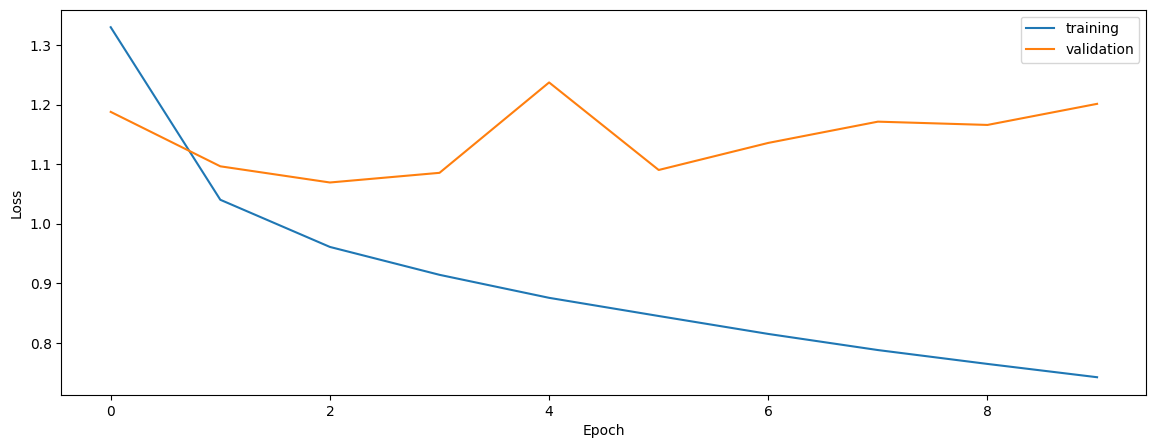

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6428972555280814
0.5705813968466612
0.6361889186178997


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.581075027705565
0.5602283501896334
0.5556083650190115


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5783243071826403
0.570886932972241
0.564673449730412


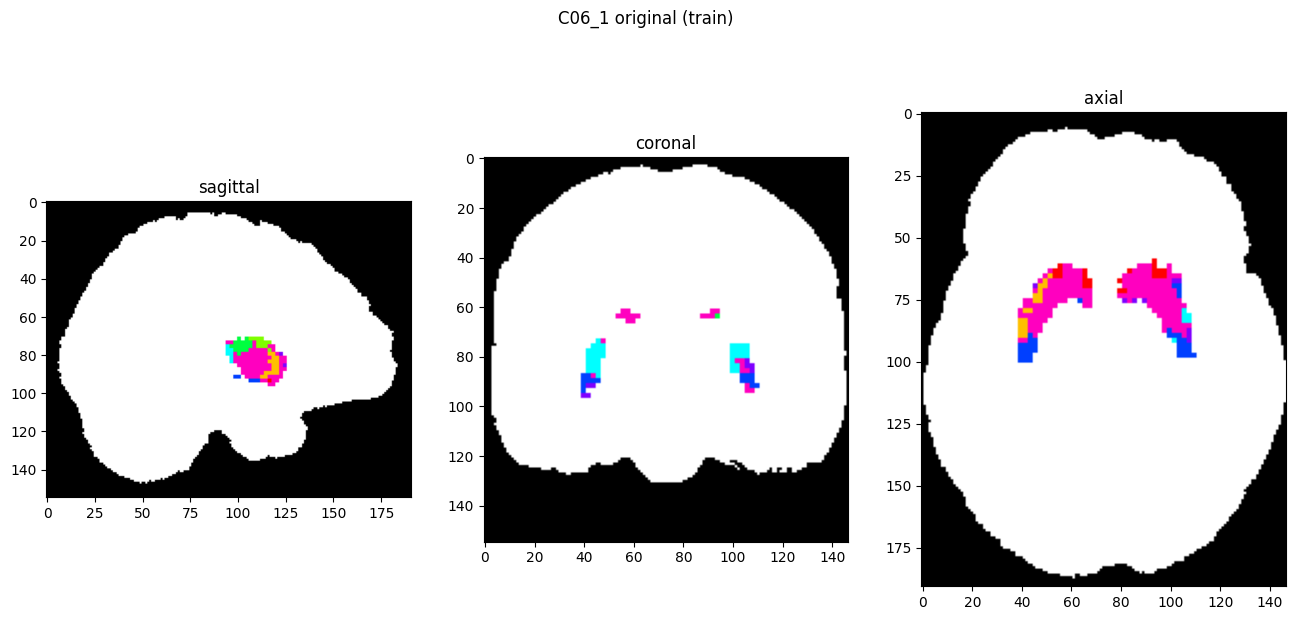

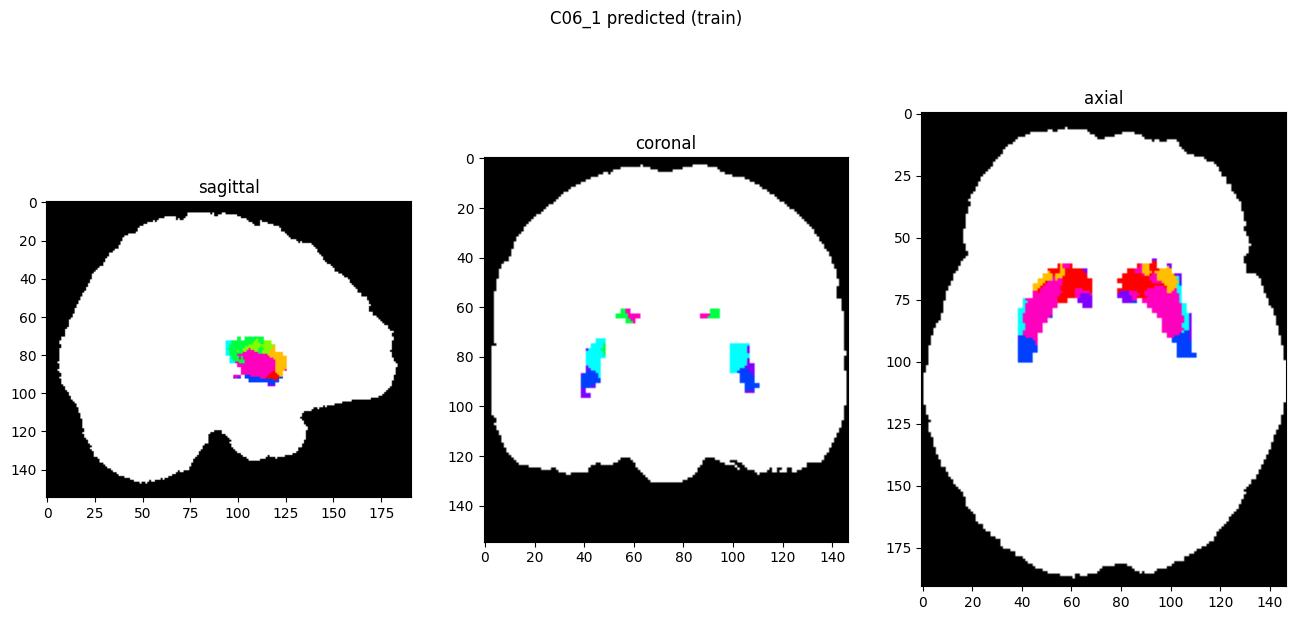

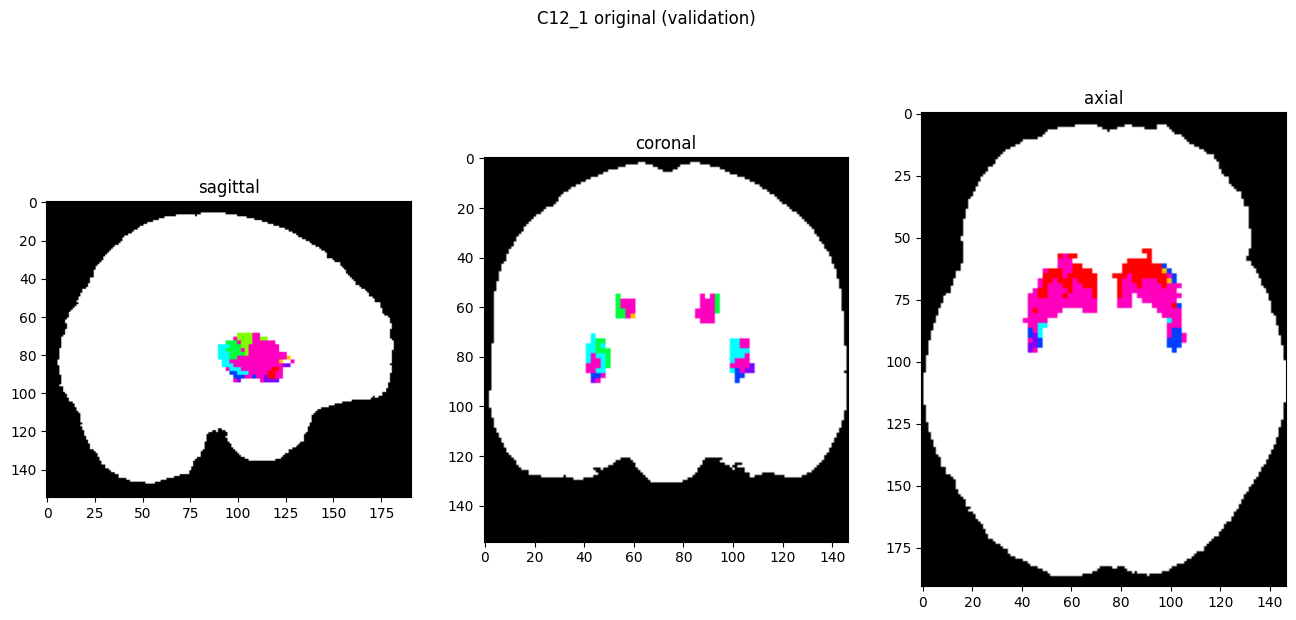

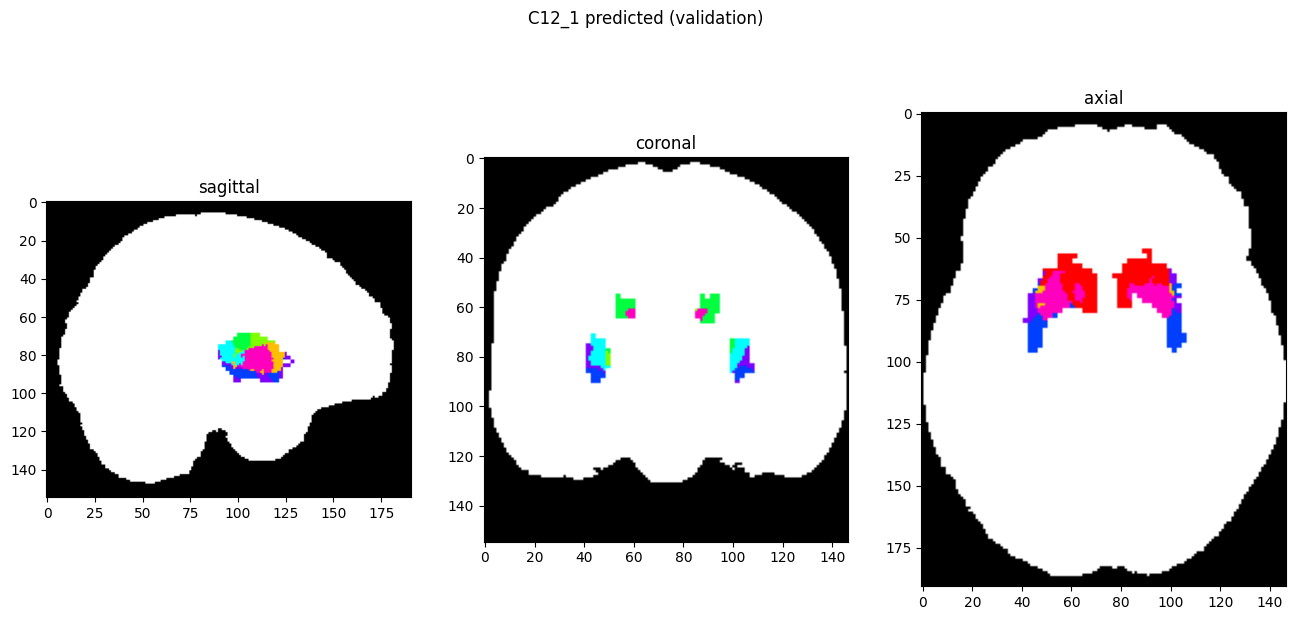

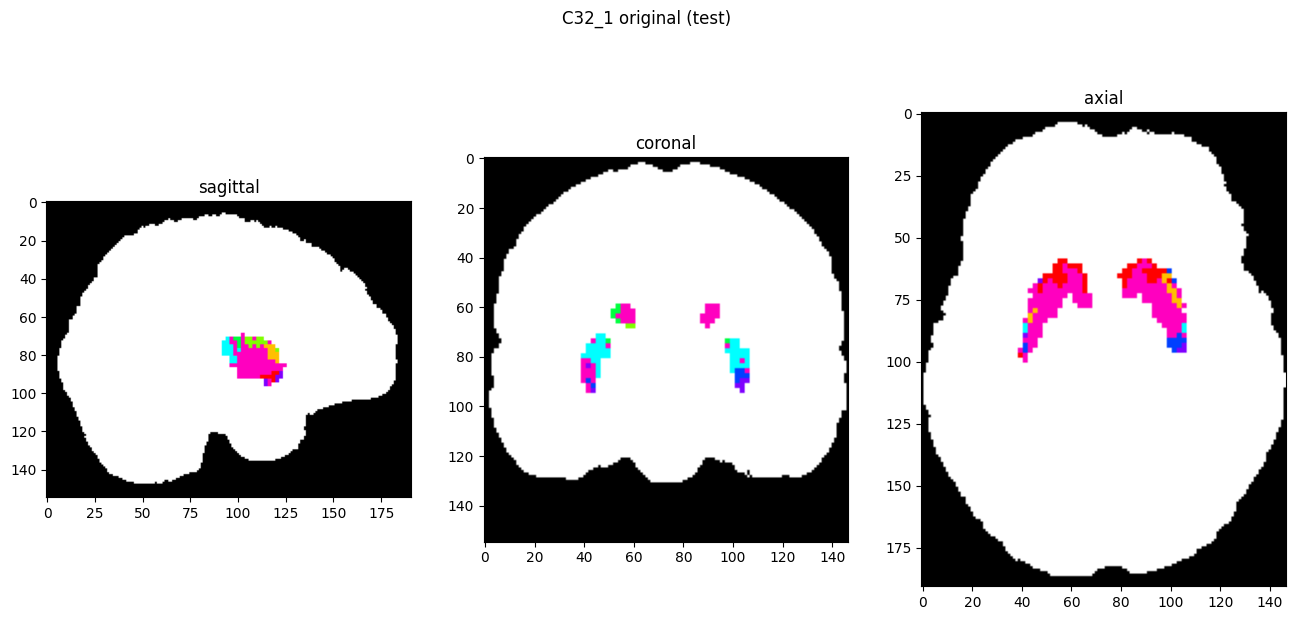

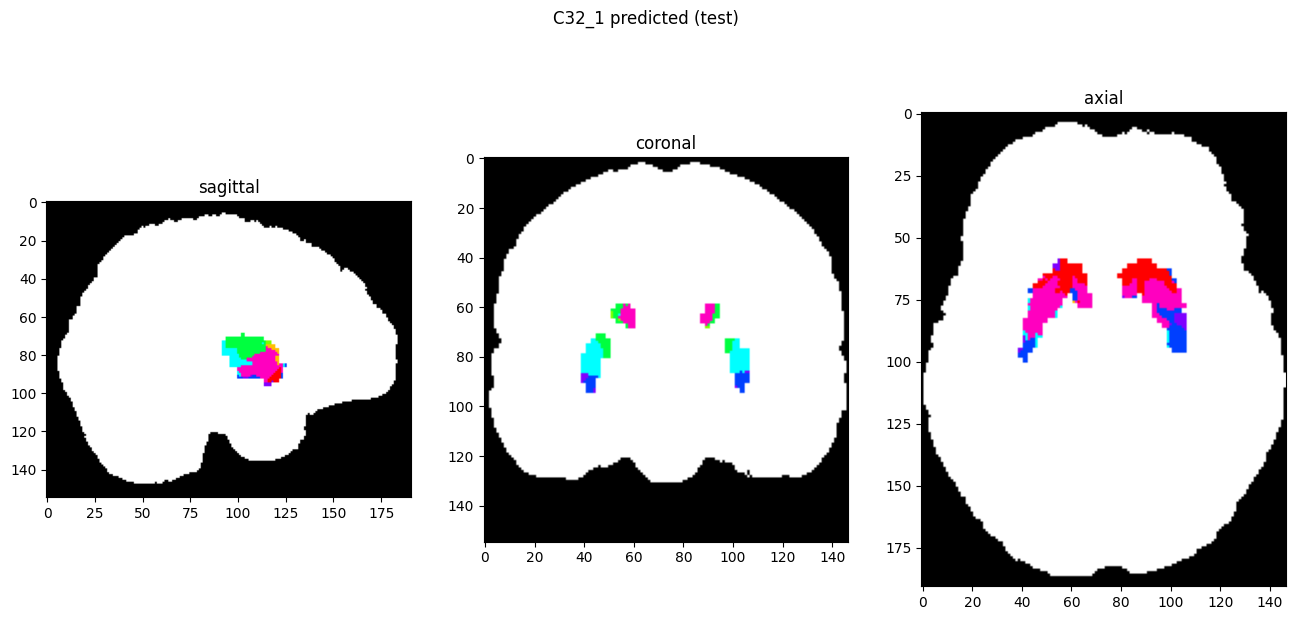

In [10]:
showResults(model, gen, threshold=0)